## Data Description

Here's the data description provided for this dataset. There is no data dictionary in order to avoid leaking user information.

### Transaction Dataframe

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R_) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features**

- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

### Identity Dataframe

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


**Categorical Features**

- DeviceType
- DeviceInfo
- id_12 - id_38

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [163]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

In [176]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBClassifier
import xgboost as xgb

In [5]:
#path = "/content/drive/MyDrive/Colab_Notebooks/IEEE fraud detection/"
path = ""

In [6]:
df_train_id = pd.read_csv(path + "train_identity.csv")

In [7]:
df_train_tran = pd.read_csv(path + "train_transaction.csv")

In [8]:
#Let's display all the columns in the dataframe
pd.set_option('display.max_columns', None)

In [9]:
df_train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [10]:
df_train_tran.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [11]:
df_train_id.shape

(144233, 41)

In [12]:
df_train_tran.shape

(590540, 394)

The transactions dataset appears to be huge.

In [13]:
df_train_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [14]:
#Setting verbose and null_counts to True as info() won't display the details we need by default for such a large dataframe

df_train_tran.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 394 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  int64  
 2   TransactionDT   590540 non-null  int64  
 3   TransactionAmt  590540 non-null  float64
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int64  
 6   card2           581607 non-null  float64
 7   card3           588975 non-null  float64
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float64
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float64
 12  addr2           524834 non-null  float64
 13  dist1           238269 non-null  float64
 14  dist2           37627 non-null   float64
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1       

As we expected, the transaction dataset is very large and takes up 1.7 GB. We can reduce the memory usage by converting 64-bit columns into 32-bit or 16-bit. Let's do this after merging the two dataframes.

### Merging the two dataframes

Let's merge the two dataframes on their identity column: TransactionID

In [15]:
#Checking the number of unique transaction IDs in the identity dataframe and comparing this to the number of rows in the df
print(df_train_id['TransactionID'].unique().shape[0])
print(df_train_id.shape[0])

144233
144233


In [16]:
#Doing the same for the transaction dataframe
print(df_train_tran['TransactionID'].unique().shape[0])
print(df_train_tran.shape[0])

590540
590540


The identity dataframe has fewer unique TransactionIDs than the transaction dataframe. Also, there are no repeated transaction IDs in either dataframe.

Since the transaction dataframe conains more than twice the number of rows that the identity dataframe has, let's retain those rows and add the columns of the identity dataframe wherever possible.

In [17]:
train_df = pd.merge(df_train_id, df_train_tran, on="TransactionID", how='right')

In [18]:
train_df.shape

(590540, 434)

The number of rows in 590540, the same number that we had in the transaction dataframe.

In [19]:
#Deleting the initial dataframes

del df_train_id, df_train_tran

In [20]:
#Triggering garbage collection

gc.collect()

120

### Reducing Memory Usage

Let's check the memory usage of the merged train dataframe.

In [21]:
print("Train set: {:4.2f} Mb".format(train_df.memory_usage().sum() / 1024**2))

Train set: 1959.88 Mb


Let's see if the memory usage of this dataframe can be reduced.

In [22]:
#Defining a function to convert columns to smaller sizes

def float_int_memory_reducer(df, verbose=True):
    
    reduce_datatypes = ['int16', 'int32', 'int64', 'float32', 'float64']        #We'll try to reduce columns with these data types.
    starting_memory = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        
        column_type = df[column].dtypes
        
        if column_type in reduce_datatypes:
            
            col_min = df[column].min()
            col_max = df[column].max()
            
            if str(column_type)[:3] == 'int':
                
                # We can use np.iinfo().max to find the maximum size for integer data types
                
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                    
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                    
    ending_memory = df.memory_usage().sum() / 1024**2
    
    if verbose: 
        print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(ending_memory, 100 * (starting_memory - ending_memory) / starting_memory))
    
    return df

In [23]:
start_process_time = time.time()

In [24]:
train_df = float_int_memory_reducer(train_df)
print('Training set dimensions:', train_df.shape)

Memory usage decreased to 650.48 Mb (66.8% reduction)
Training set dimensions: (590540, 434)


In [25]:
elapsed_time = time.time() - start_process_time
print(elapsed_time/60)

0.9267525871594747


In [26]:
#Triggering garbage collection

gc.collect()

40

#### Repeating these steps (reading, merging, and reducing memory usage) for the test dataset

In [27]:
#Reading the train data from the csv files

df_test_id = pd.read_csv(path + "test_identity.csv")
df_test_tran = pd.read_csv(path + "test_transaction.csv")

print(df_test_id.shape)
print(df_test_tran.shape)

(141907, 41)
(506691, 393)


In [28]:
#Merging the two dataframes
test_df = pd.merge(df_test_id, df_test_tran, on="TransactionID", how='right')
test_df.shape

(506691, 433)

In [29]:
#Deleting the old dataframes

del df_test_id, df_test_tran

In [30]:
#Reducing the memory used by the combined dataframe

test_df = float_int_memory_reducer(test_df)
print('Test set dimensions: ', test_df.shape)

Memory usage decreased to 565.37 Mb (66.3% reduction)
Test set dimensions:  (506691, 433)


In [31]:
#Triggering garbage collection

gc.collect()

20

## Handling Missing Values

In [32]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int32  
 1   id_01           144233 non-null  float16
 2   id_02           140872 non-null  float32
 3   id_03           66324 non-null   float16
 4   id_04           66324 non-null   float16
 5   id_05           136865 non-null  float16
 6   id_06           136865 non-null  float16
 7   id_07           5155 non-null    float16
 8   id_08           5155 non-null    float16
 9   id_09           74926 non-null   float16
 10  id_10           74926 non-null   float16
 11  id_11           140978 non-null  float16
 12  id_12           144233 non-null  object 
 13  id_13           127320 non-null  float16
 14  id_14           80044 non-null   float16
 15  id_15           140985 non-null  object 
 16  id_16           129340 non-null  object 
 17  id_17    

As we can see, there a lot of missing values. Let's check the percentage of missing values in each column.

In [33]:
#Setting the maximum number of rows to display as 500
pd.set_option('display.max_rows', 500)

In [34]:
#Checking the percentage of missing values in each column

(train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending=False)

id_24             99.196159
id_25             99.130965
id_07             99.127070
id_08             99.127070
id_21             99.126393
id_26             99.125715
id_27             99.124699
id_23             99.124699
id_22             99.124699
dist2             93.628374
D7                93.409930
id_18             92.360721
D13               89.509263
D14               89.469469
D12               89.041047
id_04             88.768923
id_03             88.768923
D6                87.606767
id_33             87.589494
id_10             87.312290
D8                87.312290
id_09             87.312290
D9                87.312290
id_30             86.865411
id_32             86.861855
id_34             86.824771
id_14             86.445626
V157              86.123717
V162              86.123717
V139              86.123717
V138              86.123717
V155              86.123717
V149              86.123717
V141              86.123717
V148              86.123717
V147              86

In [35]:
#Storing the column names and their percentage of missing values in a new dataframe

missing_values_df = pd.DataFrame(train_df.isnull().sum()*100/train_df.shape[0])

In [36]:
missing_values_df.head()

,0
TransactionID,0.000000
id_01,75.576083
id_02,76.145223
id_03,88.768923
id_04,88.768923


This dataframe needs to be formatted.

In [37]:
#Storing the column names in a different column
missing_values_df['Column_name'] = missing_values_df.index

In [38]:
#Renaming the column 0
missing_values_df.rename(columns = {0 : 'Percentage_missing'}, inplace=True)

In [39]:
#Resetting the index of the dataframe to have numerical values
missing_values_df = missing_values_df.reset_index(drop=True)

In [40]:
missing_values_df.head()

,Percentage_missing,Column_name
0,0.000000,TransactionID
1,75.576083,id_01
2,76.145223,id_02
3,88.768923,id_03
4,88.768923,id_04


In [41]:
#Rearranging the columns in the dataframe

missing_values_df = missing_values_df[['Column_name', 'Percentage_missing']]
missing_values_df.head()

,Column_name,Percentage_missing
0,TransactionID,0.000000
1,id_01,75.576083
2,id_02,76.145223
3,id_03,88.768923
4,id_04,88.768923


In [42]:
#Sorting the column names by their percentage of missing values

missing_values_df.sort_values(by='Percentage_missing', ascending=False)

,Column_name,Percentage_missing
24,id_24,99.196159
25,id_25,99.130965
7,id_07,99.127070
8,id_08,99.127070
21,id_21,99.126393
26,id_26,99.125715
27,id_27,99.124699
23,id_23,99.124699
22,id_22,99.124699
54,dist2,93.628374


There's a jump from 75.58% missing to 59.65% missing values, and a similar jump from 44.52% to 28.68%.

In [43]:
#Checking the number of columns that have 75% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 75].shape[0]

208

In [44]:
#Checking the number of columns that have 40% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 50].shape[0]

214

In [45]:
#Checking the number of columns that have 40% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 40].shape[0]

232

In [46]:
#A reminder of the dimensions of the dataframe
train_df.shape

(590540, 434)

Since the difference between the number of columns that have 75% (or more) values missing and 40% (or more) values missing is 232 - 208 = 24 columns, let's go ahead and drop columns that have 40% missing values or more. This will mean dropping 232 columns.

In [47]:
#Removing the columns that have 40% missing values or more from this list
missing_values_df = missing_values_df[missing_values_df['Percentage_missing'] < 40]

In [48]:
#Sorting the column names by their percentage of missing values

missing_values_df.sort_values(by='Percentage_missing', ascending=False)

,Column_name,Percentage_missing
91,M6,28.678836
135,V41,28.612626
140,V46,28.612626
146,V52,28.612626
145,V51,28.612626
144,V50,28.612626
143,V49,28.612626
142,V48,28.612626
141,V47,28.612626
139,V45,28.612626


In [49]:
#Storing the names of the columns to be retained in a list

cols_to_retain = missing_values_df['Column_name'].tolist()

In [50]:
#Making a note of the columns that are being dropped (to make the same changes to the training set)
dropped_columns = list(set(train_df.columns) - set(cols_to_retain))

In [51]:
#Checking the number of columns that we're planning to drop

print(train_df.shape)
print(train_df[cols_to_retain].shape)

(590540, 434)
(590540, 202)


Dropping the columns that have 40% (or more) null values (i.e., dropping 232 columns)

In [52]:
train_df = train_df[cols_to_retain]
train_df.shape

(590540, 202)

We cannot drop any rows, as we need to provide a probability of fraud for all the rows of the test set.

In [53]:
#Deleting variables that are no longer required

del cols_to_retain

In [54]:
#Triggering garbage collection

gc.collect()

80

In [55]:
#Let's drop the TransactionID column, as that adds no value

train_df.drop(['TransactionID'], axis=1, inplace=True)

Since the TransactionID and probability of fraud are the two columns that need to be submitted, this column shouldn't be directly dropped from the test set.

In [56]:
train_df.head(10)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,0.0,T,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,T,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

#### Dropping columns in the test set

In [57]:
#Taking a look at the list of dropped columns

print(dropped_columns)

['V179', 'id_19', 'V190', 'V234', 'V214', 'V278', 'V153', 'V324', 'V259', 'id_07', 'V205', 'V339', 'V275', 'id_24', 'D9', 'V143', 'V327', 'V187', 'D11', 'id_38', 'V176', 'V201', 'DeviceInfo', 'V8', 'V146', 'V158', 'V240', 'id_25', 'V230', 'V270', 'id_21', 'V249', 'V276', 'id_36', 'id_16', 'V161', 'V141', 'V168', 'V241', 'D3', 'V169', 'V1', 'M9', 'V160', 'V145', 'V330', 'V203', 'V162', 'V268', 'V334', 'V258', 'V210', 'V223', 'V220', 'M1', 'V271', 'V253', 'id_15', 'V219', 'V247', 'id_11', 'V207', 'V7', 'V245', 'V242', 'V274', 'V264', 'M2', 'V226', 'dist1', 'V154', 'V243', 'dist2', 'D7', 'V9', 'V159', 'id_22', 'V221', 'V206', 'V209', 'V248', 'V6', 'V256', 'V231', 'V215', 'id_18', 'id_30', 'V251', 'V266', 'V186', 'V213', 'V337', 'V323', 'V222', 'R_emaildomain', 'V178', 'V261', 'V194', 'V333', 'V5', 'id_04', 'V193', 'V175', 'V273', 'V173', 'V138', 'V155', 'M5', 'id_13', 'V198', 'V195', 'D8', 'V328', 'V156', 'V227', 'V272', 'V208', 'V197', 'M7', 'V336', 'V217', 'D12', 'V170', 'D2', 'V322', '

In [58]:
#Taking a look at the columns in the test set
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Data columns (total 433 columns):
 #   Column          Dtype  
---  ------          -----  
 0   TransactionID   int32  
 1   id-01           float16
 2   id-02           float32
 3   id-03           float16
 4   id-04           float16
 5   id-05           float16
 6   id-06           float16
 7   id-07           float16
 8   id-08           float16
 9   id-09           float16
 10  id-10           float16
 11  id-11           float16
 12  id-12           object 
 13  id-13           float16
 14  id-14           float16
 15  id-15           object 
 16  id-16           object 
 17  id-17           float16
 18  id-18           float16
 19  id-19           float16
 20  id-20           float16
 21  id-21           float16
 22  id-22           float16
 23  id-23           object 
 24  id-24           float16
 25  id-25           float16
 26  id-26           float16
 27  id-27           object 
 28  id-28        

Some of the column names are different in the test set. The id columns are followed by hyphens instead of underscores.

In [59]:
#Changing underscores to hyphens in the list of dropped columns
dropped_columns = [re.sub("id_", "id-", str(i)) for i in dropped_columns]

In [60]:
#Comparing the number of columns in the dataframe and the number of columns that will be dropped
print(test_df.shape[1])
print(test_df[dropped_columns].shape[1])

433
232


In [61]:
#Dropping columns in the test set
cols_to_retain = set(list(test_df.columns)) - set(dropped_columns)
test_df = test_df[cols_to_retain]
test_df.shape

(506691, 201)

### Replacing null values in categorical columns with 'unknown'

In [62]:
#Creating a list of the categorical columns in the dataframe
categorical_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']

In [63]:
#Replacing missing values with 'unknown' in categorical columns
train_df[categorical_columns] = train_df[categorical_columns].apply(lambda x: x.fillna('unknown'))

Let's take a look at the percentage of missing data in each column again.

In [64]:
train_df.isnull().sum()*100/train_df.shape[0]

isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.000000
card5              0.721204
card6              0.000000
addr1             11.126427
addr2             11.126427
P_emaildomain      0.000000
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.214888
D4                28.604667
D10               12.873302
D15               15.090087
M6                 0.000000
V12               12.881939
V13               12.881939
V14               12.881939
V15               12

Making a note that we haven't dealt with all the null values in this dataset. This will limit the models that we can use.

#### Replacing null values in the test set

In [65]:
test_df[categorical_columns] = test_df[categorical_columns].apply(lambda x: x.fillna('unknown'))

## Data Exploration and Outlier Treatment

In [66]:
train_df.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,421618.0,514518.0,501427.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590528.0,590528.0,589271.000000,589271.0,589271.0,590528.000000,590528.0,590528.000000,590528.0,589271.0,589271.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,589271.0,590528.000000,590528.0,590528.0,589271.000000,589271.000000,590528.0,590528.0,590528.0,590528.0,590528.000000,590528.000000,590528.000000,590528.0,590528.0000,590528.0,590528.0,589271.0,589271.0,589271.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000
mean,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122375,0.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000775,0.000830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061920,NaN,NaN,NaN,NaN,NaN,0.085327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.976227,336.539764,204.077377,NaN,NaN,NaN,103.512779,204.886200,145.971436,17.250622,38.821007,26.365685,NaN,NaN,0.087708,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089111,NaN,NaN,0.045471,0.052002,NaN,NaN,NaN,NaN,139.743408,408.579376,230.389160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.817917,247.600327,162.151230,18.372953,42.073849,28.327173
std,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.

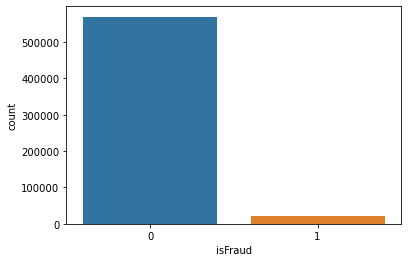

In [67]:
#Plotting the target variable

sns.countplot(x = train_df['isFraud'])
plt.show()

Let's look at this class imbalance in numbers.

In [68]:
train_df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [69]:
percentage_1 = train_df[train_df['isFraud']==1].shape[0]*100/train_df.shape[0]
print("Percentage of values in the target variable that are one: " + str(round(percentage_1, 3)) + "%")

Percentage of values in the target variable that are one: 3.499%


There's a huge class imbalance in this variable. This will have to be accounted for while building models.

#### Let's look at the TransactionDT column

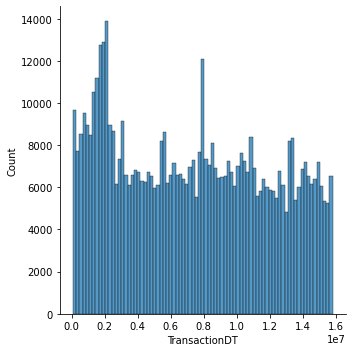

In [70]:
sns.displot(train_df['TransactionDT'])
plt.show()

Since this column is the timedelta from a given reference datetime, and it is given in seconds, we can convert the seconds to days and hours.

In [71]:
train_df['TransactionDT'][150000]

3093457

In [72]:
#Creating a new column for transaction day

train_df['TransactionDay'] = (train_df['TransactionDT']//(24*60*60))%7

In [73]:
#Specifying a lambda function to use an estimator

percentage = lambda x: float(len(x))/len(train_df['TransactionDay'])*100

In [74]:
#Setting the seaborn color palette

sns.set_palette('Paired')

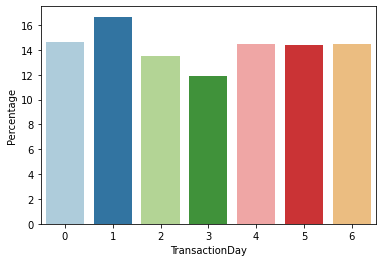

In [75]:
ax = sns.barplot(x = train_df['TransactionDay'], y = train_df['TransactionDay'], estimator = percentage)
ax.set(ylabel='Percentage')
plt.show()

Day 1 has the most transactions, whereas Day 3 has the lowest. This variable needs to be treated as a categorical variable (nominal data).


Let's check the percentage of fraud committed on each day.

In [76]:
#Creating a group by object
train_group_day = train_df.groupby(['isFraud'])

In [77]:
#Normalizing the value counts so that the isFraud=0 values are also visible (the class imbalance makes plots of those values
# very small). Also multiplying by 100, resetting the index, and sorting by the days of the week

train_group_day = train_group_day['TransactionDay'].value_counts(normalize=True).rename('Percentage').mul(100).reset_index().sort_values('TransactionDay')
train_group_day

,isFraud,TransactionDay,Percentage
1,0,0,14.593675
8,1,0,15.539854
0,0,1,16.661841
7,1,1,17.180468
5,0,2,13.489051
9,1,2,14.339641
6,0,3,11.883266
13,1,3,12.113439
2,0,4,14.519975
12,1,4,13.003920


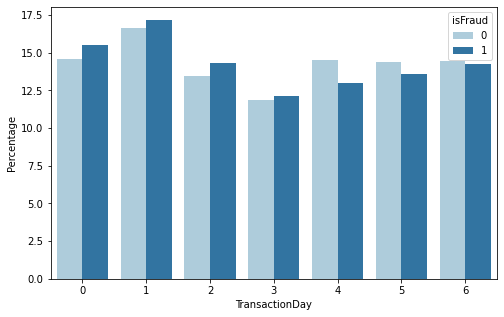

In [78]:
plt.figure(figsize=(8, 5))
sns.barplot(x='TransactionDay', y='Percentage', hue='isFraud', data=train_group_day)
plt.show()

The percentage of fraud committed is relatively higher on days 0 to 3, and lower on the rest of the days.

In [79]:
#Creating a new column for transaction hour

train_df['TransactionHour'] = (train_df['TransactionDT']//(60*60))%24

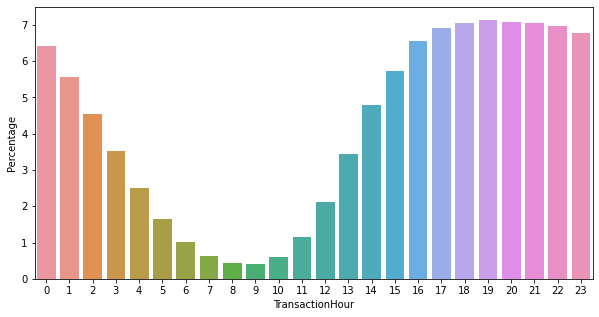

In [80]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = train_df['TransactionHour'], y = train_df['TransactionHour'], estimator = percentage)
ax.set(ylabel='Percentage')
plt.show()

Very few transactions occur between the hours 4 and 12.

In [81]:
#Creating a group by object
train_group_hour = train_df.groupby(['isFraud'])

In [82]:
#Similar operations as before

train_group_hour = train_group_hour['TransactionHour'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index().sort_values('TransactionHour')
train_group_hour

,isFraud,TransactionHour,Percentage
8,0,0,6.424018
31,1,0,5.739728
33,1,1,4.970237
10,0,1,5.574887
34,1,2,4.849247
12,0,2,4.515009
13,0,3,3.510407
36,1,3,3.857136
15,0,4,2.468778
37,1,4,3.726468


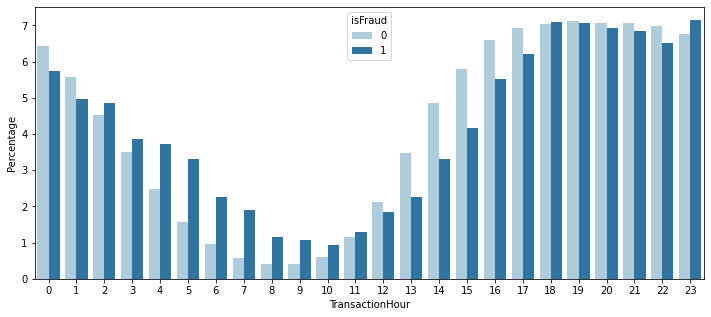

In [83]:
plt.figure(figsize=(12, 5))
sns.barplot(x='TransactionHour', y='Percentage', hue='isFraud', data=train_group_hour)
plt.show()

In [84]:
#We can drop the 'TransactionDT' column as it's no longer required

train_df = train_df.drop(['TransactionDT'], axis=1)

Let's create a new column that categorizes the transaction hour as high, medium, or low risk.

In [85]:
def TransactionHour_Risk_Categorizer(hour):
    if (hour >= 4 and hour <=9):
        return "low"
    elif (hour >= 12 and hour <= 17) or (hour == 0 or hour == 1 or hour == 22):
        return "high"
    else:
        return "medium"

In [86]:
train_df['TransactionHour_Risk'] = train_df['TransactionHour'].apply(TransactionHour_Risk_Categorizer)
train_df['TransactionHour_Risk'].value_counts()

high      286105
medium    265114
low        39321
Name: TransactionHour_Risk, dtype: int64

In [87]:
#We can drop the 'TransactionHour' column as it's no longer required

train_df = train_df.drop(['TransactionHour'], axis=1)

In [88]:
#Adding the two new columns to the list of categorical columns (they should be treated as categorical columns)

categorical_columns.append('TransactionDay')
categorical_columns.append('TransactionHour_Risk')
categorical_columns

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'M6',
 'TransactionDay',
 'TransactionHour_Risk']

In [89]:
#Deleting variables that are no longer required

del train_group_hour, train_group_day

In [90]:
#Triggering garbage collection

gc.collect()

22932

#### Repeating the steps related to the TransactionDT column in the test set

In [91]:
#Creating a new column for transaction day

test_df['TransactionDay'] = (test_df['TransactionDT']//(24*60*60))%7

In [92]:
#Creating a new column for transaction hour

test_df['TransactionHour'] = (test_df['TransactionDT']//(60*60))%24

In [93]:
#We can drop the 'TransactionDT' column as it's no longer required

test_df = test_df.drop(['TransactionDT'], axis=1)

In [94]:
#Creating a new column that categorizes the transaction hour as high, medium, or low risk
test_df['TransactionHour_Risk'] = test_df['TransactionHour'].apply(TransactionHour_Risk_Categorizer)
test_df['TransactionHour_Risk'].value_counts()

high      248724
medium    225233
low        32734
Name: TransactionHour_Risk, dtype: int64

In [95]:
#We can drop the 'TransactionHour' column as it's no longer required

test_df = test_df.drop(['TransactionHour'], axis=1)

#### Let's look at the TransactionAMT column

In [96]:
train_df['TransactionAmt'].describe()

count    590540.000000
mean               NaN
std                NaN
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64

There's a big jump from the 75th percentile to the max value. Let's take a closer look.

In [97]:
print("95 percentile: {} \n99 percentile: {} \n99.5 percentile: {} \n99.9 percentile: {:,.2f}" .format(
    train_df['TransactionAmt'].quantile(0.95), train_df['TransactionAmt'].quantile(0.99), 
    train_df['TransactionAmt'].quantile(0.995), train_df['TransactionAmt'].quantile(0.999)))

95 percentile: 445.0 
99 percentile: 1104.0 
99.5 percentile: 1656.0 
99.9 percentile: 2,768.92


Since the values of the 99.9 percentile indicate that there are outliers in this column, let's check for outliers in the other variables too.

### i. Outlier Treatment

In [98]:
#Adding percentiles to the describe() function

train_df.describe(percentiles=[.25, .5, .75, .95, .99, .995, .999, .9995])

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay
count,590540.000000,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,590540.0,590540.0,590540.000000,590540.000,590540.0,590540.000,590540.000,590540.0,590540.0,590540.0,590540.000,590540.000,590540.0,590540.000,589271.0,421618.0,514518.0,501427.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.000000,590226.00,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590528.0,590528.0,589271.000000,589271.0,589271.0,590528.000000,590528.0,590528.000000,590528.0,589271.0,589271.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,589271.0,590528.000000,590528.0,590528.0,589271.000000,589271.000000,590528.0,590528.0,590528.0,590528.0,590528.000000,590528.000000,590528.000000,590528.0,590528.0000,590528.0,590528.000,589271.0000,589271.0,589271.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590540.000000
mean,0.034990,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122375,0.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000775,0.000830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061920,NaN,NaN,NaN,NaN,NaN,0.085327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.976227,336.539764,204.077377,NaN,NaN,NaN,103.512779,204.886200,145.971436,17.250622,38.821007,26.365685,NaN,NaN,0.087708,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089111,NaN,NaN,0.045471,0.052002,NaN,NaN,NaN,NaN,139.743408,408.579376,230.389160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.817917,247.600327,162.151230,18.372953,42.073849,28.327173,2.957940
std,0.183755,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

From the percentile values, it looks like capping these columns at 99.5% will not be enough (I tried dropping all rows where one of the columns was 99.95% or higher, and this removed more than 50% of the rows). 

Let's look at the distributions of some of the columns with outliers.

In [99]:
#Setting the seaborn color palette to default

sns.set()

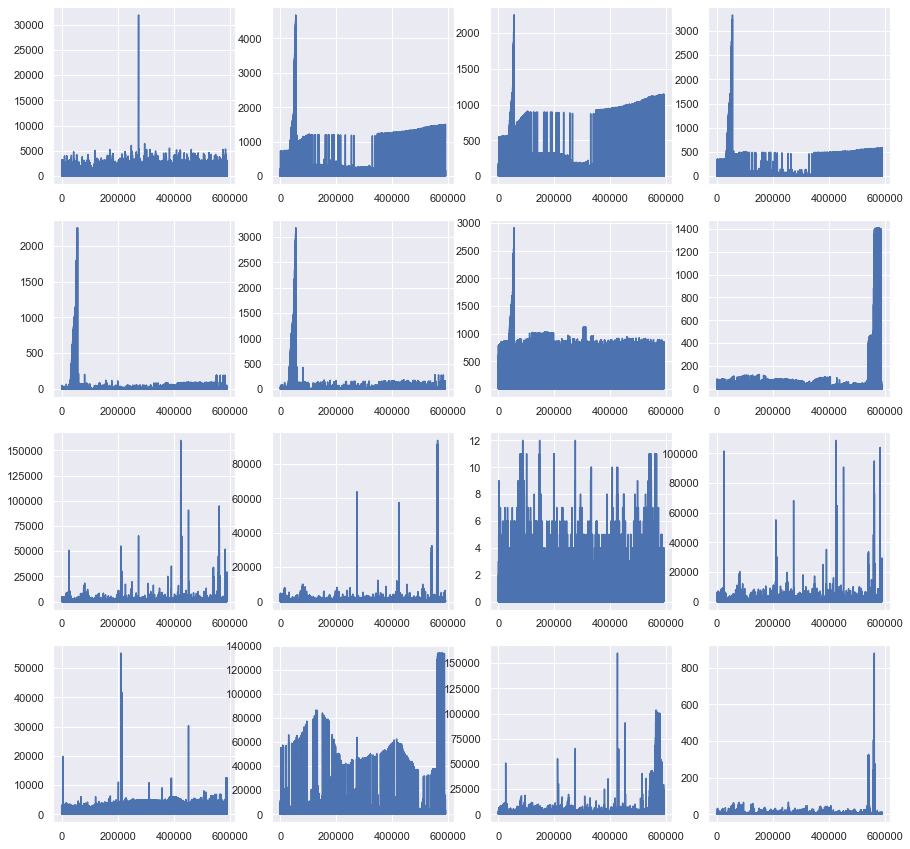

In [100]:
fig, a =  plt.subplots(4,4, figsize=(15,15))

a[0][0].plot(train_df.index, train_df['TransactionAmt'])
a[0][1].plot(train_df.index, train_df['C1'])
a[0][2].plot(train_df.index, train_df['C6'])
a[0][3].plot(train_df.index, train_df['C8'])

a[1][0].plot(train_df.index, train_df['C7'])
a[1][1].plot(train_df.index, train_df['C12'])
a[1][2].plot(train_df.index, train_df['C13'])
a[1][3].plot(train_df.index, train_df['V96'])

a[2][0].plot(train_df.index, train_df['V126'])
a[2][1].plot(train_df.index, train_df['V132'])
a[2][2].plot(train_df.index, train_df['V297'])
a[2][3].plot(train_df.index, train_df['V306'])

a[3][0].plot(train_df.index, train_df['V310'])
a[3][1].plot(train_df.index, train_df['V317'])
a[3][2].plot(train_df.index, train_df['V128'])
a[3][3].plot(train_df.index, train_df['V279'])


plt.show()

These variables are skewed and/or have tall spikes in between. Applying a transformation will be better.

In [101]:
#Creating a backup of the dataframe

train_df_backup = train_df.copy()

In [102]:
#Triggering garbage collection

gc.collect()

9101

### Outlier treatment - log transformation

In [103]:
#Creating a list of columns that are to be transformed

cols_transform = ['TransactionAmt', 'card1', 'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 
                    'V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
                    'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V291', 'V292', 'V293', 'V294', 'V295', 'V306', 
                    'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 
                    'V320', 'V321']

In [104]:
#Creating a function to check if there are columns that do not contain any zeros 

def check_col_zeros(df):
    for col in df.columns:
        cols_non_zero = []
        if not (df[col]==0).any():
            cols_non_zero.append(str(col))
    return cols_non_zero          
    

In [105]:
#Checking if the columns that we want to transform contain zero values

cols_log_transform = check_col_zeros(train_df[cols_transform])
len(cols_log_transform)

0

Since all of these columns contain zero values, we cannot use a log transformation directly (as we'll get negative infinity wherever there's a zero). Let's add a constant value before we apply the log function.

In [106]:
#Defining a function to apply log transformation

def log_transform(df, cols_to_transform):
    for col in df.columns:
        if col in cols_to_transform:
            df[col] = np.log(df[col]+1)                #This is to ensure that we don't get -ve inf values
    return df

In [107]:
train_df = log_transform(train_df, cols_transform)

In [108]:
#Let's look at the distribution of variables again

train_df.describe(percentiles=[.25, .5, .75, .95, .99, .995, .999, .9995])

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay
count,590540.000000,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.0,421618.0,514518.0,501427.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590528.000000,590528.000000,589271.000000,589271.0,589271.0,590528.000000,590528.0,590528.000000,590528.0,589271.0,589271.0,590528.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.0,590528.000000,590528.0,590528.0,589271.000000,589271.000000,590528.0,590528.0,590528.0,590528.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590540.000000
mean,0.034990,NaN,9.026290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122375,0.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000775,0.000830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061920,NaN,NaN,0.064636,NaN,0.088806,0.085327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.673945,1.990060,1.160394,NaN,NaN,NaN,0.297811,0.503035,0.384594,0.228441,0.367832,0.278245,NaN,NaN,0.087708,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,0.084595,NaN,NaN,NaN,0.089111,NaN,NaN,0.045471,0.052002,NaN,NaN,NaN,NaN,0.823605,2.442684,1.427412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381876,0.656799,0.498714,0.237079,0.410182,0.300843,

The distribution looks much better. Also, we've got zeros instead of -inf as we've used log(x+1).

Let's look at some of the transformed columns.

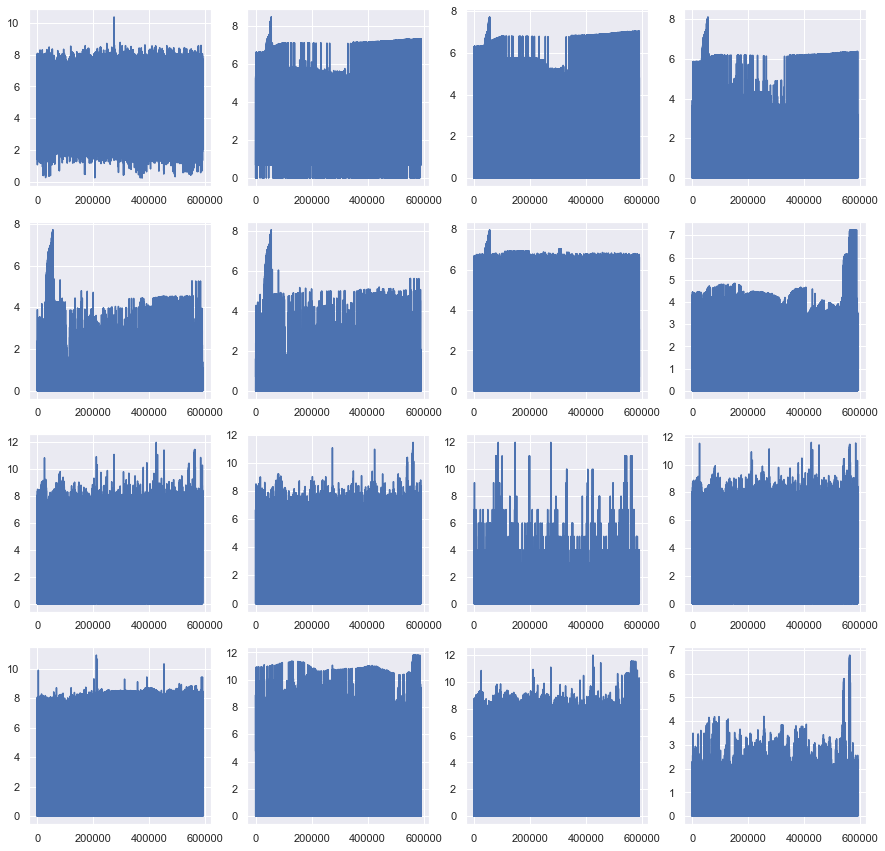

In [109]:
fig, a =  plt.subplots(4,4, figsize=(15,15))

a[0][0].plot(train_df.index, train_df['TransactionAmt'])
a[0][1].plot(train_df.index, train_df['C1'])
a[0][2].plot(train_df.index, train_df['C6'])
a[0][3].plot(train_df.index, train_df['C8'])

a[1][0].plot(train_df.index, train_df['C7'])
a[1][1].plot(train_df.index, train_df['C12'])
a[1][2].plot(train_df.index, train_df['C13'])
a[1][3].plot(train_df.index, train_df['V96'])

a[2][0].plot(train_df.index, train_df['V126'])
a[2][1].plot(train_df.index, train_df['V132'])
a[2][2].plot(train_df.index, train_df['V297'])
a[2][3].plot(train_df.index, train_df['V306'])

a[3][0].plot(train_df.index, train_df['V310'])
a[3][1].plot(train_df.index, train_df['V317'])
a[3][2].plot(train_df.index, train_df['V128'])
a[3][3].plot(train_df.index, train_df['V279'])


plt.show()

Most of the variables' distributions are better. Some of them still have spikes, but the difference in value between the spike and the trough is much lesser now.

In [110]:
#Deleting some variables that we no longer need

del cols_log_transform

In [111]:
#Triggering garbage collection

gc.collect()

37833

#### Repeating these steps for the test set

In [112]:
#Performing log transformation

test_df = log_transform(test_df, cols_transform)

#### Getting back to data exploration

Let's visualize the initial few variables: TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, and P_emaildomain.

In [113]:
#To visualize the ProductCD column, we need to use groupby (since we want the 0 and 1 values to be comparable)

ProductCD_group = (train_df.groupby(['isFraud'])['ProductCD'].value_counts(normalize=True).mul(100).rename('Percentage')
                            .reset_index().sort_values('ProductCD'))

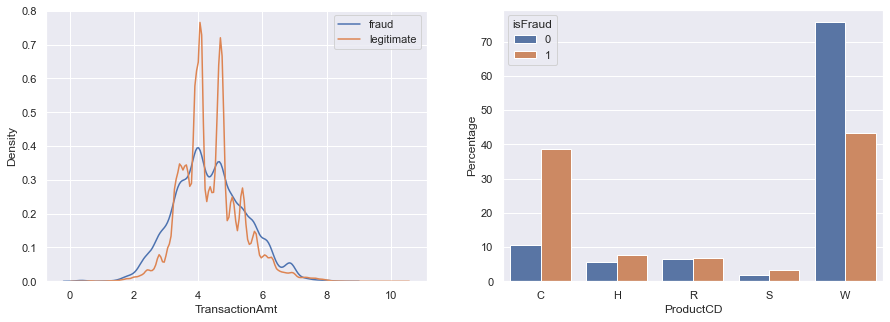

In [114]:
#Plotting the two variables
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['TransactionAmt'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['TransactionAmt'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.barplot(x="ProductCD", y="Percentage", hue="isFraud", data=ProductCD_group)

plt.show()

In the TransactionAmt variable, the fraudulent transactions have a wider spread, and the legitimate transactions are more likely to be closer to the mid-value.

The ProductCD graph shows that the highest percentage of fraudulent transactions occur for product type 'C'.

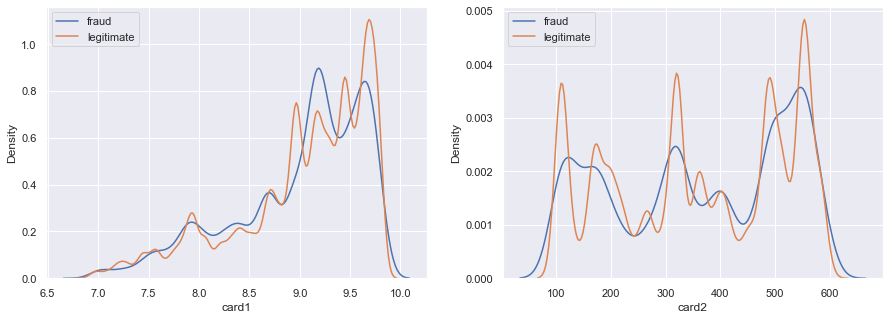

In [115]:
#Plotting the variables card1 and card2
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card1'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card1'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['isFraud']==1]['card2'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card2'], hist=False)
plt.legend(['fraud','legitimate'])

plt.show()

card1 is skewed even after the log transformation. Both variables show a similar spread for fraudulent and legitimate transactions. However, the spikes in the card2 graph show that a lot of legitimate transactions are concentrated around certain values (105, 310, and 550).

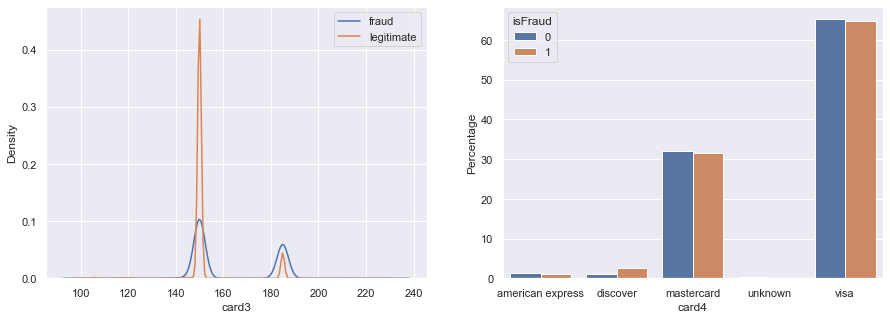

In [116]:
#Plotting the variables card3 and card4
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card3'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card3'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
card4_group = (train_df.groupby(['isFraud'])['card4'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
                        .sort_values('card4'))
sns.barplot(x="card4", y="Percentage", hue="isFraud", data=card4_group)

plt.show()

card3 shows that the likelihood of fraudulent transactions increases with its value. card4 shows a fairly even percentage of fraudulent and legitimate transactions.

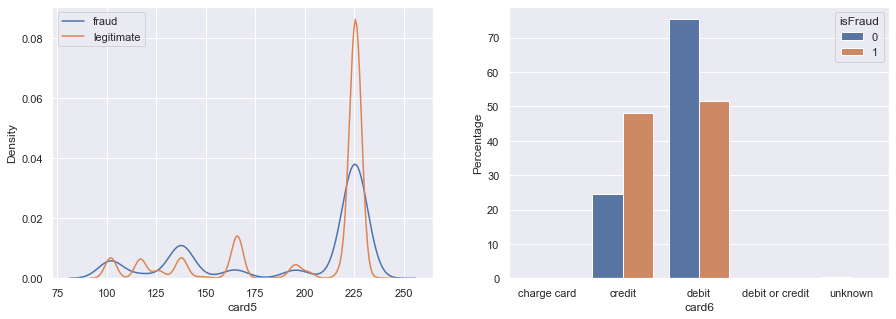

In [117]:
#Plotting the variables card5 and card6
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card5'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card5'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
card6_group = (train_df.groupby(['isFraud'])['card6'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
                        .sort_values('card6'))
sns.barplot(x="card6", y="Percentage", hue="isFraud", data=card6_group)

plt.show()

card5 shows that legitimate transactions are more likely for higher values of this variable. We can also see that credit card transactions are more likely to be fraudulent than debit card transactions.

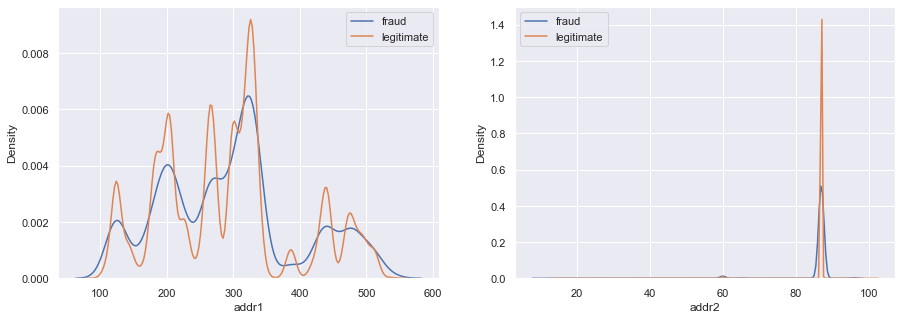

In [118]:
#Plotting the variables addr1 and addr2
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['addr1'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['addr1'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['isFraud']==1]['addr2'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['addr2'], hist=False)
plt.legend(['fraud','legitimate'])

plt.show()

addr1 and addr2 show similar distributions for legit and fraud transactions.

In [119]:
#Checking the number of categories in the p_emaildomain column
print("Number of unique values in the column: {}" .format(len(train_df['P_emaildomain'].unique())))
train_df['P_emaildomain'].value_counts()

Number of unique values in the column: 60


gmail.com           228355
yahoo.com           100934
unknown              94456
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
n

Categories such as yahoo.com.mx and ymail can be merged with the category yahoo.

#### Merging categories in P_emaildomain column

In [120]:
# The next block does the same thing much more efficiently
# Leaving this code here to show how to apply a lambda function when a whole row is the input and we need to specify
# the columns of that row--useful if more than one column needs to be changed

# #Let's discard all characters from the first '.' to the end of the string in the email domains

# email_domain_col = train_df.apply(lambda row: re.sub("\..*$", '', str(row['P_emaildomain'])), axis=1)   #The str() is needed
# #as there are null values in the column and they throw errors when used as a regex pattern


In [121]:
#Let's discard all characters from the first '.' to the end of the string in the email domains

train_df['P_emaildomain'] = train_df['P_emaildomain'].apply(lambda x: re.sub("\..*$", '', str(x)))

In [122]:
#Also replacing 'ymail' with 'yahoo'

train_df['P_emaildomain'] = train_df['P_emaildomain'].apply(lambda x: 'yahoo' if x == 'ymail' else x)

In [123]:
#Viewing the first 25 rows of the P_emaildomain column

train_df['P_emaildomain'][:25]

0       unknown
1         gmail
2       outlook
3         yahoo
4         gmail
5         gmail
6         yahoo
7          mail
8     anonymous
9         yahoo
10        gmail
11      hotmail
12      verizon
13          aol
14        yahoo
15      unknown
16          aol
17        yahoo
18        gmail
19        gmail
20        gmail
21        gmail
22        gmail
23        gmail
24        gmail
Name: P_emaildomain, dtype: object

In [124]:
#Deleting the old backup dataframe

del train_df_backup

In [125]:
#Making a new backup of the dataframe
train_df_backup_2 = train_df.copy()

In [126]:
#Making the same change to the P_emaildomain column in the test set
test_df['P_emaildomain'] = test_df['P_emaildomain'].apply(lambda x: re.sub("\..*$", '', str(x)))

#Also replacing 'ymail' with 'yahoo' in the test set
test_df['P_emaildomain'] = test_df['P_emaildomain'].apply(lambda x: 'yahoo' if x == 'ymail' else x)

In [127]:
print("Number of email domains in the training set {}".format(len(set(train_df['P_emaildomain']))))
print("Number of email domains in the test set {}".format(len(set(test_df['P_emaildomain']))))

Number of email domains in the training set 44
Number of email domains in the test set 45


In [128]:
#Checking the email domain that's not present in the training set
set(test_df['P_emaildomain']) - set(train_df['P_emaildomain'])

{'scranton'}

In [129]:
#Let's check the number of times the domain name 'scranton' appears in the test set
test_df['P_emaildomain'].value_counts()

gmail           207945
yahoo            85338
unknown          69192
hotmail          41409
anonymous        34064
aol              24048
comcast           6586
icloud            6049
outlook           5263
att               3614
live              3450
msn               3388
sbcglobal         2797
verizon           2306
bellsouth         1528
cox               1264
me                1191
optonline          926
charter            627
mail               597
earthlink          465
rocketmail         441
mac                426
frontier           314
netzero            280
roadrunner         278
web                278
juno               252
windstream         247
twc                209
embarqmail         204
frontiernet        202
centurylink        181
q                  173
aim                153
cableone           152
gmx                149
suddenlink         148
cfl                146
sc                 113
prodigy             96
protonmail          83
ptd                 72
servicios-t

In [130]:
#Checking the dimensions of the rows with this domain name
test_df[test_df['P_emaildomain'] == 'scranton'].shape

(2, 202)

In [131]:
#Comparing the dimensions of the train and test sets
print(train_df.shape)
print(test_df.shape)

(590540, 202)
(506691, 202)


The test set does not contain the 'isFraud' column. As a result, we don't have information on the target variable for the rows containing 'scranton.edu' in P_emaildomain. Therefore, let's drop these two rows.

In [132]:
test_df = test_df[test_df['P_emaildomain'] != 'scranton']
test_df.shape

(506689, 202)

Note: This is an advantage of performing operations on the test set alongside the train set. If this category had been discovered later by label encoder, it would not have been able to handle it.

In [133]:
#Triggering garbage collection

gc.collect()

34118

In [134]:
#Checking the number of unique values in the P_emaildomain column
len(train_df['P_emaildomain'].unique())

44

The number of categories has been reduced from 60 to 44.

#### Visualizing the P_emaildomain column

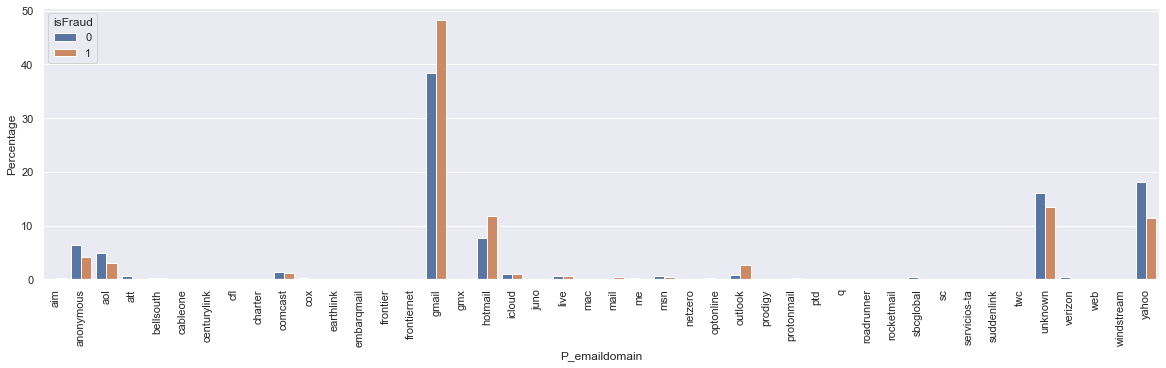

In [135]:
plt.figure(figsize=(20,5))

Email_group = (train_df.groupby(['isFraud'])['P_emaildomain'].value_counts(normalize=True).mul(100).rename('Percentage')
                       .reset_index().sort_values('P_emaildomain'))
sns.barplot(x="P_emaildomain", y="Percentage", hue="isFraud", data=Email_group)
plt.xticks(rotation=90)

plt.show()

Two of the most frequently used email domains - gmail and hotmail have a high percentage of fraud when compared to the others.

## Data Preparation for Modelling

In [136]:
#Let's look at the data types of all the columns

train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 202 columns):
 #   Column                Dtype  
---  ------                -----  
 0   isFraud               int8   
 1   TransactionAmt        float16
 2   ProductCD             object 
 3   card1                 float32
 4   card2                 float16
 5   card3                 float16
 6   card4                 object 
 7   card5                 float16
 8   card6                 object 
 9   addr1                 float16
 10  addr2                 float16
 11  P_emaildomain         object 
 12  C1                    float16
 13  C2                    float16
 14  C3                    float16
 15  C4                    float16
 16  C5                    float16
 17  C6                    float16
 18  C7                    float16
 19  C8                    float16
 20  C9                    float16
 21  C10                   float16
 22  C11                   float16
 23  C12     

In [137]:
categorical_columns

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'M6',
 'TransactionDay',
 'TransactionHour_Risk']

In [138]:
#Let's take a look at the values of the categorical columns

for i in categorical_columns:
    print(train_df[i].value_counts())
    print("\n")

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64


visa                384767
mastercard          189217
american express      8328
discover              6651
unknown               1577
Name: card4, dtype: int64


debit              439938
credit             148986
unknown              1571
debit or credit        30
charge card            15
Name: card6, dtype: int64


gmail           228851
yahoo           105305
unknown          94456
hotmail          46005
anonymous        36998
aol              28289
comcast           7888
icloud            6267
outlook           5534
msn               4092
att               4033
live              3846
sbcglobal         2970
verizon           2705
bellsouth         1909
me                1522
cox               1393
optonline         1011
charter            816
rocketmail         664
mail               559
earthlink          514
mac                436
netzero            426
juno               322
aim         

Let's use frequency encoding for the P_emaildomain column and one hot encoding for the other columns.

### Using frequency encoding for categorical variables

Using frequency encoding for the P_emaildomain column, as one hot encoding will create too many new columns.

Also, as we saw earlier, the most frequently used email domains have a high percentage of fraud. Therefore, using frequency encoding for such variables makes sense.

In [139]:
count_encoder = ce.CountEncoder(cols='P_emaildomain')

train_df['P_emaildomain'] = count_encoder.fit_transform(train_df['P_emaildomain'])

In [140]:
train_df.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay,TransactionHour_Risk
0,0,4.242188,W,9.541585,NaN,150.0,discover,142.0,credit,315.0,87.0,94456,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,1.0,0.000000,1.098633,0.0,0.693359,0.693359,14.0,NaN,13.0,0.0,T,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.693359,0.000000,0.0,0.0,0.0,0.000000,0.693359,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,4.770685,0.000000,0.0,0.000000,0.000000,0.000000,4.770685,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.693359,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,4.770685,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,4.770685,0.000000,0.0,0.0,0.0,1,high
1,0,3.400391,W,7.921535,404.0,150.0,mastercard,102.0,credit,325.0,87.0,228851,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,0.0,0.000000,0.693359,0.0,0.693359,0.693359,0.0,0.0,0.0,0.0,T,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,high
2,0,4.093750,W,8.447629,490.0,150.0,visa,166.0,debit,330.0,87.0,5534,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,1.0,0.000000,0.693359,0.0,0.693359,0.693359,0.0,0.0,0.0,315.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,high
3,0

In [141]:
#Encoding the same columns in the test set
test_df['P_emaildomain'] = count_encoder.transform(test_df['P_emaildomain'])

### Using One Hot Encoding for the other categorical columns

In [142]:
categorical_columns.remove('P_emaildomain')
categorical_columns

['ProductCD', 'card4', 'card6', 'M6', 'TransactionDay', 'TransactionHour_Risk']

In [143]:
#Creating an object of the OneHotEncoder class
enc = OneHotEncoder()

In [144]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels = enc.fit_transform(train_df[categorical_columns])


#Using the original column names to make the encoded columns easier to read

col_names = enc.get_feature_names(categorical_columns)

In [145]:
#Converting the encoded columns into a dataframe

encoded_columns = pd.DataFrame(onehotlabels.toarray().astype(int), columns = col_names)
encoded_columns.columns

Index(['ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_unknown', 'card4_visa', 'card6_charge card',
       'card6_credit', 'card6_debit', 'card6_debit or credit', 'card6_unknown',
       'M6_F', 'M6_T', 'M6_unknown', 'TransactionDay_0', 'TransactionDay_1',
       'TransactionDay_2', 'TransactionDay_3', 'TransactionDay_4',
       'TransactionDay_5', 'TransactionDay_6', 'TransactionHour_Risk_high',
       'TransactionHour_Risk_low', 'TransactionHour_Risk_medium'],
      dtype='object')

In [146]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns = encoded_columns.drop(['ProductCD_S', 'card4_unknown', 'card6_unknown', 'M6_unknown',
                                       'TransactionDay_4', 'TransactionHour_Risk_low'], axis =1)

In [147]:
print("Shape of encoded columns:\n", encoded_columns.shape)
print("\n")
print("Shape of original train set: \n", train_df.shape)

Shape of encoded columns:
 (590540, 22)


Shape of original train set: 
 (590540, 202)


Merging these encoded columns with the original dataframe

In [148]:
train_df = pd.concat([train_df, encoded_columns], axis = 1)

In [149]:
#Dropping the columns that have been encoded
train_df = train_df.drop(categorical_columns, axis = 1)

In [150]:
train_df.shape

(590540, 218)

### Splitting the dataframe into train and validation sets

In [151]:
#Splitting the data 70-30

X_train_xgb, X_val_xgb = train_test_split(train_df, train_size = 0.75, random_state = 100)

In [152]:
y_train_xgb = X_train_xgb['isFraud']
y_val_xgb = X_val_xgb['isFraud']
X_train_xgb = X_train_xgb.drop(['isFraud'], axis=1)
X_val_xgb = X_val_xgb.drop(['isFraud'], axis=1)

In [153]:
print(y_train_xgb.shape, type(y_train_xgb))
print(y_val_xgb.shape, type(y_val_xgb))
print(X_train_xgb.shape, type(X_train_xgb))
print(X_val_xgb.shape, type(X_val_xgb))

(442905,) <class 'pandas.core.series.Series'>
(147635,) <class 'pandas.core.series.Series'>
(442905, 217) <class 'pandas.core.frame.DataFrame'>
(147635, 217) <class 'pandas.core.frame.DataFrame'>


In [154]:
y_train_xgb = np.array(y_train_xgb)           #This is because GridSearch requires X to be a df or a np array, and y must be a numpy array of shape (n,)
y_val_xgb = np.array(y_val_xgb)
print(y_train_xgb.shape)

(442905,)


Before we start modelling, let's delete all the variables that are no longer needed.

In [155]:
#Checking the current user-defined variables

%who

Email_group	 GridSearchCV	 OneHotEncoder	 ProductCD_group	 STATUS_OK	 StratifiedKFold	 TransactionHour_Risk_Categorizer	 Trials	 XGBClassifier	 
X_train_xgb	 X_val_xgb	 a	 accuracy_score	 ax	 card4_group	 card6_group	 categorical_columns	 ce	 
check_col_zeros	 classification_report	 col_names	 cols_to_retain	 cols_transform	 confusion_matrix	 count_encoder	 cross_val_score	 dropped_columns	 
elapsed_time	 enc	 encoded_columns	 fig	 float_int_memory_reducer	 fmin	 gc	 hp	 hyperopt	 
i	 log_transform	 missing_values_df	 np	 onehotlabels	 path	 pd	 percentage	 percentage_1	 
plt	 re	 roc_auc_score	 sns	 start_process_time	 test_df	 time	 tpe	 train_df	 
train_df_backup_2	 train_test_split	 warnings	 y_train_xgb	 y_val_xgb	 


In [156]:
#Let's delete all the unnecessary variables

del (Email_group, ProductCD_group, a, ax, card4_group, card6_group, cols_to_retain, cols_transform, dropped_columns,      
     fig, missing_values_df, percentage, percentage_1, train_df_backup_2)

In [157]:
#Triggering garbage collection

gc.collect()

63974

Since LGBM is a tree-type classifier, we don't need to perform feature scaling. Let's proceed to the model building phase.

## Modelling using XGBoost

Using hyperopt to tune the hyperparameters for XGBoost

https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9

In [158]:
#Initializing a required range or space

space = {'max_depth': hp.quniform('max_depth', 4, 16, 2),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'n_estimators': hp.quniform('n_estimators', 50, 200, 25),
         'reg_alpha': hp.uniform('reg_alpha', 0, 0.1),
         'reg_lambda': hp.uniform('reg_lambda', 0, 0.1),
         'gamma': hp.quniform('gamma', 0, 0.5, 0.1)
}

In [159]:
def hyperparameter_tuning(space):
    
    model = XGBClassifier(max_depth = int(space['max_depth']), min_child_weight = int(space['min_child_weight']), 
                         n_estimators = int(space['n_estimators']), reg_alpha = int(space['reg_alpha']), 
                          reg_lambda = int(space['reg_lambda']), gamma = int(space['gamma']))
    
    evaluation_data = [(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)]
    
    model.fit(X_train_xgb, y_train_xgb, eval_set = evaluation_data, eval_metric = "auc", verbose = True)
    
    pred = model.predict(X_val_xgb)
    area_under_curve = roc_auc_score(y_val_xgb, pred)
    print("Validation AUC: ", area_under_curve)
    
    return {'loss': 1-area_under_curve, 'status': STATUS_OK, 'model': model}

In [160]:
trials = Trials()

best = fmin(fn = hyperparameter_tuning, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)

print(best)

[0]	validation_0-auc:0.79075	validation_1-auc:0.79007                                                                  

[1]	validation_0-auc:0.81847	validation_1-auc:0.81508                                                                  

[2]	validation_0-auc:0.83882	validation_1-auc:0.83728                                                                  

[3]	validation_0-auc:0.84864	validation_1-auc:0.84791                                                                  

[4]	validation_0-auc:0.85831	validation_1-auc:0.85859                                                                  

[5]	validation_0-auc:0.86207	validation_1-auc:0.86220                                                                  

[6]	validation_0-auc:0.86990	validation_1-auc:0.86699                                                                  

[7]	validation_0-auc:0.87340	validation_1-auc:0.87037                                                                  

[8]	validation_0-auc:0.87779	val

[67]	validation_0-auc:0.94089	validation_1-auc:0.92761                                                                 

[68]	validation_0-auc:0.94149	validation_1-auc:0.92822                                                                 

[69]	validation_0-auc:0.94159	validation_1-auc:0.92825                                                                 

[70]	validation_0-auc:0.94196	validation_1-auc:0.92855                                                                 

[71]	validation_0-auc:0.94318	validation_1-auc:0.92935                                                                 

[72]	validation_0-auc:0.94357	validation_1-auc:0.92969                                                                 

[73]	validation_0-auc:0.94369	validation_1-auc:0.92981                                                                 

[74]	validation_0-auc:0.94389	validation_1-auc:0.92997                                                                 

[75]	validation_0-auc:0.94434	va

[32]	validation_0-auc:0.97116	validation_1-auc:0.94727                                                                 

[33]	validation_0-auc:0.97143	validation_1-auc:0.94733                                                                 

[34]	validation_0-auc:0.97209	validation_1-auc:0.94786                                                                 

[35]	validation_0-auc:0.97279	validation_1-auc:0.94857                                                                 

[36]	validation_0-auc:0.97315	validation_1-auc:0.94882                                                                 

[37]	validation_0-auc:0.97326	validation_1-auc:0.94890                                                                 

[38]	validation_0-auc:0.97389	validation_1-auc:0.94918                                                                 

[39]	validation_0-auc:0.97399	validation_1-auc:0.94922                                                                 

[40]	validation_0-auc:0.97415	va

[99]	validation_0-auc:0.98814	validation_1-auc:0.96012                                                                 

[100]	validation_0-auc:0.98836	validation_1-auc:0.96036                                                                

[101]	validation_0-auc:0.98850	validation_1-auc:0.96071                                                                

[102]	validation_0-auc:0.98869	validation_1-auc:0.96086                                                                

[103]	validation_0-auc:0.98893	validation_1-auc:0.96129                                                                

[104]	validation_0-auc:0.98900	validation_1-auc:0.96139                                                                

[105]	validation_0-auc:0.98903	validation_1-auc:0.96143                                                                

[106]	validation_0-auc:0.98915	validation_1-auc:0.96149                                                                

[107]	validation_0-auc:0.98930	v

[166]	validation_0-auc:0.99455	validation_1-auc:0.96511                                                                

[167]	validation_0-auc:0.99456	validation_1-auc:0.96513                                                                

[168]	validation_0-auc:0.99469	validation_1-auc:0.96513                                                                

[169]	validation_0-auc:0.99469	validation_1-auc:0.96513                                                                

[170]	validation_0-auc:0.99471	validation_1-auc:0.96512                                                                

[171]	validation_0-auc:0.99472	validation_1-auc:0.96514                                                                

[172]	validation_0-auc:0.99474	validation_1-auc:0.96514                                                                

[173]	validation_0-auc:0.99475	validation_1-auc:0.96511                                                                

[174]	validation_0-auc:0.99475	v

[56]	validation_0-auc:0.97240	validation_1-auc:0.94976                                                                 

[57]	validation_0-auc:0.97278	validation_1-auc:0.94995                                                                 

[58]	validation_0-auc:0.97300	validation_1-auc:0.95014                                                                 

[59]	validation_0-auc:0.97350	validation_1-auc:0.95053                                                                 

[60]	validation_0-auc:0.97368	validation_1-auc:0.95070                                                                 

[61]	validation_0-auc:0.97393	validation_1-auc:0.95085                                                                 

[62]	validation_0-auc:0.97398	validation_1-auc:0.95086                                                                 

[63]	validation_0-auc:0.97415	validation_1-auc:0.95093                                                                 

[64]	validation_0-auc:0.97420	va

[46]	validation_0-auc:0.95271	validation_1-auc:0.93700                                                                 

[47]	validation_0-auc:0.95287	validation_1-auc:0.93714                                                                 

[48]	validation_0-auc:0.95299	validation_1-auc:0.93715                                                                 

[49]	validation_0-auc:0.95361	validation_1-auc:0.93762                                                                 

[50]	validation_0-auc:0.95394	validation_1-auc:0.93788                                                                 

[51]	validation_0-auc:0.95441	validation_1-auc:0.93822                                                                 

[52]	validation_0-auc:0.95498	validation_1-auc:0.93856                                                                 

[53]	validation_0-auc:0.95517	validation_1-auc:0.93856                                                                 

[54]	validation_0-auc:0.95583	va

[36]	validation_0-auc:0.98827	validation_1-auc:0.95734                                                                 

[37]	validation_0-auc:0.98862	validation_1-auc:0.95747                                                                 

[38]	validation_0-auc:0.98905	validation_1-auc:0.95764                                                                 

[39]	validation_0-auc:0.98940	validation_1-auc:0.95807                                                                 

[40]	validation_0-auc:0.98952	validation_1-auc:0.95810                                                                 

[41]	validation_0-auc:0.98963	validation_1-auc:0.95822                                                                 

[42]	validation_0-auc:0.98968	validation_1-auc:0.95822                                                                 

[43]	validation_0-auc:0.98970	validation_1-auc:0.95826                                                                 

[44]	validation_0-auc:0.99045	va

[1]	validation_0-auc:0.88111	validation_1-auc:0.87414                                                                  

[2]	validation_0-auc:0.88543	validation_1-auc:0.87829                                                                  

[3]	validation_0-auc:0.89210	validation_1-auc:0.88241                                                                  

[4]	validation_0-auc:0.90457	validation_1-auc:0.89160                                                                  

[5]	validation_0-auc:0.91096	validation_1-auc:0.89676                                                                  

[6]	validation_0-auc:0.91622	validation_1-auc:0.90042                                                                  

[7]	validation_0-auc:0.92268	validation_1-auc:0.90468                                                                  

[8]	validation_0-auc:0.92811	validation_1-auc:0.90897                                                                  

[9]	validation_0-auc:0.93580	val

[68]	validation_0-auc:0.98644	validation_1-auc:0.95797                                                                 

[69]	validation_0-auc:0.98650	validation_1-auc:0.95803                                                                 

[70]	validation_0-auc:0.98690	validation_1-auc:0.95830                                                                 

[71]	validation_0-auc:0.98739	validation_1-auc:0.95877                                                                 

[72]	validation_0-auc:0.98755	validation_1-auc:0.95884                                                                 

[73]	validation_0-auc:0.98766	validation_1-auc:0.95882                                                                 

[74]	validation_0-auc:0.98771	validation_1-auc:0.95898                                                                 

[75]	validation_0-auc:0.98774	validation_1-auc:0.95895                                                                 

[76]	validation_0-auc:0.98787	va

[135]	validation_0-auc:0.99327	validation_1-auc:0.96338                                                                

[136]	validation_0-auc:0.99342	validation_1-auc:0.96356                                                                

[137]	validation_0-auc:0.99347	validation_1-auc:0.96371                                                                

[138]	validation_0-auc:0.99350	validation_1-auc:0.96369                                                                

[139]	validation_0-auc:0.99360	validation_1-auc:0.96373                                                                

[140]	validation_0-auc:0.99363	validation_1-auc:0.96378                                                                

[141]	validation_0-auc:0.99364	validation_1-auc:0.96379                                                                

[142]	validation_0-auc:0.99366	validation_1-auc:0.96379                                                                

[143]	validation_0-auc:0.99367	v

[25]	validation_0-auc:0.91878	validation_1-auc:0.91263                                                                 

[26]	validation_0-auc:0.91927	validation_1-auc:0.91307                                                                 

[27]	validation_0-auc:0.91958	validation_1-auc:0.91340                                                                 

[28]	validation_0-auc:0.92156	validation_1-auc:0.91517                                                                 

[29]	validation_0-auc:0.92262	validation_1-auc:0.91588                                                                 

[30]	validation_0-auc:0.92290	validation_1-auc:0.91591                                                                 

[31]	validation_0-auc:0.92332	validation_1-auc:0.91616                                                                 

[32]	validation_0-auc:0.92413	validation_1-auc:0.91669                                                                 

[33]	validation_0-auc:0.92444	va

[40]	validation_0-auc:0.98952	validation_1-auc:0.95810                                                                 

[41]	validation_0-auc:0.98963	validation_1-auc:0.95822                                                                 

[42]	validation_0-auc:0.98968	validation_1-auc:0.95822                                                                 

[43]	validation_0-auc:0.98970	validation_1-auc:0.95826                                                                 

[44]	validation_0-auc:0.99045	validation_1-auc:0.95889                                                                 

[45]	validation_0-auc:0.99058	validation_1-auc:0.95905                                                                 

[46]	validation_0-auc:0.99077	validation_1-auc:0.95931                                                                 

[47]	validation_0-auc:0.99112	validation_1-auc:0.95982                                                                 

[48]	validation_0-auc:0.99135	va

[30]	validation_0-auc:0.98084	validation_1-auc:0.95183                                                                 

[31]	validation_0-auc:0.98113	validation_1-auc:0.95199                                                                 

[32]	validation_0-auc:0.98172	validation_1-auc:0.95276                                                                 

[33]	validation_0-auc:0.98201	validation_1-auc:0.95306                                                                 

[34]	validation_0-auc:0.98224	validation_1-auc:0.95323                                                                 

[35]	validation_0-auc:0.98313	validation_1-auc:0.95441                                                                 

[36]	validation_0-auc:0.98360	validation_1-auc:0.95494                                                                 

[37]	validation_0-auc:0.98419	validation_1-auc:0.95534                                                                 

[38]	validation_0-auc:0.98433	va

[97]	validation_0-auc:0.99292	validation_1-auc:0.96269                                                                 

[98]	validation_0-auc:0.99311	validation_1-auc:0.96287                                                                 

[99]	validation_0-auc:0.99315	validation_1-auc:0.96286                                                                 

[100]	validation_0-auc:0.99350	validation_1-auc:0.96309                                                                

[101]	validation_0-auc:0.99351	validation_1-auc:0.96308                                                                

[102]	validation_0-auc:0.99360	validation_1-auc:0.96332                                                                

[103]	validation_0-auc:0.99374	validation_1-auc:0.96325                                                                

[104]	validation_0-auc:0.99383	validation_1-auc:0.96319                                                                

[105]	validation_0-auc:0.99394	v

[164]	validation_0-auc:0.99669	validation_1-auc:0.96514                                                                

[165]	validation_0-auc:0.99670	validation_1-auc:0.96514                                                                

[166]	validation_0-auc:0.99681	validation_1-auc:0.96535                                                                

[167]	validation_0-auc:0.99683	validation_1-auc:0.96535                                                                

[168]	validation_0-auc:0.99685	validation_1-auc:0.96534                                                                

[169]	validation_0-auc:0.99686	validation_1-auc:0.96529                                                                

[170]	validation_0-auc:0.99687	validation_1-auc:0.96527                                                                

[171]	validation_0-auc:0.99689	validation_1-auc:0.96527                                                                

[172]	validation_0-auc:0.99699	v

[54]	validation_0-auc:0.90929	validation_1-auc:0.90499                                                                 

[55]	validation_0-auc:0.90939	validation_1-auc:0.90499                                                                 

[56]	validation_0-auc:0.90976	validation_1-auc:0.90529                                                                 

[57]	validation_0-auc:0.91043	validation_1-auc:0.90587                                                                 

[58]	validation_0-auc:0.91057	validation_1-auc:0.90599                                                                 

[59]	validation_0-auc:0.91095	validation_1-auc:0.90639                                                                 

[60]	validation_0-auc:0.91154	validation_1-auc:0.90707                                                                 

[61]	validation_0-auc:0.91177	validation_1-auc:0.90724                                                                 

[62]	validation_0-auc:0.91212	va

[121]	validation_0-auc:0.92769	validation_1-auc:0.91994                                                                

[122]	validation_0-auc:0.92768	validation_1-auc:0.91992                                                                

[123]	validation_0-auc:0.92785	validation_1-auc:0.91998                                                                

[124]	validation_0-auc:0.92788	validation_1-auc:0.91998                                                                

[125]	validation_0-auc:0.92794	validation_1-auc:0.92001                                                                

[126]	validation_0-auc:0.92809	validation_1-auc:0.92020                                                                

[127]	validation_0-auc:0.92809	validation_1-auc:0.92019                                                                

[128]	validation_0-auc:0.92815	validation_1-auc:0.92026                                                                

[129]	validation_0-auc:0.92817	v

[188]	validation_0-auc:0.93865	validation_1-auc:0.92799                                                                

[189]	validation_0-auc:0.93898	validation_1-auc:0.92832                                                                

[190]	validation_0-auc:0.93932	validation_1-auc:0.92871                                                                

[191]	validation_0-auc:0.93942	validation_1-auc:0.92879                                                                

[192]	validation_0-auc:0.93948	validation_1-auc:0.92882                                                                

[193]	validation_0-auc:0.93957	validation_1-auc:0.92888                                                                

[194]	validation_0-auc:0.93960	validation_1-auc:0.92894                                                                

[195]	validation_0-auc:0.93969	validation_1-auc:0.92903                                                                

[196]	validation_0-auc:0.93973	v

[53]	validation_0-auc:0.98277	validation_1-auc:0.95517                                                                 

[54]	validation_0-auc:0.98310	validation_1-auc:0.95544                                                                 

[55]	validation_0-auc:0.98350	validation_1-auc:0.95556                                                                 

[56]	validation_0-auc:0.98390	validation_1-auc:0.95586                                                                 

[57]	validation_0-auc:0.98403	validation_1-auc:0.95588                                                                 

[58]	validation_0-auc:0.98438	validation_1-auc:0.95627                                                                 

[59]	validation_0-auc:0.98456	validation_1-auc:0.95657                                                                 

[60]	validation_0-auc:0.98486	validation_1-auc:0.95687                                                                 

[61]	validation_0-auc:0.98499	va

[120]	validation_0-auc:0.99213	validation_1-auc:0.96286                                                                

[121]	validation_0-auc:0.99227	validation_1-auc:0.96291                                                                

[122]	validation_0-auc:0.99237	validation_1-auc:0.96299                                                                

[123]	validation_0-auc:0.99241	validation_1-auc:0.96298                                                                

[124]	validation_0-auc:0.99254	validation_1-auc:0.96304                                                                

Validation AUC:                                                                                                        
0.7971268843561029                                                                                                     
[0]	validation_0-auc:0.85332	validation_1-auc:0.85011                                                                  

[1]	validation_0-auc:0.86706	valid

[60]	validation_0-auc:0.97471	validation_1-auc:0.95081                                                                 

[61]	validation_0-auc:0.97501	validation_1-auc:0.95083                                                                 

[62]	validation_0-auc:0.97522	validation_1-auc:0.95093                                                                 

[63]	validation_0-auc:0.97535	validation_1-auc:0.95080                                                                 

[64]	validation_0-auc:0.97538	validation_1-auc:0.95083                                                                 

[65]	validation_0-auc:0.97572	validation_1-auc:0.95122                                                                 

[66]	validation_0-auc:0.97597	validation_1-auc:0.95132                                                                 

[67]	validation_0-auc:0.97619	validation_1-auc:0.95148                                                                 

[68]	validation_0-auc:0.97648	va

[127]	validation_0-auc:0.98592	validation_1-auc:0.95913                                                                

[128]	validation_0-auc:0.98609	validation_1-auc:0.95920                                                                

[129]	validation_0-auc:0.98618	validation_1-auc:0.95926                                                                

[130]	validation_0-auc:0.98627	validation_1-auc:0.95933                                                                

[131]	validation_0-auc:0.98650	validation_1-auc:0.95947                                                                

[132]	validation_0-auc:0.98661	validation_1-auc:0.95944                                                                

[133]	validation_0-auc:0.98668	validation_1-auc:0.95956                                                                

[134]	validation_0-auc:0.98672	validation_1-auc:0.95959                                                                

[135]	validation_0-auc:0.98677	v

[17]	validation_0-auc:0.96835	validation_1-auc:0.94105                                                                 

[18]	validation_0-auc:0.97030	validation_1-auc:0.94311                                                                 

[19]	validation_0-auc:0.97206	validation_1-auc:0.94427                                                                 

[20]	validation_0-auc:0.97319	validation_1-auc:0.94538                                                                 

[21]	validation_0-auc:0.97415	validation_1-auc:0.94614                                                                 

[22]	validation_0-auc:0.97506	validation_1-auc:0.94689                                                                 

[23]	validation_0-auc:0.97553	validation_1-auc:0.94785                                                                 

[24]	validation_0-auc:0.97619	validation_1-auc:0.94876                                                                 

[25]	validation_0-auc:0.97671	va

[7]	validation_0-auc:0.89346	validation_1-auc:0.88746                                                                  

[8]	validation_0-auc:0.89595	validation_1-auc:0.88936                                                                  

[9]	validation_0-auc:0.90084	validation_1-auc:0.89309                                                                  

[10]	validation_0-auc:0.90465	validation_1-auc:0.89538                                                                 

[11]	validation_0-auc:0.90765	validation_1-auc:0.89849                                                                 

[12]	validation_0-auc:0.91228	validation_1-auc:0.90230                                                                 

[13]	validation_0-auc:0.91778	validation_1-auc:0.90630                                                                 

[14]	validation_0-auc:0.92237	validation_1-auc:0.91024                                                                 

[15]	validation_0-auc:0.92608	va

[74]	validation_0-auc:0.96533	validation_1-auc:0.94614                                                                 

[75]	validation_0-auc:0.96553	validation_1-auc:0.94622                                                                 

[76]	validation_0-auc:0.96590	validation_1-auc:0.94654                                                                 

[77]	validation_0-auc:0.96612	validation_1-auc:0.94669                                                                 

[78]	validation_0-auc:0.96642	validation_1-auc:0.94680                                                                 

[79]	validation_0-auc:0.96651	validation_1-auc:0.94678                                                                 

[80]	validation_0-auc:0.96671	validation_1-auc:0.94704                                                                 

[81]	validation_0-auc:0.96724	validation_1-auc:0.94753                                                                 

[82]	validation_0-auc:0.96773	va

[141]	validation_0-auc:0.97772	validation_1-auc:0.95499                                                                

[142]	validation_0-auc:0.97780	validation_1-auc:0.95505                                                                

[143]	validation_0-auc:0.97785	validation_1-auc:0.95505                                                                

[144]	validation_0-auc:0.97789	validation_1-auc:0.95513                                                                

[145]	validation_0-auc:0.97792	validation_1-auc:0.95513                                                                

[146]	validation_0-auc:0.97817	validation_1-auc:0.95531                                                                

[147]	validation_0-auc:0.97820	validation_1-auc:0.95531                                                                

[148]	validation_0-auc:0.97851	validation_1-auc:0.95540                                                                

[149]	validation_0-auc:0.97861	v

[56]	validation_0-auc:0.98913	validation_1-auc:0.96033                                                                 

[57]	validation_0-auc:0.98923	validation_1-auc:0.96045                                                                 

[58]	validation_0-auc:0.98938	validation_1-auc:0.96050                                                                 

[59]	validation_0-auc:0.98958	validation_1-auc:0.96061                                                                 

[60]	validation_0-auc:0.98981	validation_1-auc:0.96112                                                                 

[61]	validation_0-auc:0.98992	validation_1-auc:0.96118                                                                 

[62]	validation_0-auc:0.99019	validation_1-auc:0.96147                                                                 

[63]	validation_0-auc:0.99029	validation_1-auc:0.96152                                                                 

[64]	validation_0-auc:0.99069	va

[123]	validation_0-auc:0.99652	validation_1-auc:0.96652                                                                

[124]	validation_0-auc:0.99656	validation_1-auc:0.96655                                                                

[125]	validation_0-auc:0.99660	validation_1-auc:0.96654                                                                

[126]	validation_0-auc:0.99662	validation_1-auc:0.96655                                                                

[127]	validation_0-auc:0.99665	validation_1-auc:0.96665                                                                

[128]	validation_0-auc:0.99689	validation_1-auc:0.96642                                                                

[129]	validation_0-auc:0.99695	validation_1-auc:0.96644                                                                

[130]	validation_0-auc:0.99700	validation_1-auc:0.96636                                                                

[131]	validation_0-auc:0.99703	v

[190]	validation_0-auc:0.99838	validation_1-auc:0.96661                                                                

[191]	validation_0-auc:0.99838	validation_1-auc:0.96664                                                                

[192]	validation_0-auc:0.99838	validation_1-auc:0.96664                                                                

[193]	validation_0-auc:0.99839	validation_1-auc:0.96667                                                                

[194]	validation_0-auc:0.99840	validation_1-auc:0.96665                                                                

[195]	validation_0-auc:0.99842	validation_1-auc:0.96667                                                                

[196]	validation_0-auc:0.99851	validation_1-auc:0.96670                                                                

[197]	validation_0-auc:0.99852	validation_1-auc:0.96666                                                                

[198]	validation_0-auc:0.99852	v

[55]	validation_0-auc:0.98186	validation_1-auc:0.95447                                                                 

[56]	validation_0-auc:0.98216	validation_1-auc:0.95486                                                                 

[57]	validation_0-auc:0.98268	validation_1-auc:0.95517                                                                 

[58]	validation_0-auc:0.98310	validation_1-auc:0.95564                                                                 

[59]	validation_0-auc:0.98345	validation_1-auc:0.95601                                                                 

[60]	validation_0-auc:0.98358	validation_1-auc:0.95600                                                                 

[61]	validation_0-auc:0.98381	validation_1-auc:0.95611                                                                 

[62]	validation_0-auc:0.98423	validation_1-auc:0.95651                                                                 

[63]	validation_0-auc:0.98475	va

[122]	validation_0-auc:0.99290	validation_1-auc:0.96254                                                                

[123]	validation_0-auc:0.99293	validation_1-auc:0.96257                                                                

[124]	validation_0-auc:0.99294	validation_1-auc:0.96259                                                                

[125]	validation_0-auc:0.99315	validation_1-auc:0.96285                                                                

[126]	validation_0-auc:0.99319	validation_1-auc:0.96288                                                                

[127]	validation_0-auc:0.99325	validation_1-auc:0.96297                                                                

[128]	validation_0-auc:0.99328	validation_1-auc:0.96304                                                                

[129]	validation_0-auc:0.99338	validation_1-auc:0.96312                                                                

[130]	validation_0-auc:0.99339	v

[189]	validation_0-auc:0.99678	validation_1-auc:0.96543                                                                

[190]	validation_0-auc:0.99680	validation_1-auc:0.96546                                                                

[191]	validation_0-auc:0.99684	validation_1-auc:0.96543                                                                

[192]	validation_0-auc:0.99686	validation_1-auc:0.96543                                                                

[193]	validation_0-auc:0.99688	validation_1-auc:0.96537                                                                

[194]	validation_0-auc:0.99689	validation_1-auc:0.96535                                                                

[195]	validation_0-auc:0.99693	validation_1-auc:0.96525                                                                

[196]	validation_0-auc:0.99695	validation_1-auc:0.96529                                                                

[197]	validation_0-auc:0.99698	v

[54]	validation_0-auc:0.97223	validation_1-auc:0.94966                                                                 

[55]	validation_0-auc:0.97234	validation_1-auc:0.94971                                                                 

[56]	validation_0-auc:0.97240	validation_1-auc:0.94976                                                                 

[57]	validation_0-auc:0.97278	validation_1-auc:0.94995                                                                 

[58]	validation_0-auc:0.97300	validation_1-auc:0.95014                                                                 

[59]	validation_0-auc:0.97350	validation_1-auc:0.95053                                                                 

[60]	validation_0-auc:0.97368	validation_1-auc:0.95070                                                                 

[61]	validation_0-auc:0.97393	validation_1-auc:0.95085                                                                 

[62]	validation_0-auc:0.97398	va

[121]	validation_0-auc:0.98390	validation_1-auc:0.95797                                                                

[122]	validation_0-auc:0.98395	validation_1-auc:0.95799                                                                

[123]	validation_0-auc:0.98411	validation_1-auc:0.95804                                                                

[124]	validation_0-auc:0.98416	validation_1-auc:0.95816                                                                

Validation AUC:                                                                                                        
0.785831154974366                                                                                                      
[0]	validation_0-auc:0.88219	validation_1-auc:0.85345                                                                  

[1]	validation_0-auc:0.89268	validation_1-auc:0.87614                                                                  

[2]	validation_0-auc:0.89933	valid

[61]	validation_0-auc:0.99756	validation_1-auc:0.96277                                                                 

[62]	validation_0-auc:0.99760	validation_1-auc:0.96278                                                                 

[63]	validation_0-auc:0.99765	validation_1-auc:0.96307                                                                 

[64]	validation_0-auc:0.99770	validation_1-auc:0.96320                                                                 

[65]	validation_0-auc:0.99773	validation_1-auc:0.96325                                                                 

[66]	validation_0-auc:0.99781	validation_1-auc:0.96346                                                                 

[67]	validation_0-auc:0.99785	validation_1-auc:0.96347                                                                 

[68]	validation_0-auc:0.99788	validation_1-auc:0.96344                                                                 

[69]	validation_0-auc:0.99790	va

[51]	validation_0-auc:0.98684	validation_1-auc:0.95710                                                                 

[52]	validation_0-auc:0.98691	validation_1-auc:0.95722                                                                 

[53]	validation_0-auc:0.98699	validation_1-auc:0.95733                                                                 

[54]	validation_0-auc:0.98719	validation_1-auc:0.95744                                                                 

[55]	validation_0-auc:0.98734	validation_1-auc:0.95758                                                                 

[56]	validation_0-auc:0.98768	validation_1-auc:0.95806                                                                 

[57]	validation_0-auc:0.98812	validation_1-auc:0.95867                                                                 

[58]	validation_0-auc:0.98826	validation_1-auc:0.95888                                                                 

[59]	validation_0-auc:0.98855	va

[118]	validation_0-auc:0.99576	validation_1-auc:0.96382                                                                

[119]	validation_0-auc:0.99584	validation_1-auc:0.96386                                                                

[120]	validation_0-auc:0.99589	validation_1-auc:0.96393                                                                

[121]	validation_0-auc:0.99594	validation_1-auc:0.96394                                                                

[122]	validation_0-auc:0.99605	validation_1-auc:0.96403                                                                

[123]	validation_0-auc:0.99608	validation_1-auc:0.96415                                                                

[124]	validation_0-auc:0.99611	validation_1-auc:0.96419                                                                

Validation AUC:                                                                                                        
0.8011893492891843               

[58]	validation_0-auc:0.99453	validation_1-auc:0.96029                                                                 

[59]	validation_0-auc:0.99467	validation_1-auc:0.96049                                                                 

[60]	validation_0-auc:0.99467	validation_1-auc:0.96050                                                                 

[61]	validation_0-auc:0.99471	validation_1-auc:0.96054                                                                 

[62]	validation_0-auc:0.99474	validation_1-auc:0.96056                                                                 

[63]	validation_0-auc:0.99483	validation_1-auc:0.96058                                                                 

[64]	validation_0-auc:0.99486	validation_1-auc:0.96062                                                                 

[65]	validation_0-auc:0.99501	validation_1-auc:0.96075                                                                 

[66]	validation_0-auc:0.99508	va

[23]	validation_0-auc:0.95137	validation_1-auc:0.93224                                                                 

[24]	validation_0-auc:0.95304	validation_1-auc:0.93361                                                                 

[25]	validation_0-auc:0.95383	validation_1-auc:0.93404                                                                 

[26]	validation_0-auc:0.95494	validation_1-auc:0.93482                                                                 

[27]	validation_0-auc:0.95576	validation_1-auc:0.93558                                                                 

[28]	validation_0-auc:0.95661	validation_1-auc:0.93623                                                                 

[29]	validation_0-auc:0.95696	validation_1-auc:0.93655                                                                 

[30]	validation_0-auc:0.95758	validation_1-auc:0.93680                                                                 

[31]	validation_0-auc:0.95784	va

[90]	validation_0-auc:0.97939	validation_1-auc:0.95303                                                                 

[91]	validation_0-auc:0.97968	validation_1-auc:0.95309                                                                 

[92]	validation_0-auc:0.97996	validation_1-auc:0.95318                                                                 

[93]	validation_0-auc:0.98020	validation_1-auc:0.95344                                                                 

[94]	validation_0-auc:0.98040	validation_1-auc:0.95369                                                                 

[95]	validation_0-auc:0.98048	validation_1-auc:0.95374                                                                 

[96]	validation_0-auc:0.98091	validation_1-auc:0.95385                                                                 

[97]	validation_0-auc:0.98094	validation_1-auc:0.95389                                                                 

[98]	validation_0-auc:0.98097	va

[157]	validation_0-auc:0.98909	validation_1-auc:0.95937                                                                

[158]	validation_0-auc:0.98930	validation_1-auc:0.95945                                                                

[159]	validation_0-auc:0.98944	validation_1-auc:0.95969                                                                

[160]	validation_0-auc:0.98960	validation_1-auc:0.95983                                                                

[161]	validation_0-auc:0.98986	validation_1-auc:0.96008                                                                

[162]	validation_0-auc:0.98991	validation_1-auc:0.96006                                                                

[163]	validation_0-auc:0.98997	validation_1-auc:0.96012                                                                

[164]	validation_0-auc:0.99001	validation_1-auc:0.96013                                                                

[165]	validation_0-auc:0.99005	v

[22]	validation_0-auc:0.99285	validation_1-auc:0.95743                                                                 

[23]	validation_0-auc:0.99303	validation_1-auc:0.95790                                                                 

[24]	validation_0-auc:0.99323	validation_1-auc:0.95826                                                                 

[25]	validation_0-auc:0.99369	validation_1-auc:0.95882                                                                 

[26]	validation_0-auc:0.99390	validation_1-auc:0.95927                                                                 

[27]	validation_0-auc:0.99432	validation_1-auc:0.95966                                                                 

[28]	validation_0-auc:0.99455	validation_1-auc:0.96018                                                                 

[29]	validation_0-auc:0.99468	validation_1-auc:0.96026                                                                 

[30]	validation_0-auc:0.99485	va

[89]	validation_0-auc:0.99896	validation_1-auc:0.96496                                                                 

[90]	validation_0-auc:0.99897	validation_1-auc:0.96492                                                                 

[91]	validation_0-auc:0.99898	validation_1-auc:0.96493                                                                 

[92]	validation_0-auc:0.99898	validation_1-auc:0.96493                                                                 

[93]	validation_0-auc:0.99900	validation_1-auc:0.96493                                                                 

[94]	validation_0-auc:0.99901	validation_1-auc:0.96499                                                                 

[95]	validation_0-auc:0.99903	validation_1-auc:0.96491                                                                 

[96]	validation_0-auc:0.99913	validation_1-auc:0.96491                                                                 

[97]	validation_0-auc:0.99917	va

[156]	validation_0-auc:0.99985	validation_1-auc:0.96485                                                                

[157]	validation_0-auc:0.99985	validation_1-auc:0.96477                                                                

[158]	validation_0-auc:0.99986	validation_1-auc:0.96485                                                                

[159]	validation_0-auc:0.99986	validation_1-auc:0.96483                                                                

[160]	validation_0-auc:0.99987	validation_1-auc:0.96476                                                                

[161]	validation_0-auc:0.99987	validation_1-auc:0.96478                                                                

[162]	validation_0-auc:0.99987	validation_1-auc:0.96479                                                                

[163]	validation_0-auc:0.99987	validation_1-auc:0.96480                                                                

[164]	validation_0-auc:0.99987	v

[21]	validation_0-auc:0.98721	validation_1-auc:0.95283                                                                 

[22]	validation_0-auc:0.98786	validation_1-auc:0.95331                                                                 

[23]	validation_0-auc:0.98818	validation_1-auc:0.95398                                                                 

[24]	validation_0-auc:0.98865	validation_1-auc:0.95450                                                                 

[25]	validation_0-auc:0.98942	validation_1-auc:0.95501                                                                 

[26]	validation_0-auc:0.98964	validation_1-auc:0.95531                                                                 

[27]	validation_0-auc:0.99013	validation_1-auc:0.95581                                                                 

[28]	validation_0-auc:0.99025	validation_1-auc:0.95610                                                                 

[29]	validation_0-auc:0.99047	va

[88]	validation_0-auc:0.99743	validation_1-auc:0.96386                                                                 

[89]	validation_0-auc:0.99745	validation_1-auc:0.96385                                                                 

[90]	validation_0-auc:0.99746	validation_1-auc:0.96384                                                                 

[91]	validation_0-auc:0.99747	validation_1-auc:0.96386                                                                 

[92]	validation_0-auc:0.99752	validation_1-auc:0.96415                                                                 

[93]	validation_0-auc:0.99755	validation_1-auc:0.96425                                                                 

[94]	validation_0-auc:0.99768	validation_1-auc:0.96420                                                                 

[95]	validation_0-auc:0.99769	validation_1-auc:0.96424                                                                 

[96]	validation_0-auc:0.99770	va

[3]	validation_0-auc:0.91956	validation_1-auc:0.89582                                                                  

[4]	validation_0-auc:0.93761	validation_1-auc:0.90636                                                                  

[5]	validation_0-auc:0.94388	validation_1-auc:0.91150                                                                  

[6]	validation_0-auc:0.95019	validation_1-auc:0.91414                                                                  

[7]	validation_0-auc:0.95616	validation_1-auc:0.91980                                                                  

[8]	validation_0-auc:0.96018	validation_1-auc:0.92442                                                                  

[9]	validation_0-auc:0.96403	validation_1-auc:0.92797                                                                  

[10]	validation_0-auc:0.96740	validation_1-auc:0.93051                                                                 

[11]	validation_0-auc:0.97224	va

[70]	validation_0-auc:0.99805	validation_1-auc:0.96377                                                                 

[71]	validation_0-auc:0.99814	validation_1-auc:0.96409                                                                 

[72]	validation_0-auc:0.99818	validation_1-auc:0.96415                                                                 

[73]	validation_0-auc:0.99819	validation_1-auc:0.96430                                                                 

[74]	validation_0-auc:0.99819	validation_1-auc:0.96435                                                                 

[75]	validation_0-auc:0.99821	validation_1-auc:0.96439                                                                 

[76]	validation_0-auc:0.99827	validation_1-auc:0.96443                                                                 

[77]	validation_0-auc:0.99831	validation_1-auc:0.96459                                                                 

[78]	validation_0-auc:0.99839	va

[137]	validation_0-auc:0.99972	validation_1-auc:0.96467                                                                

[138]	validation_0-auc:0.99973	validation_1-auc:0.96465                                                                

[139]	validation_0-auc:0.99974	validation_1-auc:0.96469                                                                

[140]	validation_0-auc:0.99976	validation_1-auc:0.96478                                                                

[141]	validation_0-auc:0.99977	validation_1-auc:0.96470                                                                

[142]	validation_0-auc:0.99977	validation_1-auc:0.96466                                                                

[143]	validation_0-auc:0.99977	validation_1-auc:0.96469                                                                

[144]	validation_0-auc:0.99978	validation_1-auc:0.96471                                                                

[145]	validation_0-auc:0.99978	v

[52]	validation_0-auc:0.99601	validation_1-auc:0.96185                                                                 

[53]	validation_0-auc:0.99608	validation_1-auc:0.96194                                                                 

[54]	validation_0-auc:0.99614	validation_1-auc:0.96206                                                                 

[55]	validation_0-auc:0.99633	validation_1-auc:0.96238                                                                 

[56]	validation_0-auc:0.99638	validation_1-auc:0.96243                                                                 

[57]	validation_0-auc:0.99641	validation_1-auc:0.96240                                                                 

[58]	validation_0-auc:0.99647	validation_1-auc:0.96242                                                                 

[59]	validation_0-auc:0.99648	validation_1-auc:0.96253                                                                 

[60]	validation_0-auc:0.99651	va

[119]	validation_0-auc:0.99903	validation_1-auc:0.96522                                                                

[120]	validation_0-auc:0.99905	validation_1-auc:0.96522                                                                

[121]	validation_0-auc:0.99905	validation_1-auc:0.96520                                                                

[122]	validation_0-auc:0.99909	validation_1-auc:0.96522                                                                

[123]	validation_0-auc:0.99915	validation_1-auc:0.96525                                                                

[124]	validation_0-auc:0.99915	validation_1-auc:0.96528                                                                

[125]	validation_0-auc:0.99916	validation_1-auc:0.96534                                                                

[126]	validation_0-auc:0.99916	validation_1-auc:0.96534                                                                

[127]	validation_0-auc:0.99917	v

[34]	validation_0-auc:0.99724	validation_1-auc:0.96214                                                                 

[35]	validation_0-auc:0.99731	validation_1-auc:0.96222                                                                 

[36]	validation_0-auc:0.99755	validation_1-auc:0.96236                                                                 

[37]	validation_0-auc:0.99758	validation_1-auc:0.96237                                                                 

[38]	validation_0-auc:0.99761	validation_1-auc:0.96244                                                                 

[39]	validation_0-auc:0.99774	validation_1-auc:0.96272                                                                 

[40]	validation_0-auc:0.99793	validation_1-auc:0.96291                                                                 

[41]	validation_0-auc:0.99805	validation_1-auc:0.96299                                                                 

[42]	validation_0-auc:0.99819	va

[101]	validation_0-auc:0.99977	validation_1-auc:0.96535                                                                

[102]	validation_0-auc:0.99978	validation_1-auc:0.96534                                                                

[103]	validation_0-auc:0.99979	validation_1-auc:0.96534                                                                

[104]	validation_0-auc:0.99979	validation_1-auc:0.96544                                                                

[105]	validation_0-auc:0.99981	validation_1-auc:0.96556                                                                

[106]	validation_0-auc:0.99981	validation_1-auc:0.96562                                                                

[107]	validation_0-auc:0.99981	validation_1-auc:0.96561                                                                

[108]	validation_0-auc:0.99982	validation_1-auc:0.96558                                                                

[109]	validation_0-auc:0.99982	v

[16]	validation_0-auc:0.99023	validation_1-auc:0.94970                                                                 

[17]	validation_0-auc:0.99141	validation_1-auc:0.95156                                                                 

[18]	validation_0-auc:0.99239	validation_1-auc:0.95382                                                                 

[19]	validation_0-auc:0.99312	validation_1-auc:0.95558                                                                 

[20]	validation_0-auc:0.99381	validation_1-auc:0.95667                                                                 

[21]	validation_0-auc:0.99461	validation_1-auc:0.95754                                                                 

[22]	validation_0-auc:0.99488	validation_1-auc:0.95851                                                                 

[23]	validation_0-auc:0.99500	validation_1-auc:0.95885                                                                 

[24]	validation_0-auc:0.99532	va

[83]	validation_0-auc:0.99951	validation_1-auc:0.96471                                                                 

[84]	validation_0-auc:0.99952	validation_1-auc:0.96473                                                                 

[85]	validation_0-auc:0.99955	validation_1-auc:0.96487                                                                 

[86]	validation_0-auc:0.99957	validation_1-auc:0.96489                                                                 

[87]	validation_0-auc:0.99957	validation_1-auc:0.96496                                                                 

[88]	validation_0-auc:0.99957	validation_1-auc:0.96492                                                                 

[89]	validation_0-auc:0.99957	validation_1-auc:0.96496                                                                 

[90]	validation_0-auc:0.99958	validation_1-auc:0.96493                                                                 

[91]	validation_0-auc:0.99960	va

[150]	validation_0-auc:0.99995	validation_1-auc:0.96610                                                                

[151]	validation_0-auc:0.99995	validation_1-auc:0.96614                                                                

[152]	validation_0-auc:0.99995	validation_1-auc:0.96603                                                                

[153]	validation_0-auc:0.99995	validation_1-auc:0.96609                                                                

[154]	validation_0-auc:0.99996	validation_1-auc:0.96602                                                                

[155]	validation_0-auc:0.99996	validation_1-auc:0.96601                                                                

[156]	validation_0-auc:0.99996	validation_1-auc:0.96591                                                                

[157]	validation_0-auc:0.99996	validation_1-auc:0.96588                                                                

[158]	validation_0-auc:0.99997	v

[40]	validation_0-auc:0.99765	validation_1-auc:0.96205                                                                 

[41]	validation_0-auc:0.99768	validation_1-auc:0.96206                                                                 

[42]	validation_0-auc:0.99770	validation_1-auc:0.96203                                                                 

[43]	validation_0-auc:0.99772	validation_1-auc:0.96217                                                                 

[44]	validation_0-auc:0.99774	validation_1-auc:0.96220                                                                 

[45]	validation_0-auc:0.99799	validation_1-auc:0.96208                                                                 

[46]	validation_0-auc:0.99804	validation_1-auc:0.96218                                                                 

[47]	validation_0-auc:0.99816	validation_1-auc:0.96235                                                                 

[48]	validation_0-auc:0.99834	va

[107]	validation_0-auc:0.99987	validation_1-auc:0.96496                                                                

[108]	validation_0-auc:0.99988	validation_1-auc:0.96491                                                                

[109]	validation_0-auc:0.99988	validation_1-auc:0.96484                                                                

[110]	validation_0-auc:0.99988	validation_1-auc:0.96496                                                                

[111]	validation_0-auc:0.99989	validation_1-auc:0.96505                                                                

[112]	validation_0-auc:0.99989	validation_1-auc:0.96502                                                                

[113]	validation_0-auc:0.99989	validation_1-auc:0.96493                                                                

[114]	validation_0-auc:0.99989	validation_1-auc:0.96493                                                                

[115]	validation_0-auc:0.99989	v

[174]	validation_0-auc:0.99999	validation_1-auc:0.96491                                                                

Validation AUC:                                                                                                        
0.8141135714227569                                                                                                     
[0]	validation_0-auc:0.89587	validation_1-auc:0.86034                                                                  

[1]	validation_0-auc:0.90481	validation_1-auc:0.88180                                                                  

[2]	validation_0-auc:0.91244	validation_1-auc:0.89121                                                                  

[3]	validation_0-auc:0.91914	validation_1-auc:0.89650                                                                  

[4]	validation_0-auc:0.92917	validation_1-auc:0.90317                                                                  

[5]	validation_0-auc:0.93936	valid

[64]	validation_0-auc:0.99668	validation_1-auc:0.96288                                                                 

[65]	validation_0-auc:0.99676	validation_1-auc:0.96285                                                                 

[66]	validation_0-auc:0.99682	validation_1-auc:0.96301                                                                 

[67]	validation_0-auc:0.99682	validation_1-auc:0.96303                                                                 

[68]	validation_0-auc:0.99688	validation_1-auc:0.96308                                                                 

[69]	validation_0-auc:0.99695	validation_1-auc:0.96322                                                                 

[70]	validation_0-auc:0.99699	validation_1-auc:0.96320                                                                 

[71]	validation_0-auc:0.99716	validation_1-auc:0.96306                                                                 

[72]	validation_0-auc:0.99720	va

[131]	validation_0-auc:0.99923	validation_1-auc:0.96536                                                                

[132]	validation_0-auc:0.99924	validation_1-auc:0.96533                                                                

[133]	validation_0-auc:0.99925	validation_1-auc:0.96538                                                                

[134]	validation_0-auc:0.99926	validation_1-auc:0.96540                                                                

[135]	validation_0-auc:0.99927	validation_1-auc:0.96537                                                                

[136]	validation_0-auc:0.99928	validation_1-auc:0.96533                                                                

[137]	validation_0-auc:0.99928	validation_1-auc:0.96531                                                                

[138]	validation_0-auc:0.99930	validation_1-auc:0.96526                                                                

[139]	validation_0-auc:0.99933	v

[198]	validation_0-auc:0.99980	validation_1-auc:0.96539                                                                

[199]	validation_0-auc:0.99980	validation_1-auc:0.96539                                                                

Validation AUC:                                                                                                        
0.8140434358506962                                                                                                     
[0]	validation_0-auc:0.89521	validation_1-auc:0.84623                                                                  

[1]	validation_0-auc:0.90814	validation_1-auc:0.87936                                                                  

[2]	validation_0-auc:0.91497	validation_1-auc:0.88929                                                                  

[3]	validation_0-auc:0.92080	validation_1-auc:0.89647                                                                  

[4]	validation_0-auc:0.92900	valid

[63]	validation_0-auc:0.99891	validation_1-auc:0.96424                                                                 

[64]	validation_0-auc:0.99903	validation_1-auc:0.96437                                                                 

[65]	validation_0-auc:0.99910	validation_1-auc:0.96447                                                                 

[66]	validation_0-auc:0.99916	validation_1-auc:0.96476                                                                 

[67]	validation_0-auc:0.99918	validation_1-auc:0.96467                                                                 

[68]	validation_0-auc:0.99921	validation_1-auc:0.96477                                                                 

[69]	validation_0-auc:0.99921	validation_1-auc:0.96476                                                                 

[70]	validation_0-auc:0.99922	validation_1-auc:0.96478                                                                 

[71]	validation_0-auc:0.99922	va

[130]	validation_0-auc:0.99991	validation_1-auc:0.96585                                                                

[131]	validation_0-auc:0.99991	validation_1-auc:0.96584                                                                

[132]	validation_0-auc:0.99991	validation_1-auc:0.96586                                                                

[133]	validation_0-auc:0.99991	validation_1-auc:0.96586                                                                

[134]	validation_0-auc:0.99991	validation_1-auc:0.96590                                                                

[135]	validation_0-auc:0.99992	validation_1-auc:0.96599                                                                

[136]	validation_0-auc:0.99992	validation_1-auc:0.96599                                                                

[137]	validation_0-auc:0.99992	validation_1-auc:0.96600                                                                

[138]	validation_0-auc:0.99992	v

[20]	validation_0-auc:0.88606	validation_1-auc:0.88333                                                                 

[21]	validation_0-auc:0.88740	validation_1-auc:0.88476                                                                 

[22]	validation_0-auc:0.88868	validation_1-auc:0.88595                                                                 

[23]	validation_0-auc:0.88966	validation_1-auc:0.88719                                                                 

[24]	validation_0-auc:0.89029	validation_1-auc:0.88758                                                                 

[25]	validation_0-auc:0.89114	validation_1-auc:0.88837                                                                 

[26]	validation_0-auc:0.89242	validation_1-auc:0.88973                                                                 

[27]	validation_0-auc:0.89331	validation_1-auc:0.89040                                                                 

[28]	validation_0-auc:0.89429	va

[87]	validation_0-auc:0.91946	validation_1-auc:0.91354                                                                 

[88]	validation_0-auc:0.91983	validation_1-auc:0.91378                                                                 

[89]	validation_0-auc:0.91998	validation_1-auc:0.91388                                                                 

[90]	validation_0-auc:0.92024	validation_1-auc:0.91400                                                                 

[91]	validation_0-auc:0.92032	validation_1-auc:0.91403                                                                 

[92]	validation_0-auc:0.92034	validation_1-auc:0.91405                                                                 

[93]	validation_0-auc:0.92059	validation_1-auc:0.91416                                                                 

[94]	validation_0-auc:0.92067	validation_1-auc:0.91424                                                                 

[95]	validation_0-auc:0.92079	va

[154]	validation_0-auc:0.93309	validation_1-auc:0.92423                                                                

[155]	validation_0-auc:0.93327	validation_1-auc:0.92433                                                                

[156]	validation_0-auc:0.93342	validation_1-auc:0.92452                                                                

[157]	validation_0-auc:0.93350	validation_1-auc:0.92454                                                                

[158]	validation_0-auc:0.93355	validation_1-auc:0.92461                                                                

[159]	validation_0-auc:0.93358	validation_1-auc:0.92461                                                                

[160]	validation_0-auc:0.93375	validation_1-auc:0.92467                                                                

[161]	validation_0-auc:0.93383	validation_1-auc:0.92466                                                                

[162]	validation_0-auc:0.93389	v

[19]	validation_0-auc:0.98541	validation_1-auc:0.95029                                                                 

[20]	validation_0-auc:0.98646	validation_1-auc:0.95143                                                                 

[21]	validation_0-auc:0.98721	validation_1-auc:0.95283                                                                 

[22]	validation_0-auc:0.98786	validation_1-auc:0.95331                                                                 

[23]	validation_0-auc:0.98818	validation_1-auc:0.95398                                                                 

[24]	validation_0-auc:0.98865	validation_1-auc:0.95450                                                                 

[25]	validation_0-auc:0.98942	validation_1-auc:0.95501                                                                 

[26]	validation_0-auc:0.98964	validation_1-auc:0.95531                                                                 

[27]	validation_0-auc:0.99013	va

[86]	validation_0-auc:0.99740	validation_1-auc:0.96382                                                                 

[87]	validation_0-auc:0.99743	validation_1-auc:0.96386                                                                 

[88]	validation_0-auc:0.99743	validation_1-auc:0.96386                                                                 

[89]	validation_0-auc:0.99745	validation_1-auc:0.96385                                                                 

[90]	validation_0-auc:0.99746	validation_1-auc:0.96384                                                                 

[91]	validation_0-auc:0.99747	validation_1-auc:0.96386                                                                 

[92]	validation_0-auc:0.99752	validation_1-auc:0.96415                                                                 

[93]	validation_0-auc:0.99755	validation_1-auc:0.96425                                                                 

[94]	validation_0-auc:0.99768	va

[153]	validation_0-auc:0.99940	validation_1-auc:0.96547                                                                

[154]	validation_0-auc:0.99941	validation_1-auc:0.96542                                                                

[155]	validation_0-auc:0.99942	validation_1-auc:0.96547                                                                

[156]	validation_0-auc:0.99945	validation_1-auc:0.96555                                                                

[157]	validation_0-auc:0.99945	validation_1-auc:0.96554                                                                

[158]	validation_0-auc:0.99948	validation_1-auc:0.96551                                                                

[159]	validation_0-auc:0.99948	validation_1-auc:0.96562                                                                

[160]	validation_0-auc:0.99948	validation_1-auc:0.96562                                                                

[161]	validation_0-auc:0.99950	v

[43]	validation_0-auc:0.93664	validation_1-auc:0.92376                                                                 

[44]	validation_0-auc:0.93782	validation_1-auc:0.92505                                                                 

[45]	validation_0-auc:0.93836	validation_1-auc:0.92544                                                                 

[46]	validation_0-auc:0.93869	validation_1-auc:0.92567                                                                 

[47]	validation_0-auc:0.93927	validation_1-auc:0.92612                                                                 

[48]	validation_0-auc:0.93978	validation_1-auc:0.92636                                                                 

[49]	validation_0-auc:0.94039	validation_1-auc:0.92665                                                                 

[50]	validation_0-auc:0.94062	validation_1-auc:0.92683                                                                 

[51]	validation_0-auc:0.94087	va

[110]	validation_0-auc:0.95745	validation_1-auc:0.93919                                                                

[111]	validation_0-auc:0.95831	validation_1-auc:0.93989                                                                

[112]	validation_0-auc:0.95859	validation_1-auc:0.94007                                                                

[113]	validation_0-auc:0.95879	validation_1-auc:0.94039                                                                

[114]	validation_0-auc:0.95920	validation_1-auc:0.94067                                                                

[115]	validation_0-auc:0.95971	validation_1-auc:0.94129                                                                

[116]	validation_0-auc:0.96014	validation_1-auc:0.94147                                                                

[117]	validation_0-auc:0.96041	validation_1-auc:0.94163                                                                

[118]	validation_0-auc:0.96065	v

[177]	validation_0-auc:0.97051	validation_1-auc:0.94822                                                                

[178]	validation_0-auc:0.97057	validation_1-auc:0.94828                                                                

[179]	validation_0-auc:0.97096	validation_1-auc:0.94830                                                                

[180]	validation_0-auc:0.97121	validation_1-auc:0.94850                                                                

[181]	validation_0-auc:0.97141	validation_1-auc:0.94866                                                                

[182]	validation_0-auc:0.97158	validation_1-auc:0.94884                                                                

[183]	validation_0-auc:0.97164	validation_1-auc:0.94890                                                                

[184]	validation_0-auc:0.97168	validation_1-auc:0.94892                                                                

[185]	validation_0-auc:0.97169	v

[42]	validation_0-auc:0.99615	validation_1-auc:0.96156                                                                 

[43]	validation_0-auc:0.99622	validation_1-auc:0.96156                                                                 

[44]	validation_0-auc:0.99632	validation_1-auc:0.96157                                                                 

[45]	validation_0-auc:0.99638	validation_1-auc:0.96177                                                                 

[46]	validation_0-auc:0.99649	validation_1-auc:0.96178                                                                 

[47]	validation_0-auc:0.99650	validation_1-auc:0.96186                                                                 

[48]	validation_0-auc:0.99651	validation_1-auc:0.96187                                                                 

[49]	validation_0-auc:0.99654	validation_1-auc:0.96192                                                                 

[50]	validation_0-auc:0.99668	va

[109]	validation_0-auc:0.99939	validation_1-auc:0.96469                                                                

[110]	validation_0-auc:0.99940	validation_1-auc:0.96468                                                                

[111]	validation_0-auc:0.99942	validation_1-auc:0.96470                                                                

[112]	validation_0-auc:0.99942	validation_1-auc:0.96465                                                                

[113]	validation_0-auc:0.99943	validation_1-auc:0.96467                                                                

[114]	validation_0-auc:0.99943	validation_1-auc:0.96469                                                                

[115]	validation_0-auc:0.99944	validation_1-auc:0.96469                                                                

[116]	validation_0-auc:0.99945	validation_1-auc:0.96470                                                                

[117]	validation_0-auc:0.99947	v

[24]	validation_0-auc:0.99323	validation_1-auc:0.95826                                                                 

[25]	validation_0-auc:0.99369	validation_1-auc:0.95882                                                                 

[26]	validation_0-auc:0.99390	validation_1-auc:0.95927                                                                 

[27]	validation_0-auc:0.99432	validation_1-auc:0.95966                                                                 

[28]	validation_0-auc:0.99455	validation_1-auc:0.96018                                                                 

[29]	validation_0-auc:0.99468	validation_1-auc:0.96026                                                                 

[30]	validation_0-auc:0.99485	validation_1-auc:0.96037                                                                 

[31]	validation_0-auc:0.99518	validation_1-auc:0.96046                                                                 

[32]	validation_0-auc:0.99537	va

[91]	validation_0-auc:0.99898	validation_1-auc:0.96493                                                                 

[92]	validation_0-auc:0.99898	validation_1-auc:0.96493                                                                 

[93]	validation_0-auc:0.99900	validation_1-auc:0.96493                                                                 

[94]	validation_0-auc:0.99901	validation_1-auc:0.96499                                                                 

[95]	validation_0-auc:0.99903	validation_1-auc:0.96491                                                                 

[96]	validation_0-auc:0.99913	validation_1-auc:0.96491                                                                 

[97]	validation_0-auc:0.99917	validation_1-auc:0.96491                                                                 

[98]	validation_0-auc:0.99917	validation_1-auc:0.96494                                                                 

[99]	validation_0-auc:0.99918	va

[158]	validation_0-auc:0.99986	validation_1-auc:0.96485                                                                

[159]	validation_0-auc:0.99986	validation_1-auc:0.96483                                                                

[160]	validation_0-auc:0.99987	validation_1-auc:0.96476                                                                

[161]	validation_0-auc:0.99987	validation_1-auc:0.96478                                                                

[162]	validation_0-auc:0.99987	validation_1-auc:0.96479                                                                

[163]	validation_0-auc:0.99987	validation_1-auc:0.96480                                                                

[164]	validation_0-auc:0.99987	validation_1-auc:0.96480                                                                

[165]	validation_0-auc:0.99987	validation_1-auc:0.96482                                                                

[166]	validation_0-auc:0.99987	v

[48]	validation_0-auc:0.98379	validation_1-auc:0.95601                                                                 

[49]	validation_0-auc:0.98390	validation_1-auc:0.95615                                                                 

Validation AUC:                                                                                                        
0.7762838905554575                                                                                                     
[0]	validation_0-auc:0.89587	validation_1-auc:0.86034                                                                  

[1]	validation_0-auc:0.90481	validation_1-auc:0.88180                                                                  

[2]	validation_0-auc:0.91244	validation_1-auc:0.89121                                                                  

[3]	validation_0-auc:0.91914	validation_1-auc:0.89650                                                                  

[4]	validation_0-auc:0.92917	valid

[63]	validation_0-auc:0.99666	validation_1-auc:0.96273                                                                 

[64]	validation_0-auc:0.99668	validation_1-auc:0.96288                                                                 

[65]	validation_0-auc:0.99676	validation_1-auc:0.96285                                                                 

[66]	validation_0-auc:0.99682	validation_1-auc:0.96301                                                                 

[67]	validation_0-auc:0.99682	validation_1-auc:0.96303                                                                 

[68]	validation_0-auc:0.99688	validation_1-auc:0.96308                                                                 

[69]	validation_0-auc:0.99695	validation_1-auc:0.96322                                                                 

[70]	validation_0-auc:0.99699	validation_1-auc:0.96320                                                                 

[71]	validation_0-auc:0.99716	va

[28]	validation_0-auc:0.94826	validation_1-auc:0.93200                                                                 

[29]	validation_0-auc:0.94863	validation_1-auc:0.93233                                                                 

[30]	validation_0-auc:0.94889	validation_1-auc:0.93255                                                                 

[31]	validation_0-auc:0.94905	validation_1-auc:0.93261                                                                 

[32]	validation_0-auc:0.94936	validation_1-auc:0.93293                                                                 

[33]	validation_0-auc:0.95001	validation_1-auc:0.93347                                                                 

[34]	validation_0-auc:0.95031	validation_1-auc:0.93360                                                                 

[35]	validation_0-auc:0.95050	validation_1-auc:0.93375                                                                 

[36]	validation_0-auc:0.95154	va

[95]	validation_0-auc:0.97139	validation_1-auc:0.95003                                                                 

[96]	validation_0-auc:0.97172	validation_1-auc:0.95006                                                                 

[97]	validation_0-auc:0.97193	validation_1-auc:0.95016                                                                 

[98]	validation_0-auc:0.97211	validation_1-auc:0.95042                                                                 

[99]	validation_0-auc:0.97234	validation_1-auc:0.95067                                                                 

[100]	validation_0-auc:0.97247	validation_1-auc:0.95076                                                                

[101]	validation_0-auc:0.97259	validation_1-auc:0.95070                                                                

[102]	validation_0-auc:0.97321	validation_1-auc:0.95123                                                                

[103]	validation_0-auc:0.97346	v

[162]	validation_0-auc:0.98147	validation_1-auc:0.95649                                                                

[163]	validation_0-auc:0.98150	validation_1-auc:0.95649                                                                

[164]	validation_0-auc:0.98154	validation_1-auc:0.95650                                                                

[165]	validation_0-auc:0.98159	validation_1-auc:0.95653                                                                

[166]	validation_0-auc:0.98168	validation_1-auc:0.95658                                                                

[167]	validation_0-auc:0.98190	validation_1-auc:0.95679                                                                

[168]	validation_0-auc:0.98192	validation_1-auc:0.95682                                                                

[169]	validation_0-auc:0.98220	validation_1-auc:0.95703                                                                

[170]	validation_0-auc:0.98239	v

[27]	validation_0-auc:0.99548	validation_1-auc:0.96014                                                                 

[28]	validation_0-auc:0.99562	validation_1-auc:0.96032                                                                 

[29]	validation_0-auc:0.99577	validation_1-auc:0.96051                                                                 

[30]	validation_0-auc:0.99605	validation_1-auc:0.96108                                                                 

[31]	validation_0-auc:0.99618	validation_1-auc:0.96148                                                                 

[32]	validation_0-auc:0.99634	validation_1-auc:0.96186                                                                 

[33]	validation_0-auc:0.99654	validation_1-auc:0.96186                                                                 

[34]	validation_0-auc:0.99662	validation_1-auc:0.96183                                                                 

[35]	validation_0-auc:0.99699	va

[94]	validation_0-auc:0.99973	validation_1-auc:0.96494                                                                 

[95]	validation_0-auc:0.99974	validation_1-auc:0.96496                                                                 

[96]	validation_0-auc:0.99976	validation_1-auc:0.96503                                                                 

[97]	validation_0-auc:0.99979	validation_1-auc:0.96507                                                                 

[98]	validation_0-auc:0.99980	validation_1-auc:0.96509                                                                 

[99]	validation_0-auc:0.99980	validation_1-auc:0.96510                                                                 

[100]	validation_0-auc:0.99982	validation_1-auc:0.96505                                                                

[101]	validation_0-auc:0.99982	validation_1-auc:0.96507                                                                

[102]	validation_0-auc:0.99984	v

[161]	validation_0-auc:0.99998	validation_1-auc:0.96517                                                                

[162]	validation_0-auc:0.99998	validation_1-auc:0.96513                                                                

[163]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[164]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                

[165]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[166]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[167]	validation_0-auc:0.99999	validation_1-auc:0.96500                                                                

[168]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                

[169]	validation_0-auc:0.99999	v

[51]	validation_0-auc:0.99695	validation_1-auc:0.96226                                                                 

[52]	validation_0-auc:0.99699	validation_1-auc:0.96233                                                                 

[53]	validation_0-auc:0.99714	validation_1-auc:0.96216                                                                 

[54]	validation_0-auc:0.99720	validation_1-auc:0.96222                                                                 

[55]	validation_0-auc:0.99724	validation_1-auc:0.96219                                                                 

[56]	validation_0-auc:0.99727	validation_1-auc:0.96209                                                                 

[57]	validation_0-auc:0.99729	validation_1-auc:0.96221                                                                 

[58]	validation_0-auc:0.99735	validation_1-auc:0.96220                                                                 

[59]	validation_0-auc:0.99743	va

[118]	validation_0-auc:0.99948	validation_1-auc:0.96476                                                                

[119]	validation_0-auc:0.99949	validation_1-auc:0.96481                                                                

[120]	validation_0-auc:0.99949	validation_1-auc:0.96480                                                                

[121]	validation_0-auc:0.99949	validation_1-auc:0.96480                                                                

[122]	validation_0-auc:0.99954	validation_1-auc:0.96472                                                                

[123]	validation_0-auc:0.99955	validation_1-auc:0.96471                                                                

[124]	validation_0-auc:0.99955	validation_1-auc:0.96467                                                                

[125]	validation_0-auc:0.99957	validation_1-auc:0.96460                                                                

[126]	validation_0-auc:0.99959	v

[8]	validation_0-auc:0.93163	validation_1-auc:0.91075                                                                  

[9]	validation_0-auc:0.93752	validation_1-auc:0.91456                                                                  

[10]	validation_0-auc:0.94186	validation_1-auc:0.91840                                                                 

[11]	validation_0-auc:0.94699	validation_1-auc:0.92261                                                                 

[12]	validation_0-auc:0.95249	validation_1-auc:0.92646                                                                 

[13]	validation_0-auc:0.95673	validation_1-auc:0.92931                                                                 

[14]	validation_0-auc:0.96215	validation_1-auc:0.93412                                                                 

[15]	validation_0-auc:0.96644	validation_1-auc:0.93898                                                                 

[16]	validation_0-auc:0.97033	va

[75]	validation_0-auc:0.99188	validation_1-auc:0.96264                                                                 

[76]	validation_0-auc:0.99220	validation_1-auc:0.96287                                                                 

[77]	validation_0-auc:0.99226	validation_1-auc:0.96300                                                                 

[78]	validation_0-auc:0.99253	validation_1-auc:0.96310                                                                 

[79]	validation_0-auc:0.99283	validation_1-auc:0.96334                                                                 

[80]	validation_0-auc:0.99294	validation_1-auc:0.96343                                                                 

[81]	validation_0-auc:0.99305	validation_1-auc:0.96346                                                                 

[82]	validation_0-auc:0.99310	validation_1-auc:0.96358                                                                 

[83]	validation_0-auc:0.99313	va

[15]	validation_0-auc:0.90020	validation_1-auc:0.89378                                                                 

[16]	validation_0-auc:0.90294	validation_1-auc:0.89619                                                                 

[17]	validation_0-auc:0.90460	validation_1-auc:0.89807                                                                 

[18]	validation_0-auc:0.90619	validation_1-auc:0.89979                                                                 

[19]	validation_0-auc:0.90848	validation_1-auc:0.90222                                                                 

[20]	validation_0-auc:0.91054	validation_1-auc:0.90409                                                                 

[21]	validation_0-auc:0.91282	validation_1-auc:0.90637                                                                 

[22]	validation_0-auc:0.91381	validation_1-auc:0.90725                                                                 

[23]	validation_0-auc:0.91456	va

[82]	validation_0-auc:0.94601	validation_1-auc:0.93349                                                                 

[83]	validation_0-auc:0.94667	validation_1-auc:0.93393                                                                 

[84]	validation_0-auc:0.94704	validation_1-auc:0.93438                                                                 

[85]	validation_0-auc:0.94715	validation_1-auc:0.93442                                                                 

[86]	validation_0-auc:0.94716	validation_1-auc:0.93443                                                                 

[87]	validation_0-auc:0.94726	validation_1-auc:0.93456                                                                 

[88]	validation_0-auc:0.94738	validation_1-auc:0.93466                                                                 

[89]	validation_0-auc:0.94756	validation_1-auc:0.93478                                                                 

[90]	validation_0-auc:0.94788	va

[149]	validation_0-auc:0.95884	validation_1-auc:0.94393                                                                

[150]	validation_0-auc:0.95910	validation_1-auc:0.94405                                                                

[151]	validation_0-auc:0.95918	validation_1-auc:0.94410                                                                

[152]	validation_0-auc:0.95923	validation_1-auc:0.94416                                                                

[153]	validation_0-auc:0.95930	validation_1-auc:0.94412                                                                

[154]	validation_0-auc:0.95970	validation_1-auc:0.94423                                                                

[155]	validation_0-auc:0.95973	validation_1-auc:0.94427                                                                

[156]	validation_0-auc:0.95978	validation_1-auc:0.94437                                                                

[157]	validation_0-auc:0.95983	v

[14]	validation_0-auc:0.97654	validation_1-auc:0.93758                                                                 

[15]	validation_0-auc:0.97892	validation_1-auc:0.94044                                                                 

[16]	validation_0-auc:0.98069	validation_1-auc:0.94339                                                                 

[17]	validation_0-auc:0.98269	validation_1-auc:0.94568                                                                 

[18]	validation_0-auc:0.98421	validation_1-auc:0.94768                                                                 

[19]	validation_0-auc:0.98548	validation_1-auc:0.94899                                                                 

[20]	validation_0-auc:0.98627	validation_1-auc:0.94982                                                                 

[21]	validation_0-auc:0.98725	validation_1-auc:0.95151                                                                 

[22]	validation_0-auc:0.98822	va

[81]	validation_0-auc:0.99686	validation_1-auc:0.96433                                                                 

[82]	validation_0-auc:0.99690	validation_1-auc:0.96441                                                                 

[83]	validation_0-auc:0.99693	validation_1-auc:0.96445                                                                 

[84]	validation_0-auc:0.99695	validation_1-auc:0.96453                                                                 

[85]	validation_0-auc:0.99696	validation_1-auc:0.96455                                                                 

[86]	validation_0-auc:0.99697	validation_1-auc:0.96455                                                                 

[87]	validation_0-auc:0.99704	validation_1-auc:0.96457                                                                 

[88]	validation_0-auc:0.99706	validation_1-auc:0.96454                                                                 

[89]	validation_0-auc:0.99714	va

[148]	validation_0-auc:0.99893	validation_1-auc:0.96519                                                                

[149]	validation_0-auc:0.99898	validation_1-auc:0.96530                                                                

Validation AUC:                                                                                                        
0.8107078177407787                                                                                                     
[0]	validation_0-auc:0.86882	validation_1-auc:0.85503                                                                  

[1]	validation_0-auc:0.87773	validation_1-auc:0.86967                                                                  

[2]	validation_0-auc:0.88404	validation_1-auc:0.87667                                                                  

[3]	validation_0-auc:0.88936	validation_1-auc:0.88122                                                                  

[4]	validation_0-auc:0.90417	valid

[63]	validation_0-auc:0.98925	validation_1-auc:0.96011                                                                 

[64]	validation_0-auc:0.98952	validation_1-auc:0.96030                                                                 

[65]	validation_0-auc:0.98965	validation_1-auc:0.96037                                                                 

[66]	validation_0-auc:0.98980	validation_1-auc:0.96033                                                                 

[67]	validation_0-auc:0.98985	validation_1-auc:0.96046                                                                 

[68]	validation_0-auc:0.99010	validation_1-auc:0.96064                                                                 

[69]	validation_0-auc:0.99019	validation_1-auc:0.96093                                                                 

[70]	validation_0-auc:0.99025	validation_1-auc:0.96109                                                                 

[71]	validation_0-auc:0.99048	va

[130]	validation_0-auc:0.99520	validation_1-auc:0.96398                                                                

[131]	validation_0-auc:0.99521	validation_1-auc:0.96398                                                                

[132]	validation_0-auc:0.99528	validation_1-auc:0.96410                                                                

[133]	validation_0-auc:0.99531	validation_1-auc:0.96412                                                                

[134]	validation_0-auc:0.99540	validation_1-auc:0.96426                                                                

[135]	validation_0-auc:0.99547	validation_1-auc:0.96418                                                                

[136]	validation_0-auc:0.99549	validation_1-auc:0.96410                                                                

[137]	validation_0-auc:0.99555	validation_1-auc:0.96415                                                                

[138]	validation_0-auc:0.99568	v

[197]	validation_0-auc:0.99798	validation_1-auc:0.96505                                                                

[198]	validation_0-auc:0.99798	validation_1-auc:0.96512                                                                

[199]	validation_0-auc:0.99802	validation_1-auc:0.96516                                                                

Validation AUC:                                                                                                        
0.8080549418091654                                                                                                     
[0]	validation_0-auc:0.88491	validation_1-auc:0.86079                                                                  

[1]	validation_0-auc:0.89540	validation_1-auc:0.88073                                                                  

[2]	validation_0-auc:0.90055	validation_1-auc:0.88734                                                                  

[3]	validation_0-auc:0.90904	valid

[62]	validation_0-auc:0.99014	validation_1-auc:0.95949                                                                 

[63]	validation_0-auc:0.99024	validation_1-auc:0.95959                                                                 

[64]	validation_0-auc:0.99033	validation_1-auc:0.95954                                                                 

[65]	validation_0-auc:0.99043	validation_1-auc:0.95960                                                                 

[66]	validation_0-auc:0.99053	validation_1-auc:0.95963                                                                 

[67]	validation_0-auc:0.99080	validation_1-auc:0.95975                                                                 

[68]	validation_0-auc:0.99094	validation_1-auc:0.95978                                                                 

[69]	validation_0-auc:0.99105	validation_1-auc:0.95988                                                                 

[70]	validation_0-auc:0.99130	va

[27]	validation_0-auc:0.92434	validation_1-auc:0.91624                                                                 

[28]	validation_0-auc:0.92539	validation_1-auc:0.91705                                                                 

[29]	validation_0-auc:0.92603	validation_1-auc:0.91749                                                                 

[30]	validation_0-auc:0.92732	validation_1-auc:0.91869                                                                 

[31]	validation_0-auc:0.92780	validation_1-auc:0.91922                                                                 

[32]	validation_0-auc:0.92860	validation_1-auc:0.91996                                                                 

[33]	validation_0-auc:0.92909	validation_1-auc:0.92032                                                                 

[34]	validation_0-auc:0.92971	validation_1-auc:0.92087                                                                 

[35]	validation_0-auc:0.93030	va

[94]	validation_0-auc:0.95449	validation_1-auc:0.93848                                                                 

[95]	validation_0-auc:0.95457	validation_1-auc:0.93862                                                                 

[96]	validation_0-auc:0.95475	validation_1-auc:0.93864                                                                 

[97]	validation_0-auc:0.95483	validation_1-auc:0.93876                                                                 

[98]	validation_0-auc:0.95491	validation_1-auc:0.93886                                                                 

[99]	validation_0-auc:0.95500	validation_1-auc:0.93895                                                                 

[100]	validation_0-auc:0.95515	validation_1-auc:0.93898                                                                

[101]	validation_0-auc:0.95552	validation_1-auc:0.93924                                                                

[102]	validation_0-auc:0.95592	v

[9]	validation_0-auc:0.93675	validation_1-auc:0.91649                                                                  

[10]	validation_0-auc:0.94258	validation_1-auc:0.92129                                                                 

[11]	validation_0-auc:0.94616	validation_1-auc:0.92288                                                                 

[12]	validation_0-auc:0.95054	validation_1-auc:0.92562                                                                 

[13]	validation_0-auc:0.95475	validation_1-auc:0.92948                                                                 

[14]	validation_0-auc:0.95846	validation_1-auc:0.93284                                                                 

[15]	validation_0-auc:0.96252	validation_1-auc:0.93581                                                                 

[16]	validation_0-auc:0.96558	validation_1-auc:0.93870                                                                 

[17]	validation_0-auc:0.96835	va

[76]	validation_0-auc:0.98921	validation_1-auc:0.96142                                                                 

[77]	validation_0-auc:0.98933	validation_1-auc:0.96153                                                                 

[78]	validation_0-auc:0.98941	validation_1-auc:0.96156                                                                 

[79]	validation_0-auc:0.98968	validation_1-auc:0.96185                                                                 

[80]	validation_0-auc:0.98980	validation_1-auc:0.96202                                                                 

[81]	validation_0-auc:0.98996	validation_1-auc:0.96217                                                                 

[82]	validation_0-auc:0.99016	validation_1-auc:0.96232                                                                 

[83]	validation_0-auc:0.99022	validation_1-auc:0.96232                                                                 

[84]	validation_0-auc:0.99030	va

[143]	validation_0-auc:0.99463	validation_1-auc:0.96464                                                                

[144]	validation_0-auc:0.99467	validation_1-auc:0.96460                                                                

[145]	validation_0-auc:0.99469	validation_1-auc:0.96463                                                                

[146]	validation_0-auc:0.99470	validation_1-auc:0.96459                                                                

[147]	validation_0-auc:0.99485	validation_1-auc:0.96460                                                                

[148]	validation_0-auc:0.99491	validation_1-auc:0.96467                                                                

[149]	validation_0-auc:0.99493	validation_1-auc:0.96472                                                                

[150]	validation_0-auc:0.99494	validation_1-auc:0.96472                                                                

[151]	validation_0-auc:0.99495	v

[33]	validation_0-auc:0.95844	validation_1-auc:0.93759                                                                 

[34]	validation_0-auc:0.95945	validation_1-auc:0.93794                                                                 

[35]	validation_0-auc:0.95953	validation_1-auc:0.93795                                                                 

[36]	validation_0-auc:0.96045	validation_1-auc:0.93879                                                                 

[37]	validation_0-auc:0.96078	validation_1-auc:0.93921                                                                 

[38]	validation_0-auc:0.96093	validation_1-auc:0.93924                                                                 

[39]	validation_0-auc:0.96156	validation_1-auc:0.93954                                                                 

[40]	validation_0-auc:0.96314	validation_1-auc:0.94075                                                                 

[41]	validation_0-auc:0.96371	va

[100]	validation_0-auc:0.98137	validation_1-auc:0.95414                                                                

[101]	validation_0-auc:0.98147	validation_1-auc:0.95414                                                                

[102]	validation_0-auc:0.98149	validation_1-auc:0.95413                                                                

[103]	validation_0-auc:0.98211	validation_1-auc:0.95441                                                                

[104]	validation_0-auc:0.98215	validation_1-auc:0.95446                                                                

[105]	validation_0-auc:0.98224	validation_1-auc:0.95448                                                                

[106]	validation_0-auc:0.98239	validation_1-auc:0.95452                                                                

[107]	validation_0-auc:0.98245	validation_1-auc:0.95455                                                                

[108]	validation_0-auc:0.98270	v

[40]	validation_0-auc:0.96786	validation_1-auc:0.94405                                                                 

[41]	validation_0-auc:0.96876	validation_1-auc:0.94475                                                                 

[42]	validation_0-auc:0.96901	validation_1-auc:0.94517                                                                 

[43]	validation_0-auc:0.96942	validation_1-auc:0.94543                                                                 

[44]	validation_0-auc:0.96984	validation_1-auc:0.94583                                                                 

[45]	validation_0-auc:0.97019	validation_1-auc:0.94660                                                                 

[46]	validation_0-auc:0.97041	validation_1-auc:0.94680                                                                 

[47]	validation_0-auc:0.97068	validation_1-auc:0.94708                                                                 

[48]	validation_0-auc:0.97123	va

[107]	validation_0-auc:0.98364	validation_1-auc:0.95796                                                                

[108]	validation_0-auc:0.98366	validation_1-auc:0.95801                                                                

[109]	validation_0-auc:0.98369	validation_1-auc:0.95805                                                                

[110]	validation_0-auc:0.98371	validation_1-auc:0.95807                                                                

[111]	validation_0-auc:0.98386	validation_1-auc:0.95818                                                                

[112]	validation_0-auc:0.98389	validation_1-auc:0.95819                                                                

[113]	validation_0-auc:0.98401	validation_1-auc:0.95821                                                                

[114]	validation_0-auc:0.98406	validation_1-auc:0.95827                                                                

[115]	validation_0-auc:0.98427	v

[174]	validation_0-auc:0.98931	validation_1-auc:0.96129                                                                

[175]	validation_0-auc:0.98937	validation_1-auc:0.96134                                                                

[176]	validation_0-auc:0.98939	validation_1-auc:0.96137                                                                

[177]	validation_0-auc:0.98949	validation_1-auc:0.96153                                                                

[178]	validation_0-auc:0.98956	validation_1-auc:0.96168                                                                

[179]	validation_0-auc:0.98957	validation_1-auc:0.96165                                                                

[180]	validation_0-auc:0.98962	validation_1-auc:0.96166                                                                

[181]	validation_0-auc:0.98982	validation_1-auc:0.96195                                                                

[182]	validation_0-auc:0.98986	v

[39]	validation_0-auc:0.98821	validation_1-auc:0.95653                                                                 

[40]	validation_0-auc:0.98841	validation_1-auc:0.95702                                                                 

[41]	validation_0-auc:0.98873	validation_1-auc:0.95734                                                                 

[42]	validation_0-auc:0.98921	validation_1-auc:0.95764                                                                 

[43]	validation_0-auc:0.98952	validation_1-auc:0.95812                                                                 

[44]	validation_0-auc:0.98957	validation_1-auc:0.95818                                                                 

[45]	validation_0-auc:0.98959	validation_1-auc:0.95820                                                                 

[46]	validation_0-auc:0.98965	validation_1-auc:0.95848                                                                 

[47]	validation_0-auc:0.98982	va

[54]	validation_0-auc:0.99757	validation_1-auc:0.96293                                                                 

[55]	validation_0-auc:0.99761	validation_1-auc:0.96302                                                                 

[56]	validation_0-auc:0.99767	validation_1-auc:0.96313                                                                 

[57]	validation_0-auc:0.99772	validation_1-auc:0.96323                                                                 

[58]	validation_0-auc:0.99774	validation_1-auc:0.96327                                                                 

[59]	validation_0-auc:0.99775	validation_1-auc:0.96328                                                                 

[60]	validation_0-auc:0.99776	validation_1-auc:0.96327                                                                 

[61]	validation_0-auc:0.99777	validation_1-auc:0.96333                                                                 

[62]	validation_0-auc:0.99789	va

[121]	validation_0-auc:0.99950	validation_1-auc:0.96483                                                                

[122]	validation_0-auc:0.99951	validation_1-auc:0.96488                                                                

[123]	validation_0-auc:0.99951	validation_1-auc:0.96489                                                                

[124]	validation_0-auc:0.99952	validation_1-auc:0.96494                                                                

[125]	validation_0-auc:0.99957	validation_1-auc:0.96491                                                                

[126]	validation_0-auc:0.99957	validation_1-auc:0.96486                                                                

[127]	validation_0-auc:0.99957	validation_1-auc:0.96486                                                                

[128]	validation_0-auc:0.99958	validation_1-auc:0.96486                                                                

[129]	validation_0-auc:0.99961	v

[11]	validation_0-auc:0.94564	validation_1-auc:0.92097                                                                 

[12]	validation_0-auc:0.95091	validation_1-auc:0.92526                                                                 

[13]	validation_0-auc:0.95510	validation_1-auc:0.92785                                                                 

[14]	validation_0-auc:0.96016	validation_1-auc:0.93214                                                                 

[15]	validation_0-auc:0.96480	validation_1-auc:0.93703                                                                 

[16]	validation_0-auc:0.96756	validation_1-auc:0.93950                                                                 

[17]	validation_0-auc:0.97034	validation_1-auc:0.94240                                                                 

[18]	validation_0-auc:0.97193	validation_1-auc:0.94375                                                                 

[19]	validation_0-auc:0.97367	va

[78]	validation_0-auc:0.99123	validation_1-auc:0.96161                                                                 

[79]	validation_0-auc:0.99156	validation_1-auc:0.96174                                                                 

[80]	validation_0-auc:0.99163	validation_1-auc:0.96182                                                                 

[81]	validation_0-auc:0.99170	validation_1-auc:0.96185                                                                 

[82]	validation_0-auc:0.99174	validation_1-auc:0.96194                                                                 

[83]	validation_0-auc:0.99184	validation_1-auc:0.96200                                                                 

[84]	validation_0-auc:0.99200	validation_1-auc:0.96207                                                                 

[85]	validation_0-auc:0.99224	validation_1-auc:0.96223                                                                 

[86]	validation_0-auc:0.99230	va

[18]	validation_0-auc:0.88498	validation_1-auc:0.88307                                                                 

[19]	validation_0-auc:0.88689	validation_1-auc:0.88492                                                                 

[20]	validation_0-auc:0.88801	validation_1-auc:0.88640                                                                 

[21]	validation_0-auc:0.88899	validation_1-auc:0.88712                                                                 

[22]	validation_0-auc:0.88984	validation_1-auc:0.88801                                                                 

[23]	validation_0-auc:0.89055	validation_1-auc:0.88877                                                                 

[24]	validation_0-auc:0.89172	validation_1-auc:0.88977                                                                 

[25]	validation_0-auc:0.89299	validation_1-auc:0.89113                                                                 

[26]	validation_0-auc:0.89474	va

[85]	validation_0-auc:0.91857	validation_1-auc:0.91263                                                                 

[86]	validation_0-auc:0.91858	validation_1-auc:0.91265                                                                 

[87]	validation_0-auc:0.91869	validation_1-auc:0.91266                                                                 

[88]	validation_0-auc:0.91910	validation_1-auc:0.91299                                                                 

[89]	validation_0-auc:0.91968	validation_1-auc:0.91338                                                                 

[90]	validation_0-auc:0.91987	validation_1-auc:0.91354                                                                 

[91]	validation_0-auc:0.92053	validation_1-auc:0.91417                                                                 

[92]	validation_0-auc:0.92105	validation_1-auc:0.91468                                                                 

[93]	validation_0-auc:0.92117	va

[152]	validation_0-auc:0.93276	validation_1-auc:0.92310                                                                

[153]	validation_0-auc:0.93282	validation_1-auc:0.92307                                                                

[154]	validation_0-auc:0.93306	validation_1-auc:0.92333                                                                

[155]	validation_0-auc:0.93322	validation_1-auc:0.92347                                                                

[156]	validation_0-auc:0.93339	validation_1-auc:0.92358                                                                

[157]	validation_0-auc:0.93375	validation_1-auc:0.92375                                                                

[158]	validation_0-auc:0.93388	validation_1-auc:0.92374                                                                

[159]	validation_0-auc:0.93405	validation_1-auc:0.92387                                                                

[160]	validation_0-auc:0.93422	v

[17]	validation_0-auc:0.98568	validation_1-auc:0.94828                                                                 

[18]	validation_0-auc:0.98698	validation_1-auc:0.95042                                                                 

[19]	validation_0-auc:0.98809	validation_1-auc:0.95183                                                                 

[20]	validation_0-auc:0.98945	validation_1-auc:0.95300                                                                 

[21]	validation_0-auc:0.99010	validation_1-auc:0.95415                                                                 

[22]	validation_0-auc:0.99045	validation_1-auc:0.95487                                                                 

[23]	validation_0-auc:0.99101	validation_1-auc:0.95603                                                                 

[24]	validation_0-auc:0.99164	validation_1-auc:0.95643                                                                 

[25]	validation_0-auc:0.99204	va

[84]	validation_0-auc:0.99855	validation_1-auc:0.96420                                                                 

[85]	validation_0-auc:0.99860	validation_1-auc:0.96419                                                                 

[86]	validation_0-auc:0.99863	validation_1-auc:0.96421                                                                 

[87]	validation_0-auc:0.99876	validation_1-auc:0.96418                                                                 

[88]	validation_0-auc:0.99879	validation_1-auc:0.96431                                                                 

[89]	validation_0-auc:0.99880	validation_1-auc:0.96438                                                                 

[90]	validation_0-auc:0.99881	validation_1-auc:0.96442                                                                 

[91]	validation_0-auc:0.99886	validation_1-auc:0.96456                                                                 

[92]	validation_0-auc:0.99891	va

0.8119370775565122                                                                                                     
[0]	validation_0-auc:0.89351	validation_1-auc:0.84014                                                                  

[1]	validation_0-auc:0.90585	validation_1-auc:0.87297                                                                  

[2]	validation_0-auc:0.91550	validation_1-auc:0.88809                                                                  

[3]	validation_0-auc:0.92247	validation_1-auc:0.89264                                                                  

[4]	validation_0-auc:0.93459	validation_1-auc:0.90215                                                                  

[5]	validation_0-auc:0.94521	validation_1-auc:0.90928                                                                  

[6]	validation_0-auc:0.95130	validation_1-auc:0.91349                                                                  

[7]	validation_0-auc:0.95905	vali

[66]	validation_0-auc:0.99987	validation_1-auc:0.96403                                                                 

[67]	validation_0-auc:0.99987	validation_1-auc:0.96400                                                                 

[68]	validation_0-auc:0.99988	validation_1-auc:0.96400                                                                 

[69]	validation_0-auc:0.99989	validation_1-auc:0.96405                                                                 

[70]	validation_0-auc:0.99989	validation_1-auc:0.96425                                                                 

[71]	validation_0-auc:0.99990	validation_1-auc:0.96437                                                                 

[72]	validation_0-auc:0.99992	validation_1-auc:0.96429                                                                 

[73]	validation_0-auc:0.99992	validation_1-auc:0.96444                                                                 

[74]	validation_0-auc:0.99993	va

[56]	validation_0-auc:0.97784	validation_1-auc:0.95407                                                                 

[57]	validation_0-auc:0.97811	validation_1-auc:0.95431                                                                 

[58]	validation_0-auc:0.97857	validation_1-auc:0.95481                                                                 

[59]	validation_0-auc:0.97885	validation_1-auc:0.95491                                                                 

[60]	validation_0-auc:0.97907	validation_1-auc:0.95503                                                                 

[61]	validation_0-auc:0.97934	validation_1-auc:0.95527                                                                 

[62]	validation_0-auc:0.97959	validation_1-auc:0.95556                                                                 

[63]	validation_0-auc:0.97979	validation_1-auc:0.95562                                                                 

[64]	validation_0-auc:0.97990	va

[123]	validation_0-auc:0.98867	validation_1-auc:0.96240                                                                

[124]	validation_0-auc:0.98891	validation_1-auc:0.96233                                                                

[125]	validation_0-auc:0.98903	validation_1-auc:0.96241                                                                

[126]	validation_0-auc:0.98906	validation_1-auc:0.96243                                                                

[127]	validation_0-auc:0.98913	validation_1-auc:0.96253                                                                

[128]	validation_0-auc:0.98922	validation_1-auc:0.96268                                                                

[129]	validation_0-auc:0.98924	validation_1-auc:0.96269                                                                

[130]	validation_0-auc:0.98926	validation_1-auc:0.96269                                                                

[131]	validation_0-auc:0.98932	v

[13]	validation_0-auc:0.98377	validation_1-auc:0.94219                                                                 

[14]	validation_0-auc:0.98638	validation_1-auc:0.94502                                                                 

[15]	validation_0-auc:0.98900	validation_1-auc:0.94807                                                                 

[16]	validation_0-auc:0.99023	validation_1-auc:0.94970                                                                 

[17]	validation_0-auc:0.99141	validation_1-auc:0.95156                                                                 

[18]	validation_0-auc:0.99239	validation_1-auc:0.95382                                                                 

[19]	validation_0-auc:0.99312	validation_1-auc:0.95558                                                                 

[20]	validation_0-auc:0.99381	validation_1-auc:0.95667                                                                 

[21]	validation_0-auc:0.99461	va

[80]	validation_0-auc:0.99946	validation_1-auc:0.96479                                                                 

[81]	validation_0-auc:0.99947	validation_1-auc:0.96479                                                                 

[82]	validation_0-auc:0.99947	validation_1-auc:0.96478                                                                 

[83]	validation_0-auc:0.99951	validation_1-auc:0.96471                                                                 

[84]	validation_0-auc:0.99952	validation_1-auc:0.96473                                                                 

[85]	validation_0-auc:0.99955	validation_1-auc:0.96487                                                                 

[86]	validation_0-auc:0.99957	validation_1-auc:0.96489                                                                 

[87]	validation_0-auc:0.99957	validation_1-auc:0.96496                                                                 

[88]	validation_0-auc:0.99957	va

[45]	validation_0-auc:0.99177	validation_1-auc:0.95896                                                                 

[46]	validation_0-auc:0.99213	validation_1-auc:0.95881                                                                 

[47]	validation_0-auc:0.99226	validation_1-auc:0.95872                                                                 

[48]	validation_0-auc:0.99246	validation_1-auc:0.95928                                                                 

[49]	validation_0-auc:0.99257	validation_1-auc:0.95934                                                                 

[50]	validation_0-auc:0.99260	validation_1-auc:0.95937                                                                 

[51]	validation_0-auc:0.99272	validation_1-auc:0.95952                                                                 

[52]	validation_0-auc:0.99285	validation_1-auc:0.95959                                                                 

[53]	validation_0-auc:0.99287	va

[112]	validation_0-auc:0.99724	validation_1-auc:0.96384                                                                

[113]	validation_0-auc:0.99727	validation_1-auc:0.96391                                                                

[114]	validation_0-auc:0.99728	validation_1-auc:0.96393                                                                

[115]	validation_0-auc:0.99729	validation_1-auc:0.96395                                                                

[116]	validation_0-auc:0.99729	validation_1-auc:0.96395                                                                

[117]	validation_0-auc:0.99741	validation_1-auc:0.96396                                                                

[118]	validation_0-auc:0.99757	validation_1-auc:0.96420                                                                

[119]	validation_0-auc:0.99759	validation_1-auc:0.96427                                                                

[120]	validation_0-auc:0.99760	v

[179]	validation_0-auc:0.99888	validation_1-auc:0.96427                                                                

[180]	validation_0-auc:0.99893	validation_1-auc:0.96433                                                                

[181]	validation_0-auc:0.99896	validation_1-auc:0.96437                                                                

[182]	validation_0-auc:0.99898	validation_1-auc:0.96441                                                                

[183]	validation_0-auc:0.99900	validation_1-auc:0.96446                                                                

[184]	validation_0-auc:0.99903	validation_1-auc:0.96455                                                                

[185]	validation_0-auc:0.99905	validation_1-auc:0.96444                                                                

[186]	validation_0-auc:0.99908	validation_1-auc:0.96444                                                                

[187]	validation_0-auc:0.99909	v

[44]	validation_0-auc:0.97522	validation_1-auc:0.94961                                                                 

[45]	validation_0-auc:0.97544	validation_1-auc:0.94963                                                                 

[46]	validation_0-auc:0.97687	validation_1-auc:0.95049                                                                 

[47]	validation_0-auc:0.97714	validation_1-auc:0.95082                                                                 

[48]	validation_0-auc:0.97743	validation_1-auc:0.95111                                                                 

[49]	validation_0-auc:0.97763	validation_1-auc:0.95130                                                                 

[50]	validation_0-auc:0.97773	validation_1-auc:0.95135                                                                 

[51]	validation_0-auc:0.97800	validation_1-auc:0.95165                                                                 

[52]	validation_0-auc:0.97809	va

[111]	validation_0-auc:0.98792	validation_1-auc:0.96021                                                                

[112]	validation_0-auc:0.98793	validation_1-auc:0.96026                                                                

[113]	validation_0-auc:0.98796	validation_1-auc:0.96028                                                                

[114]	validation_0-auc:0.98806	validation_1-auc:0.96042                                                                

[115]	validation_0-auc:0.98835	validation_1-auc:0.96061                                                                

[116]	validation_0-auc:0.98840	validation_1-auc:0.96062                                                                

[117]	validation_0-auc:0.98852	validation_1-auc:0.96077                                                                

[118]	validation_0-auc:0.98855	validation_1-auc:0.96074                                                                

[119]	validation_0-auc:0.98858	v

[1]	validation_0-auc:0.85403	validation_1-auc:0.85177                                                                  

[2]	validation_0-auc:0.86196	validation_1-auc:0.85998                                                                  

[3]	validation_0-auc:0.87064	validation_1-auc:0.86911                                                                  

[4]	validation_0-auc:0.87689	validation_1-auc:0.87606                                                                  

[5]	validation_0-auc:0.88161	validation_1-auc:0.87993                                                                  

[6]	validation_0-auc:0.88719	validation_1-auc:0.88323                                                                  

[7]	validation_0-auc:0.89275	validation_1-auc:0.88735                                                                  

[8]	validation_0-auc:0.89663	validation_1-auc:0.89038                                                                  

[9]	validation_0-auc:0.90202	val

[68]	validation_0-auc:0.97299	validation_1-auc:0.94811                                                                 

[69]	validation_0-auc:0.97395	validation_1-auc:0.94883                                                                 

[70]	validation_0-auc:0.97425	validation_1-auc:0.94901                                                                 

[71]	validation_0-auc:0.97471	validation_1-auc:0.94946                                                                 

[72]	validation_0-auc:0.97484	validation_1-auc:0.94955                                                                 

[73]	validation_0-auc:0.97491	validation_1-auc:0.94956                                                                 

[74]	validation_0-auc:0.97494	validation_1-auc:0.94962                                                                 

[75]	validation_0-auc:0.97509	validation_1-auc:0.94985                                                                 

[76]	validation_0-auc:0.97559	va

[135]	validation_0-auc:0.98631	validation_1-auc:0.95688                                                                

[136]	validation_0-auc:0.98640	validation_1-auc:0.95689                                                                

[137]	validation_0-auc:0.98645	validation_1-auc:0.95692                                                                

[138]	validation_0-auc:0.98657	validation_1-auc:0.95701                                                                

[139]	validation_0-auc:0.98666	validation_1-auc:0.95712                                                                

[140]	validation_0-auc:0.98683	validation_1-auc:0.95742                                                                

[141]	validation_0-auc:0.98704	validation_1-auc:0.95789                                                                

[142]	validation_0-auc:0.98717	validation_1-auc:0.95808                                                                

[143]	validation_0-auc:0.98726	v

[50]	validation_0-auc:0.99362	validation_1-auc:0.95948                                                                 

[51]	validation_0-auc:0.99376	validation_1-auc:0.95949                                                                 

[52]	validation_0-auc:0.99398	validation_1-auc:0.95952                                                                 

[53]	validation_0-auc:0.99412	validation_1-auc:0.95969                                                                 

[54]	validation_0-auc:0.99415	validation_1-auc:0.95981                                                                 

[55]	validation_0-auc:0.99426	validation_1-auc:0.96000                                                                 

[56]	validation_0-auc:0.99436	validation_1-auc:0.96023                                                                 

[57]	validation_0-auc:0.99449	validation_1-auc:0.96029                                                                 

[58]	validation_0-auc:0.99453	va

[117]	validation_0-auc:0.99753	validation_1-auc:0.96389                                                                

[118]	validation_0-auc:0.99753	validation_1-auc:0.96393                                                                

[119]	validation_0-auc:0.99757	validation_1-auc:0.96400                                                                

[120]	validation_0-auc:0.99761	validation_1-auc:0.96403                                                                

[121]	validation_0-auc:0.99764	validation_1-auc:0.96413                                                                

[122]	validation_0-auc:0.99767	validation_1-auc:0.96408                                                                

[123]	validation_0-auc:0.99774	validation_1-auc:0.96408                                                                

[124]	validation_0-auc:0.99783	validation_1-auc:0.96410                                                                

[125]	validation_0-auc:0.99788	v

[184]	validation_0-auc:0.99902	validation_1-auc:0.96530                                                                

[185]	validation_0-auc:0.99903	validation_1-auc:0.96539                                                                

[186]	validation_0-auc:0.99903	validation_1-auc:0.96538                                                                

[187]	validation_0-auc:0.99906	validation_1-auc:0.96541                                                                

[188]	validation_0-auc:0.99908	validation_1-auc:0.96542                                                                

[189]	validation_0-auc:0.99908	validation_1-auc:0.96541                                                                

[190]	validation_0-auc:0.99908	validation_1-auc:0.96540                                                                

[191]	validation_0-auc:0.99910	validation_1-auc:0.96536                                                                

[192]	validation_0-auc:0.99915	v

[49]	validation_0-auc:0.98823	validation_1-auc:0.95774                                                                 

[50]	validation_0-auc:0.98849	validation_1-auc:0.95793                                                                 

[51]	validation_0-auc:0.98867	validation_1-auc:0.95813                                                                 

[52]	validation_0-auc:0.98873	validation_1-auc:0.95821                                                                 

[53]	validation_0-auc:0.98880	validation_1-auc:0.95835                                                                 

[54]	validation_0-auc:0.98907	validation_1-auc:0.95851                                                                 

[55]	validation_0-auc:0.98913	validation_1-auc:0.95852                                                                 

[56]	validation_0-auc:0.98916	validation_1-auc:0.95857                                                                 

[57]	validation_0-auc:0.98930	va

[116]	validation_0-auc:0.99488	validation_1-auc:0.96300                                                                

[117]	validation_0-auc:0.99491	validation_1-auc:0.96310                                                                

[118]	validation_0-auc:0.99506	validation_1-auc:0.96314                                                                

[119]	validation_0-auc:0.99518	validation_1-auc:0.96320                                                                

[120]	validation_0-auc:0.99530	validation_1-auc:0.96319                                                                

[121]	validation_0-auc:0.99536	validation_1-auc:0.96315                                                                

[122]	validation_0-auc:0.99542	validation_1-auc:0.96310                                                                

[123]	validation_0-auc:0.99553	validation_1-auc:0.96329                                                                

[124]	validation_0-auc:0.99555	v

[56]	validation_0-auc:0.90991	validation_1-auc:0.90541                                                                 

[57]	validation_0-auc:0.91015	validation_1-auc:0.90566                                                                 

[58]	validation_0-auc:0.91024	validation_1-auc:0.90571                                                                 

[59]	validation_0-auc:0.91105	validation_1-auc:0.90624                                                                 

[60]	validation_0-auc:0.91147	validation_1-auc:0.90673                                                                 

[61]	validation_0-auc:0.91182	validation_1-auc:0.90712                                                                 

[62]	validation_0-auc:0.91224	validation_1-auc:0.90750                                                                 

[63]	validation_0-auc:0.91250	validation_1-auc:0.90779                                                                 

[64]	validation_0-auc:0.91259	va

[123]	validation_0-auc:0.92813	validation_1-auc:0.92014                                                                

[124]	validation_0-auc:0.92831	validation_1-auc:0.92029                                                                

[125]	validation_0-auc:0.92845	validation_1-auc:0.92039                                                                

[126]	validation_0-auc:0.92850	validation_1-auc:0.92045                                                                

[127]	validation_0-auc:0.92877	validation_1-auc:0.92071                                                                

[128]	validation_0-auc:0.92929	validation_1-auc:0.92095                                                                

[129]	validation_0-auc:0.92945	validation_1-auc:0.92133                                                                

[130]	validation_0-auc:0.92959	validation_1-auc:0.92144                                                                

[131]	validation_0-auc:0.92971	v

[13]	validation_0-auc:0.93500	validation_1-auc:0.91765                                                                 

[14]	validation_0-auc:0.93872	validation_1-auc:0.92085                                                                 

[15]	validation_0-auc:0.94184	validation_1-auc:0.92353                                                                 

[16]	validation_0-auc:0.94425	validation_1-auc:0.92589                                                                 

[17]	validation_0-auc:0.94660	validation_1-auc:0.92807                                                                 

[18]	validation_0-auc:0.94943	validation_1-auc:0.93097                                                                 

[19]	validation_0-auc:0.95221	validation_1-auc:0.93275                                                                 

[20]	validation_0-auc:0.95457	validation_1-auc:0.93426                                                                 

[21]	validation_0-auc:0.95519	va

[3]	validation_0-auc:0.92080	validation_1-auc:0.89647                                                                  

[4]	validation_0-auc:0.92900	validation_1-auc:0.90155                                                                  

[5]	validation_0-auc:0.94312	validation_1-auc:0.91025                                                                  

[6]	validation_0-auc:0.95220	validation_1-auc:0.91508                                                                  

[7]	validation_0-auc:0.95925	validation_1-auc:0.92129                                                                  

[8]	validation_0-auc:0.96379	validation_1-auc:0.92569                                                                  

[9]	validation_0-auc:0.96798	validation_1-auc:0.92872                                                                  

[10]	validation_0-auc:0.97196	validation_1-auc:0.93253                                                                 

[11]	validation_0-auc:0.97586	va

[70]	validation_0-auc:0.99922	validation_1-auc:0.96478                                                                 

[71]	validation_0-auc:0.99922	validation_1-auc:0.96481                                                                 

[72]	validation_0-auc:0.99926	validation_1-auc:0.96474                                                                 

[73]	validation_0-auc:0.99930	validation_1-auc:0.96473                                                                 

[74]	validation_0-auc:0.99930	validation_1-auc:0.96476                                                                 

[75]	validation_0-auc:0.99931	validation_1-auc:0.96474                                                                 

[76]	validation_0-auc:0.99936	validation_1-auc:0.96476                                                                 

[77]	validation_0-auc:0.99939	validation_1-auc:0.96479                                                                 

[78]	validation_0-auc:0.99940	va

[137]	validation_0-auc:0.99992	validation_1-auc:0.96600                                                                

[138]	validation_0-auc:0.99992	validation_1-auc:0.96596                                                                

[139]	validation_0-auc:0.99992	validation_1-auc:0.96596                                                                

[140]	validation_0-auc:0.99993	validation_1-auc:0.96598                                                                

[141]	validation_0-auc:0.99993	validation_1-auc:0.96599                                                                

[142]	validation_0-auc:0.99993	validation_1-auc:0.96599                                                                

[143]	validation_0-auc:0.99994	validation_1-auc:0.96596                                                                

[144]	validation_0-auc:0.99994	validation_1-auc:0.96600                                                                

[145]	validation_0-auc:0.99994	v

[52]	validation_0-auc:0.99859	validation_1-auc:0.96371                                                                 

[53]	validation_0-auc:0.99859	validation_1-auc:0.96374                                                                 

[54]	validation_0-auc:0.99860	validation_1-auc:0.96370                                                                 

[55]	validation_0-auc:0.99860	validation_1-auc:0.96368                                                                 

[56]	validation_0-auc:0.99869	validation_1-auc:0.96379                                                                 

[57]	validation_0-auc:0.99872	validation_1-auc:0.96386                                                                 

[58]	validation_0-auc:0.99880	validation_1-auc:0.96393                                                                 

[59]	validation_0-auc:0.99883	validation_1-auc:0.96397                                                                 

[60]	validation_0-auc:0.99886	va

[119]	validation_0-auc:0.99987	validation_1-auc:0.96582                                                                

[120]	validation_0-auc:0.99987	validation_1-auc:0.96580                                                                

[121]	validation_0-auc:0.99988	validation_1-auc:0.96586                                                                

[122]	validation_0-auc:0.99989	validation_1-auc:0.96588                                                                

[123]	validation_0-auc:0.99989	validation_1-auc:0.96587                                                                

[124]	validation_0-auc:0.99989	validation_1-auc:0.96590                                                                

[125]	validation_0-auc:0.99990	validation_1-auc:0.96583                                                                

[126]	validation_0-auc:0.99990	validation_1-auc:0.96579                                                                

[127]	validation_0-auc:0.99990	v

[9]	validation_0-auc:0.97310	validation_1-auc:0.93303                                                                  

[10]	validation_0-auc:0.97854	validation_1-auc:0.93643                                                                 

[11]	validation_0-auc:0.98167	validation_1-auc:0.93806                                                                 

[12]	validation_0-auc:0.98659	validation_1-auc:0.94286                                                                 

[13]	validation_0-auc:0.98899	validation_1-auc:0.94471                                                                 

[14]	validation_0-auc:0.99158	validation_1-auc:0.94714                                                                 

[15]	validation_0-auc:0.99270	validation_1-auc:0.94947                                                                 

[16]	validation_0-auc:0.99399	validation_1-auc:0.95115                                                                 

[17]	validation_0-auc:0.99487	va

[76]	validation_0-auc:0.99993	validation_1-auc:0.96446                                                                 

[77]	validation_0-auc:0.99994	validation_1-auc:0.96452                                                                 

[78]	validation_0-auc:0.99994	validation_1-auc:0.96445                                                                 

[79]	validation_0-auc:0.99994	validation_1-auc:0.96457                                                                 

[80]	validation_0-auc:0.99995	validation_1-auc:0.96456                                                                 

[81]	validation_0-auc:0.99996	validation_1-auc:0.96459                                                                 

[82]	validation_0-auc:0.99996	validation_1-auc:0.96470                                                                 

[83]	validation_0-auc:0.99996	validation_1-auc:0.96467                                                                 

[84]	validation_0-auc:0.99996	va

[143]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[144]	validation_0-auc:1.00000	validation_1-auc:0.96529                                                                

[145]	validation_0-auc:1.00000	validation_1-auc:0.96534                                                                

[146]	validation_0-auc:1.00000	validation_1-auc:0.96535                                                                

[147]	validation_0-auc:1.00000	validation_1-auc:0.96534                                                                

[148]	validation_0-auc:1.00000	validation_1-auc:0.96535                                                                

[149]	validation_0-auc:1.00000	validation_1-auc:0.96542                                                                

[150]	validation_0-auc:1.00000	validation_1-auc:0.96540                                                                

[151]	validation_0-auc:1.00000	v

[33]	validation_0-auc:0.99860	validation_1-auc:0.96147                                                                 

[34]	validation_0-auc:0.99874	validation_1-auc:0.96126                                                                 

[35]	validation_0-auc:0.99878	validation_1-auc:0.96143                                                                 

[36]	validation_0-auc:0.99883	validation_1-auc:0.96136                                                                 

[37]	validation_0-auc:0.99885	validation_1-auc:0.96135                                                                 

[38]	validation_0-auc:0.99890	validation_1-auc:0.96133                                                                 

[39]	validation_0-auc:0.99892	validation_1-auc:0.96139                                                                 

[40]	validation_0-auc:0.99896	validation_1-auc:0.96142                                                                 

[41]	validation_0-auc:0.99902	va

[100]	validation_0-auc:0.99999	validation_1-auc:0.96501                                                                

[101]	validation_0-auc:0.99999	validation_1-auc:0.96506                                                                

[102]	validation_0-auc:0.99999	validation_1-auc:0.96509                                                                

[103]	validation_0-auc:0.99999	validation_1-auc:0.96515                                                                

[104]	validation_0-auc:0.99999	validation_1-auc:0.96508                                                                

[105]	validation_0-auc:0.99999	validation_1-auc:0.96514                                                                

[106]	validation_0-auc:0.99999	validation_1-auc:0.96516                                                                

[107]	validation_0-auc:0.99999	validation_1-auc:0.96517                                                                

[108]	validation_0-auc:0.99999	v

[167]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[168]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[169]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[170]	validation_0-auc:1.00000	validation_1-auc:0.96532                                                                

[171]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[172]	validation_0-auc:1.00000	validation_1-auc:0.96523                                                                

[173]	validation_0-auc:1.00000	validation_1-auc:0.96530                                                                

[174]	validation_0-auc:1.00000	validation_1-auc:0.96527                                                                

[175]	validation_0-auc:1.00000	v

[32]	validation_0-auc:0.99634	validation_1-auc:0.96186                                                                 

[33]	validation_0-auc:0.99654	validation_1-auc:0.96186                                                                 

[34]	validation_0-auc:0.99662	validation_1-auc:0.96183                                                                 

[35]	validation_0-auc:0.99699	validation_1-auc:0.96209                                                                 

[36]	validation_0-auc:0.99733	validation_1-auc:0.96176                                                                 

[37]	validation_0-auc:0.99745	validation_1-auc:0.96178                                                                 

[38]	validation_0-auc:0.99754	validation_1-auc:0.96199                                                                 

[39]	validation_0-auc:0.99760	validation_1-auc:0.96210                                                                 

[40]	validation_0-auc:0.99765	va

[99]	validation_0-auc:0.99980	validation_1-auc:0.96510                                                                 

[100]	validation_0-auc:0.99982	validation_1-auc:0.96505                                                                

[101]	validation_0-auc:0.99982	validation_1-auc:0.96507                                                                

[102]	validation_0-auc:0.99984	validation_1-auc:0.96492                                                                

[103]	validation_0-auc:0.99984	validation_1-auc:0.96494                                                                

[104]	validation_0-auc:0.99985	validation_1-auc:0.96512                                                                

[105]	validation_0-auc:0.99987	validation_1-auc:0.96500                                                                

[106]	validation_0-auc:0.99987	validation_1-auc:0.96500                                                                

[107]	validation_0-auc:0.99987	v

[166]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[167]	validation_0-auc:0.99999	validation_1-auc:0.96500                                                                

[168]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                

[169]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                

[170]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[171]	validation_0-auc:0.99999	validation_1-auc:0.96504                                                                

[172]	validation_0-auc:0.99999	validation_1-auc:0.96494                                                                

[173]	validation_0-auc:0.99999	validation_1-auc:0.96494                                                                

[174]	validation_0-auc:0.99999	v

[31]	validation_0-auc:0.99844	validation_1-auc:0.96061                                                                 

[32]	validation_0-auc:0.99856	validation_1-auc:0.96122                                                                 

[33]	validation_0-auc:0.99860	validation_1-auc:0.96147                                                                 

[34]	validation_0-auc:0.99874	validation_1-auc:0.96126                                                                 

[35]	validation_0-auc:0.99878	validation_1-auc:0.96143                                                                 

[36]	validation_0-auc:0.99883	validation_1-auc:0.96136                                                                 

[37]	validation_0-auc:0.99885	validation_1-auc:0.96135                                                                 

[38]	validation_0-auc:0.99890	validation_1-auc:0.96133                                                                 

[39]	validation_0-auc:0.99892	va

[98]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                 

[99]	validation_0-auc:0.99999	validation_1-auc:0.96500                                                                 

[100]	validation_0-auc:0.99999	validation_1-auc:0.96501                                                                

[101]	validation_0-auc:0.99999	validation_1-auc:0.96506                                                                

[102]	validation_0-auc:0.99999	validation_1-auc:0.96509                                                                

[103]	validation_0-auc:0.99999	validation_1-auc:0.96515                                                                

[104]	validation_0-auc:0.99999	validation_1-auc:0.96508                                                                

[105]	validation_0-auc:0.99999	validation_1-auc:0.96514                                                                

[106]	validation_0-auc:0.99999	v

[165]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[166]	validation_0-auc:1.00000	validation_1-auc:0.96542                                                                

[167]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[168]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[169]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[170]	validation_0-auc:1.00000	validation_1-auc:0.96532                                                                

[171]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[172]	validation_0-auc:1.00000	validation_1-auc:0.96523                                                                

[173]	validation_0-auc:1.00000	v

[30]	validation_0-auc:0.99834	validation_1-auc:0.96046                                                                 

[31]	validation_0-auc:0.99844	validation_1-auc:0.96061                                                                 

[32]	validation_0-auc:0.99856	validation_1-auc:0.96122                                                                 

[33]	validation_0-auc:0.99860	validation_1-auc:0.96147                                                                 

[34]	validation_0-auc:0.99874	validation_1-auc:0.96126                                                                 

[35]	validation_0-auc:0.99878	validation_1-auc:0.96143                                                                 

[36]	validation_0-auc:0.99883	validation_1-auc:0.96136                                                                 

[37]	validation_0-auc:0.99885	validation_1-auc:0.96135                                                                 

[38]	validation_0-auc:0.99890	va

[97]	validation_0-auc:0.99998	validation_1-auc:0.96494                                                                 

[98]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                 

[99]	validation_0-auc:0.99999	validation_1-auc:0.96500                                                                 

[100]	validation_0-auc:0.99999	validation_1-auc:0.96501                                                                

[101]	validation_0-auc:0.99999	validation_1-auc:0.96506                                                                

[102]	validation_0-auc:0.99999	validation_1-auc:0.96509                                                                

[103]	validation_0-auc:0.99999	validation_1-auc:0.96515                                                                

[104]	validation_0-auc:0.99999	validation_1-auc:0.96508                                                                

[105]	validation_0-auc:0.99999	v

[164]	validation_0-auc:1.00000	validation_1-auc:0.96551                                                                

[165]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[166]	validation_0-auc:1.00000	validation_1-auc:0.96542                                                                

[167]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[168]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[169]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[170]	validation_0-auc:1.00000	validation_1-auc:0.96532                                                                

[171]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[172]	validation_0-auc:1.00000	v

[29]	validation_0-auc:0.99577	validation_1-auc:0.96051                                                                 

[30]	validation_0-auc:0.99605	validation_1-auc:0.96108                                                                 

[31]	validation_0-auc:0.99618	validation_1-auc:0.96148                                                                 

[32]	validation_0-auc:0.99634	validation_1-auc:0.96186                                                                 

[33]	validation_0-auc:0.99654	validation_1-auc:0.96186                                                                 

[34]	validation_0-auc:0.99662	validation_1-auc:0.96183                                                                 

[35]	validation_0-auc:0.99699	validation_1-auc:0.96209                                                                 

[36]	validation_0-auc:0.99733	validation_1-auc:0.96176                                                                 

[37]	validation_0-auc:0.99745	va

[96]	validation_0-auc:0.99976	validation_1-auc:0.96503                                                                 

[97]	validation_0-auc:0.99979	validation_1-auc:0.96507                                                                 

[98]	validation_0-auc:0.99980	validation_1-auc:0.96509                                                                 

[99]	validation_0-auc:0.99980	validation_1-auc:0.96510                                                                 

[100]	validation_0-auc:0.99982	validation_1-auc:0.96505                                                                

[101]	validation_0-auc:0.99982	validation_1-auc:0.96507                                                                

[102]	validation_0-auc:0.99984	validation_1-auc:0.96492                                                                

[103]	validation_0-auc:0.99984	validation_1-auc:0.96494                                                                

[104]	validation_0-auc:0.99985	v

[163]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[164]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                

[165]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[166]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[167]	validation_0-auc:0.99999	validation_1-auc:0.96500                                                                

[168]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                

[169]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                

[170]	validation_0-auc:0.99999	validation_1-auc:0.96505                                                                

[171]	validation_0-auc:0.99999	v

[28]	validation_0-auc:0.99813	validation_1-auc:0.95994                                                                 

[29]	validation_0-auc:0.99828	validation_1-auc:0.96013                                                                 

[30]	validation_0-auc:0.99834	validation_1-auc:0.96046                                                                 

[31]	validation_0-auc:0.99844	validation_1-auc:0.96061                                                                 

[32]	validation_0-auc:0.99856	validation_1-auc:0.96122                                                                 

[33]	validation_0-auc:0.99860	validation_1-auc:0.96147                                                                 

[34]	validation_0-auc:0.99874	validation_1-auc:0.96126                                                                 

[35]	validation_0-auc:0.99878	validation_1-auc:0.96143                                                                 

[36]	validation_0-auc:0.99883	va

[95]	validation_0-auc:0.99998	validation_1-auc:0.96486                                                                 

[96]	validation_0-auc:0.99998	validation_1-auc:0.96488                                                                 

[97]	validation_0-auc:0.99998	validation_1-auc:0.96494                                                                 

[98]	validation_0-auc:0.99999	validation_1-auc:0.96502                                                                 

[99]	validation_0-auc:0.99999	validation_1-auc:0.96500                                                                 

[100]	validation_0-auc:0.99999	validation_1-auc:0.96501                                                                

[101]	validation_0-auc:0.99999	validation_1-auc:0.96506                                                                

[102]	validation_0-auc:0.99999	validation_1-auc:0.96509                                                                

[103]	validation_0-auc:0.99999	v

[162]	validation_0-auc:1.00000	validation_1-auc:0.96556                                                                

[163]	validation_0-auc:1.00000	validation_1-auc:0.96555                                                                

[164]	validation_0-auc:1.00000	validation_1-auc:0.96551                                                                

[165]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[166]	validation_0-auc:1.00000	validation_1-auc:0.96542                                                                

[167]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[168]	validation_0-auc:1.00000	validation_1-auc:0.96538                                                                

[169]	validation_0-auc:1.00000	validation_1-auc:0.96531                                                                

[170]	validation_0-auc:1.00000	v

[27]	validation_0-auc:0.99272	validation_1-auc:0.95840                                                                 

[28]	validation_0-auc:0.99304	validation_1-auc:0.95884                                                                 

[29]	validation_0-auc:0.99313	validation_1-auc:0.95900                                                                 

[30]	validation_0-auc:0.99340	validation_1-auc:0.95903                                                                 

[31]	validation_0-auc:0.99345	validation_1-auc:0.95919                                                                 

[32]	validation_0-auc:0.99361	validation_1-auc:0.95933                                                                 

[33]	validation_0-auc:0.99373	validation_1-auc:0.95950                                                                 

[34]	validation_0-auc:0.99402	validation_1-auc:0.95964                                                                 

[35]	validation_0-auc:0.99421	va

[94]	validation_0-auc:0.99900	validation_1-auc:0.96458                                                                 

[95]	validation_0-auc:0.99906	validation_1-auc:0.96461                                                                 

[96]	validation_0-auc:0.99909	validation_1-auc:0.96464                                                                 

[97]	validation_0-auc:0.99912	validation_1-auc:0.96470                                                                 

[98]	validation_0-auc:0.99913	validation_1-auc:0.96478                                                                 

[99]	validation_0-auc:0.99917	validation_1-auc:0.96483                                                                 

[100]	validation_0-auc:0.99919	validation_1-auc:0.96489                                                                

[101]	validation_0-auc:0.99921	validation_1-auc:0.96491                                                                

[102]	validation_0-auc:0.99922	v

[161]	validation_0-auc:0.99987	validation_1-auc:0.96478                                                                

[162]	validation_0-auc:0.99987	validation_1-auc:0.96479                                                                

[163]	validation_0-auc:0.99987	validation_1-auc:0.96479                                                                

[164]	validation_0-auc:0.99987	validation_1-auc:0.96479                                                                

[165]	validation_0-auc:0.99988	validation_1-auc:0.96487                                                                

[166]	validation_0-auc:0.99990	validation_1-auc:0.96484                                                                

[167]	validation_0-auc:0.99990	validation_1-auc:0.96488                                                                

[168]	validation_0-auc:0.99990	validation_1-auc:0.96490                                                                

[169]	validation_0-auc:0.99990	v

[51]	validation_0-auc:0.99953	validation_1-auc:0.96269                                                                 

[52]	validation_0-auc:0.99955	validation_1-auc:0.96279                                                                 

[53]	validation_0-auc:0.99960	validation_1-auc:0.96294                                                                 

[54]	validation_0-auc:0.99965	validation_1-auc:0.96300                                                                 

[55]	validation_0-auc:0.99965	validation_1-auc:0.96313                                                                 

[56]	validation_0-auc:0.99972	validation_1-auc:0.96310                                                                 

[57]	validation_0-auc:0.99974	validation_1-auc:0.96322                                                                 

[58]	validation_0-auc:0.99974	validation_1-auc:0.96336                                                                 

[59]	validation_0-auc:0.99979	va

[118]	validation_0-auc:0.99999	validation_1-auc:0.96523                                                                

[119]	validation_0-auc:0.99999	validation_1-auc:0.96519                                                                

[120]	validation_0-auc:0.99999	validation_1-auc:0.96527                                                                

[121]	validation_0-auc:1.00000	validation_1-auc:0.96522                                                                

[122]	validation_0-auc:1.00000	validation_1-auc:0.96524                                                                

[123]	validation_0-auc:1.00000	validation_1-auc:0.96528                                                                

[124]	validation_0-auc:1.00000	validation_1-auc:0.96526                                                                

[125]	validation_0-auc:1.00000	validation_1-auc:0.96524                                                                

[126]	validation_0-auc:1.00000	v

[8]	validation_0-auc:0.95025	validation_1-auc:0.92038                                                                  

[9]	validation_0-auc:0.95556	validation_1-auc:0.92246                                                                  

[10]	validation_0-auc:0.96074	validation_1-auc:0.92734                                                                 

[11]	validation_0-auc:0.96590	validation_1-auc:0.93097                                                                 

[12]	validation_0-auc:0.97108	validation_1-auc:0.93541                                                                 

[13]	validation_0-auc:0.97467	validation_1-auc:0.93789                                                                 

[14]	validation_0-auc:0.97918	validation_1-auc:0.94218                                                                 

[15]	validation_0-auc:0.98200	validation_1-auc:0.94488                                                                 

[16]	validation_0-auc:0.98391	va

[75]	validation_0-auc:0.99826	validation_1-auc:0.96384                                                                 

[76]	validation_0-auc:0.99828	validation_1-auc:0.96388                                                                 

[77]	validation_0-auc:0.99831	validation_1-auc:0.96401                                                                 

[78]	validation_0-auc:0.99832	validation_1-auc:0.96395                                                                 

[79]	validation_0-auc:0.99833	validation_1-auc:0.96397                                                                 

[80]	validation_0-auc:0.99836	validation_1-auc:0.96392                                                                 

[81]	validation_0-auc:0.99843	validation_1-auc:0.96405                                                                 

[82]	validation_0-auc:0.99850	validation_1-auc:0.96405                                                                 

[83]	validation_0-auc:0.99853	va

[142]	validation_0-auc:0.99977	validation_1-auc:0.96453                                                                

[143]	validation_0-auc:0.99978	validation_1-auc:0.96450                                                                

[144]	validation_0-auc:0.99979	validation_1-auc:0.96442                                                                

[145]	validation_0-auc:0.99979	validation_1-auc:0.96453                                                                

[146]	validation_0-auc:0.99981	validation_1-auc:0.96459                                                                

[147]	validation_0-auc:0.99982	validation_1-auc:0.96458                                                                

[148]	validation_0-auc:0.99983	validation_1-auc:0.96444                                                                

[149]	validation_0-auc:0.99985	validation_1-auc:0.96465                                                                

Validation AUC:                 

[57]	validation_0-auc:0.99974	validation_1-auc:0.96322                                                                 

[58]	validation_0-auc:0.99974	validation_1-auc:0.96336                                                                 

[59]	validation_0-auc:0.99979	validation_1-auc:0.96371                                                                 

[60]	validation_0-auc:0.99979	validation_1-auc:0.96381                                                                 

[61]	validation_0-auc:0.99982	validation_1-auc:0.96380                                                                 

[62]	validation_0-auc:0.99982	validation_1-auc:0.96382                                                                 

[63]	validation_0-auc:0.99982	validation_1-auc:0.96387                                                                 

[64]	validation_0-auc:0.99986	validation_1-auc:0.96392                                                                 

[65]	validation_0-auc:0.99986	va

[124]	validation_0-auc:1.00000	validation_1-auc:0.96526                                                                

[125]	validation_0-auc:1.00000	validation_1-auc:0.96524                                                                

[126]	validation_0-auc:1.00000	validation_1-auc:0.96520                                                                

[127]	validation_0-auc:1.00000	validation_1-auc:0.96519                                                                

[128]	validation_0-auc:1.00000	validation_1-auc:0.96519                                                                

[129]	validation_0-auc:1.00000	validation_1-auc:0.96525                                                                

[130]	validation_0-auc:1.00000	validation_1-auc:0.96525                                                                

[131]	validation_0-auc:1.00000	validation_1-auc:0.96525                                                                

[132]	validation_0-auc:1.00000	v

[39]	validation_0-auc:0.98536	validation_1-auc:0.95697                                                                 

[40]	validation_0-auc:0.98589	validation_1-auc:0.95733                                                                 

[41]	validation_0-auc:0.98615	validation_1-auc:0.95744                                                                 

[42]	validation_0-auc:0.98631	validation_1-auc:0.95754                                                                 

[43]	validation_0-auc:0.98652	validation_1-auc:0.95751                                                                 

[44]	validation_0-auc:0.98668	validation_1-auc:0.95768                                                                 

[45]	validation_0-auc:0.98675	validation_1-auc:0.95776                                                                 

[46]	validation_0-auc:0.98679	validation_1-auc:0.95785                                                                 

[47]	validation_0-auc:0.98689	va

[106]	validation_0-auc:0.99511	validation_1-auc:0.96481                                                                

[107]	validation_0-auc:0.99519	validation_1-auc:0.96491                                                                

[108]	validation_0-auc:0.99523	validation_1-auc:0.96510                                                                

[109]	validation_0-auc:0.99527	validation_1-auc:0.96521                                                                

[110]	validation_0-auc:0.99529	validation_1-auc:0.96527                                                                

[111]	validation_0-auc:0.99535	validation_1-auc:0.96530                                                                

[112]	validation_0-auc:0.99550	validation_1-auc:0.96534                                                                

[113]	validation_0-auc:0.99562	validation_1-auc:0.96545                                                                

[114]	validation_0-auc:0.99566	v

[173]	validation_0-auc:0.99801	validation_1-auc:0.96643                                                                

[174]	validation_0-auc:0.99806	validation_1-auc:0.96642                                                                

Validation AUC:                                                                                                        
0.8078395448374006                                                                                                     
[0]	validation_0-auc:0.89607	validation_1-auc:0.86652                                                                  

[1]	validation_0-auc:0.90930	validation_1-auc:0.88632                                                                  

[2]	validation_0-auc:0.91492	validation_1-auc:0.89259                                                                  

[3]	validation_0-auc:0.91868	validation_1-auc:0.89672                                                                  

[4]	validation_0-auc:0.93021	valid

[63]	validation_0-auc:0.99190	validation_1-auc:0.96132                                                                 

[64]	validation_0-auc:0.99191	validation_1-auc:0.96141                                                                 

[65]	validation_0-auc:0.99212	validation_1-auc:0.96140                                                                 

[66]	validation_0-auc:0.99230	validation_1-auc:0.96163                                                                 

[67]	validation_0-auc:0.99238	validation_1-auc:0.96161                                                                 

[68]	validation_0-auc:0.99252	validation_1-auc:0.96169                                                                 

[69]	validation_0-auc:0.99257	validation_1-auc:0.96172                                                                 

[70]	validation_0-auc:0.99257	validation_1-auc:0.96176                                                                 

[71]	validation_0-auc:0.99261	va

[130]	validation_0-auc:0.99603	validation_1-auc:0.96479                                                                

[131]	validation_0-auc:0.99605	validation_1-auc:0.96475                                                                

[132]	validation_0-auc:0.99607	validation_1-auc:0.96469                                                                

[133]	validation_0-auc:0.99608	validation_1-auc:0.96471                                                                

[134]	validation_0-auc:0.99609	validation_1-auc:0.96474                                                                

[135]	validation_0-auc:0.99609	validation_1-auc:0.96474                                                                

[136]	validation_0-auc:0.99612	validation_1-auc:0.96477                                                                

[137]	validation_0-auc:0.99613	validation_1-auc:0.96477                                                                

[138]	validation_0-auc:0.99614	v

[20]	validation_0-auc:0.97509	validation_1-auc:0.94578                                                                 

[21]	validation_0-auc:0.97624	validation_1-auc:0.94628                                                                 

[22]	validation_0-auc:0.97717	validation_1-auc:0.94760                                                                 

[23]	validation_0-auc:0.97802	validation_1-auc:0.94858                                                                 

[24]	validation_0-auc:0.97917	validation_1-auc:0.94925                                                                 

[25]	validation_0-auc:0.97982	validation_1-auc:0.94999                                                                 

[26]	validation_0-auc:0.98002	validation_1-auc:0.95022                                                                 

[27]	validation_0-auc:0.98070	validation_1-auc:0.95098                                                                 

[28]	validation_0-auc:0.98136	va

[87]	validation_0-auc:0.99236	validation_1-auc:0.96198                                                                 

[88]	validation_0-auc:0.99254	validation_1-auc:0.96204                                                                 

[89]	validation_0-auc:0.99269	validation_1-auc:0.96226                                                                 

[90]	validation_0-auc:0.99272	validation_1-auc:0.96237                                                                 

[91]	validation_0-auc:0.99274	validation_1-auc:0.96243                                                                 

[92]	validation_0-auc:0.99276	validation_1-auc:0.96246                                                                 

[93]	validation_0-auc:0.99276	validation_1-auc:0.96243                                                                 

[94]	validation_0-auc:0.99278	validation_1-auc:0.96241                                                                 

[95]	validation_0-auc:0.99289	va

[2]	validation_0-auc:0.89046	validation_1-auc:0.88098                                                                  

[3]	validation_0-auc:0.89346	validation_1-auc:0.88300                                                                  

[4]	validation_0-auc:0.90581	validation_1-auc:0.89213                                                                  

[5]	validation_0-auc:0.91295	validation_1-auc:0.89759                                                                  

[6]	validation_0-auc:0.91946	validation_1-auc:0.90250                                                                  

[7]	validation_0-auc:0.92734	validation_1-auc:0.90717                                                                  

[8]	validation_0-auc:0.93444	validation_1-auc:0.91170                                                                  

[9]	validation_0-auc:0.94118	validation_1-auc:0.91538                                                                  

[10]	validation_0-auc:0.94754	va

[69]	validation_0-auc:0.99601	validation_1-auc:0.96229                                                                 

[70]	validation_0-auc:0.99628	validation_1-auc:0.96242                                                                 

[71]	validation_0-auc:0.99635	validation_1-auc:0.96244                                                                 

[72]	validation_0-auc:0.99659	validation_1-auc:0.96256                                                                 

[73]	validation_0-auc:0.99672	validation_1-auc:0.96271                                                                 

[74]	validation_0-auc:0.99682	validation_1-auc:0.96297                                                                 

[75]	validation_0-auc:0.99689	validation_1-auc:0.96314                                                                 

[76]	validation_0-auc:0.99698	validation_1-auc:0.96326                                                                 

[77]	validation_0-auc:0.99712	va

[136]	validation_0-auc:0.99945	validation_1-auc:0.96462                                                                

[137]	validation_0-auc:0.99946	validation_1-auc:0.96463                                                                

[138]	validation_0-auc:0.99946	validation_1-auc:0.96463                                                                

[139]	validation_0-auc:0.99946	validation_1-auc:0.96468                                                                

[140]	validation_0-auc:0.99947	validation_1-auc:0.96468                                                                

[141]	validation_0-auc:0.99947	validation_1-auc:0.96467                                                                

[142]	validation_0-auc:0.99950	validation_1-auc:0.96471                                                                

[143]	validation_0-auc:0.99952	validation_1-auc:0.96470                                                                

[144]	validation_0-auc:0.99955	v

[26]	validation_0-auc:0.99587	validation_1-auc:0.96038                                                                 

[27]	validation_0-auc:0.99597	validation_1-auc:0.96058                                                                 

[28]	validation_0-auc:0.99606	validation_1-auc:0.96079                                                                 

[29]	validation_0-auc:0.99624	validation_1-auc:0.96103                                                                 

[30]	validation_0-auc:0.99633	validation_1-auc:0.96122                                                                 

[31]	validation_0-auc:0.99664	validation_1-auc:0.96163                                                                 

[32]	validation_0-auc:0.99680	validation_1-auc:0.96153                                                                 

[33]	validation_0-auc:0.99691	validation_1-auc:0.96177                                                                 

[34]	validation_0-auc:0.99724	va

[93]	validation_0-auc:0.99966	validation_1-auc:0.96521                                                                 

[94]	validation_0-auc:0.99967	validation_1-auc:0.96520                                                                 

[95]	validation_0-auc:0.99969	validation_1-auc:0.96529                                                                 

[96]	validation_0-auc:0.99971	validation_1-auc:0.96533                                                                 

[97]	validation_0-auc:0.99972	validation_1-auc:0.96537                                                                 

[98]	validation_0-auc:0.99973	validation_1-auc:0.96527                                                                 

[99]	validation_0-auc:0.99973	validation_1-auc:0.96526                                                                 

[100]	validation_0-auc:0.99977	validation_1-auc:0.96535                                                                

[101]	validation_0-auc:0.99977	v

[33]	validation_0-auc:0.98955	validation_1-auc:0.95689                                                                 

[34]	validation_0-auc:0.98981	validation_1-auc:0.95703                                                                 

[35]	validation_0-auc:0.99000	validation_1-auc:0.95732                                                                 

[36]	validation_0-auc:0.99025	validation_1-auc:0.95748                                                                 

[37]	validation_0-auc:0.99035	validation_1-auc:0.95753                                                                 

[38]	validation_0-auc:0.99045	validation_1-auc:0.95773                                                                 

[39]	validation_0-auc:0.99071	validation_1-auc:0.95776                                                                 

[40]	validation_0-auc:0.99090	validation_1-auc:0.95781                                                                 

[41]	validation_0-auc:0.99095	va

[100]	validation_0-auc:0.99646	validation_1-auc:0.96324                                                                

[101]	validation_0-auc:0.99658	validation_1-auc:0.96333                                                                

[102]	validation_0-auc:0.99669	validation_1-auc:0.96341                                                                

[103]	validation_0-auc:0.99683	validation_1-auc:0.96347                                                                

[104]	validation_0-auc:0.99689	validation_1-auc:0.96349                                                                

[105]	validation_0-auc:0.99692	validation_1-auc:0.96357                                                                

[106]	validation_0-auc:0.99695	validation_1-auc:0.96368                                                                

[107]	validation_0-auc:0.99700	validation_1-auc:0.96378                                                                

[108]	validation_0-auc:0.99708	v

[167]	validation_0-auc:0.99872	validation_1-auc:0.96421                                                                

[168]	validation_0-auc:0.99872	validation_1-auc:0.96420                                                                

[169]	validation_0-auc:0.99872	validation_1-auc:0.96419                                                                

[170]	validation_0-auc:0.99874	validation_1-auc:0.96425                                                                

[171]	validation_0-auc:0.99875	validation_1-auc:0.96423                                                                

[172]	validation_0-auc:0.99875	validation_1-auc:0.96424                                                                

[173]	validation_0-auc:0.99875	validation_1-auc:0.96422                                                                

[174]	validation_0-auc:0.99875	validation_1-auc:0.96422                                                                

Validation AUC:                 

[57]	validation_0-auc:0.99772	validation_1-auc:0.96323                                                                 

[58]	validation_0-auc:0.99774	validation_1-auc:0.96327                                                                 

[59]	validation_0-auc:0.99775	validation_1-auc:0.96328                                                                 

[60]	validation_0-auc:0.99776	validation_1-auc:0.96327                                                                 

[61]	validation_0-auc:0.99777	validation_1-auc:0.96333                                                                 

[62]	validation_0-auc:0.99789	validation_1-auc:0.96342                                                                 

[63]	validation_0-auc:0.99791	validation_1-auc:0.96352                                                                 

[64]	validation_0-auc:0.99792	validation_1-auc:0.96356                                                                 

[65]	validation_0-auc:0.99792	va

[124]	validation_0-auc:0.99952	validation_1-auc:0.96494                                                                

[125]	validation_0-auc:0.99957	validation_1-auc:0.96491                                                                

[126]	validation_0-auc:0.99957	validation_1-auc:0.96486                                                                

[127]	validation_0-auc:0.99957	validation_1-auc:0.96486                                                                

[128]	validation_0-auc:0.99958	validation_1-auc:0.96486                                                                

[129]	validation_0-auc:0.99961	validation_1-auc:0.96473                                                                

[130]	validation_0-auc:0.99964	validation_1-auc:0.96481                                                                

[131]	validation_0-auc:0.99964	validation_1-auc:0.96482                                                                

[132]	validation_0-auc:0.99966	v

[191]	validation_0-auc:0.99993	validation_1-auc:0.96499                                                                

[192]	validation_0-auc:0.99993	validation_1-auc:0.96497                                                                

[193]	validation_0-auc:0.99993	validation_1-auc:0.96499                                                                

[194]	validation_0-auc:0.99993	validation_1-auc:0.96501                                                                

[195]	validation_0-auc:0.99993	validation_1-auc:0.96508                                                                

[196]	validation_0-auc:0.99994	validation_1-auc:0.96503                                                                

[197]	validation_0-auc:0.99994	validation_1-auc:0.96500                                                                

[198]	validation_0-auc:0.99994	validation_1-auc:0.96506                                                                

[199]	validation_0-auc:0.99994	v

[56]	validation_0-auc:0.99727	validation_1-auc:0.96209                                                                 

[57]	validation_0-auc:0.99729	validation_1-auc:0.96221                                                                 

[58]	validation_0-auc:0.99735	validation_1-auc:0.96220                                                                 

[59]	validation_0-auc:0.99743	validation_1-auc:0.96242                                                                 

[60]	validation_0-auc:0.99752	validation_1-auc:0.96265                                                                 

[61]	validation_0-auc:0.99756	validation_1-auc:0.96277                                                                 

[62]	validation_0-auc:0.99760	validation_1-auc:0.96278                                                                 

[63]	validation_0-auc:0.99765	validation_1-auc:0.96307                                                                 

[64]	validation_0-auc:0.99770	va

[123]	validation_0-auc:0.99955	validation_1-auc:0.96471                                                                

[124]	validation_0-auc:0.99955	validation_1-auc:0.96467                                                                

[125]	validation_0-auc:0.99957	validation_1-auc:0.96460                                                                

[126]	validation_0-auc:0.99959	validation_1-auc:0.96446                                                                

[127]	validation_0-auc:0.99963	validation_1-auc:0.96448                                                                

[128]	validation_0-auc:0.99965	validation_1-auc:0.96452                                                                

[129]	validation_0-auc:0.99966	validation_1-auc:0.96449                                                                

[130]	validation_0-auc:0.99969	validation_1-auc:0.96447                                                                

[131]	validation_0-auc:0.99970	v

[38]	validation_0-auc:0.99615	validation_1-auc:0.96147                                                                 

[39]	validation_0-auc:0.99619	validation_1-auc:0.96153                                                                 

[40]	validation_0-auc:0.99629	validation_1-auc:0.96166                                                                 

[41]	validation_0-auc:0.99640	validation_1-auc:0.96180                                                                 

[42]	validation_0-auc:0.99653	validation_1-auc:0.96195                                                                 

[43]	validation_0-auc:0.99661	validation_1-auc:0.96218                                                                 

[44]	validation_0-auc:0.99670	validation_1-auc:0.96230                                                                 

[45]	validation_0-auc:0.99678	validation_1-auc:0.96235                                                                 

[46]	validation_0-auc:0.99685	va

[105]	validation_0-auc:0.99928	validation_1-auc:0.96484                                                                

[106]	validation_0-auc:0.99930	validation_1-auc:0.96485                                                                

[107]	validation_0-auc:0.99931	validation_1-auc:0.96482                                                                

[108]	validation_0-auc:0.99931	validation_1-auc:0.96482                                                                

[109]	validation_0-auc:0.99936	validation_1-auc:0.96486                                                                

[110]	validation_0-auc:0.99937	validation_1-auc:0.96486                                                                

[111]	validation_0-auc:0.99939	validation_1-auc:0.96483                                                                

[112]	validation_0-auc:0.99942	validation_1-auc:0.96477                                                                

[113]	validation_0-auc:0.99945	v

[172]	validation_0-auc:0.99989	validation_1-auc:0.96486                                                                

[173]	validation_0-auc:0.99989	validation_1-auc:0.96488                                                                

[174]	validation_0-auc:0.99989	validation_1-auc:0.96487                                                                

[175]	validation_0-auc:0.99991	validation_1-auc:0.96482                                                                

[176]	validation_0-auc:0.99991	validation_1-auc:0.96483                                                                

[177]	validation_0-auc:0.99991	validation_1-auc:0.96484                                                                

[178]	validation_0-auc:0.99991	validation_1-auc:0.96480                                                                

[179]	validation_0-auc:0.99991	validation_1-auc:0.96477                                                                

[180]	validation_0-auc:0.99991	v

[37]	validation_0-auc:0.97899	validation_1-auc:0.95155                                                                 

[38]	validation_0-auc:0.97917	validation_1-auc:0.95179                                                                 

[39]	validation_0-auc:0.97950	validation_1-auc:0.95204                                                                 

[40]	validation_0-auc:0.97991	validation_1-auc:0.95213                                                                 

[41]	validation_0-auc:0.97998	validation_1-auc:0.95217                                                                 

[42]	validation_0-auc:0.98052	validation_1-auc:0.95266                                                                 

[43]	validation_0-auc:0.98081	validation_1-auc:0.95296                                                                 

[44]	validation_0-auc:0.98105	validation_1-auc:0.95343                                                                 

[45]	validation_0-auc:0.98122	va

[2]	validation_0-auc:0.89944	validation_1-auc:0.88328                                                                  

[3]	validation_0-auc:0.90677	validation_1-auc:0.88990                                                                  

[4]	validation_0-auc:0.91815	validation_1-auc:0.89892                                                                  

[5]	validation_0-auc:0.92632	validation_1-auc:0.90339                                                                  

[6]	validation_0-auc:0.93505	validation_1-auc:0.90840                                                                  

[7]	validation_0-auc:0.94501	validation_1-auc:0.91617                                                                  

[8]	validation_0-auc:0.95184	validation_1-auc:0.92073                                                                  

[9]	validation_0-auc:0.95931	validation_1-auc:0.92478                                                                  

[10]	validation_0-auc:0.96504	va

[69]	validation_0-auc:0.99915	validation_1-auc:0.96428                                                                 

[70]	validation_0-auc:0.99916	validation_1-auc:0.96436                                                                 

[71]	validation_0-auc:0.99918	validation_1-auc:0.96439                                                                 

[72]	validation_0-auc:0.99918	validation_1-auc:0.96435                                                                 

[73]	validation_0-auc:0.99919	validation_1-auc:0.96430                                                                 

[74]	validation_0-auc:0.99921	validation_1-auc:0.96433                                                                 

[75]	validation_0-auc:0.99925	validation_1-auc:0.96438                                                                 

[76]	validation_0-auc:0.99937	validation_1-auc:0.96433                                                                 

[77]	validation_0-auc:0.99940	va

[136]	validation_0-auc:0.99996	validation_1-auc:0.96474                                                                

[137]	validation_0-auc:0.99996	validation_1-auc:0.96478                                                                

[138]	validation_0-auc:0.99996	validation_1-auc:0.96478                                                                

[139]	validation_0-auc:0.99996	validation_1-auc:0.96478                                                                

[140]	validation_0-auc:0.99996	validation_1-auc:0.96478                                                                

[141]	validation_0-auc:0.99996	validation_1-auc:0.96478                                                                

[142]	validation_0-auc:0.99996	validation_1-auc:0.96480                                                                

[143]	validation_0-auc:0.99996	validation_1-auc:0.96487                                                                

[144]	validation_0-auc:0.99997	v

[26]	validation_0-auc:0.99587	validation_1-auc:0.96038                                                                 

[27]	validation_0-auc:0.99597	validation_1-auc:0.96058                                                                 

[28]	validation_0-auc:0.99606	validation_1-auc:0.96079                                                                 

[29]	validation_0-auc:0.99624	validation_1-auc:0.96103                                                                 

[30]	validation_0-auc:0.99633	validation_1-auc:0.96122                                                                 

[31]	validation_0-auc:0.99664	validation_1-auc:0.96163                                                                 

[32]	validation_0-auc:0.99680	validation_1-auc:0.96153                                                                 

[33]	validation_0-auc:0.99691	validation_1-auc:0.96177                                                                 

[34]	validation_0-auc:0.99724	va

[93]	validation_0-auc:0.99966	validation_1-auc:0.96521                                                                 

[94]	validation_0-auc:0.99967	validation_1-auc:0.96520                                                                 

[95]	validation_0-auc:0.99969	validation_1-auc:0.96529                                                                 

[96]	validation_0-auc:0.99971	validation_1-auc:0.96533                                                                 

[97]	validation_0-auc:0.99972	validation_1-auc:0.96537                                                                 

[98]	validation_0-auc:0.99973	validation_1-auc:0.96527                                                                 

[99]	validation_0-auc:0.99973	validation_1-auc:0.96526                                                                 

[100]	validation_0-auc:0.99977	validation_1-auc:0.96535                                                                

[101]	validation_0-auc:0.99977	v

[160]	validation_0-auc:0.99997	validation_1-auc:0.96594                                                                

[161]	validation_0-auc:0.99997	validation_1-auc:0.96594                                                                

[162]	validation_0-auc:0.99997	validation_1-auc:0.96595                                                                

[163]	validation_0-auc:0.99997	validation_1-auc:0.96590                                                                

[164]	validation_0-auc:0.99997	validation_1-auc:0.96590                                                                

[165]	validation_0-auc:0.99997	validation_1-auc:0.96589                                                                

[166]	validation_0-auc:0.99997	validation_1-auc:0.96586                                                                

[167]	validation_0-auc:0.99997	validation_1-auc:0.96587                                                                

[168]	validation_0-auc:0.99997	v

[25]	validation_0-auc:0.99490	validation_1-auc:0.95934                                                                 

[26]	validation_0-auc:0.99531	validation_1-auc:0.95966                                                                 

[27]	validation_0-auc:0.99548	validation_1-auc:0.96014                                                                 

[28]	validation_0-auc:0.99562	validation_1-auc:0.96032                                                                 

[29]	validation_0-auc:0.99577	validation_1-auc:0.96051                                                                 

[30]	validation_0-auc:0.99605	validation_1-auc:0.96108                                                                 

[31]	validation_0-auc:0.99618	validation_1-auc:0.96148                                                                 

[32]	validation_0-auc:0.99634	validation_1-auc:0.96186                                                                 

[33]	validation_0-auc:0.99654	va

[92]	validation_0-auc:0.99970	validation_1-auc:0.96484                                                                 

[93]	validation_0-auc:0.99970	validation_1-auc:0.96491                                                                 

[94]	validation_0-auc:0.99973	validation_1-auc:0.96494                                                                 

[95]	validation_0-auc:0.99974	validation_1-auc:0.96496                                                                 

[96]	validation_0-auc:0.99976	validation_1-auc:0.96503                                                                 

[97]	validation_0-auc:0.99979	validation_1-auc:0.96507                                                                 

[98]	validation_0-auc:0.99980	validation_1-auc:0.96509                                                                 

[99]	validation_0-auc:0.99980	validation_1-auc:0.96510                                                                 

[100]	validation_0-auc:0.99982	v

[7]	validation_0-auc:0.87532	validation_1-auc:0.87347                                                                  

[8]	validation_0-auc:0.87851	validation_1-auc:0.87514                                                                  

[9]	validation_0-auc:0.88281	validation_1-auc:0.87888                                                                  

[10]	validation_0-auc:0.88540	validation_1-auc:0.88110                                                                 

[11]	validation_0-auc:0.88867	validation_1-auc:0.88340                                                                 

[12]	validation_0-auc:0.89255	validation_1-auc:0.88653                                                                 

[13]	validation_0-auc:0.89547	validation_1-auc:0.88871                                                                 

[14]	validation_0-auc:0.89892	validation_1-auc:0.89223                                                                 

[15]	validation_0-auc:0.90108	va

[74]	validation_0-auc:0.94668	validation_1-auc:0.93271                                                                 

[75]	validation_0-auc:0.94726	validation_1-auc:0.93317                                                                 

[76]	validation_0-auc:0.94732	validation_1-auc:0.93320                                                                 

[77]	validation_0-auc:0.94790	validation_1-auc:0.93389                                                                 

[78]	validation_0-auc:0.94796	validation_1-auc:0.93388                                                                 

[79]	validation_0-auc:0.94814	validation_1-auc:0.93402                                                                 

[80]	validation_0-auc:0.94832	validation_1-auc:0.93405                                                                 

[81]	validation_0-auc:0.94897	validation_1-auc:0.93420                                                                 

[82]	validation_0-auc:0.94972	va

[14]	validation_0-auc:0.92250	validation_1-auc:0.90890                                                                 

[15]	validation_0-auc:0.92536	validation_1-auc:0.91170                                                                 

[16]	validation_0-auc:0.92860	validation_1-auc:0.91462                                                                 

[17]	validation_0-auc:0.93114	validation_1-auc:0.91711                                                                 

[18]	validation_0-auc:0.93404	validation_1-auc:0.91979                                                                 

[19]	validation_0-auc:0.93693	validation_1-auc:0.92174                                                                 

[20]	validation_0-auc:0.93848	validation_1-auc:0.92337                                                                 

[21]	validation_0-auc:0.94023	validation_1-auc:0.92492                                                                 

[22]	validation_0-auc:0.94129	va

[81]	validation_0-auc:0.96993	validation_1-auc:0.94874                                                                 

[82]	validation_0-auc:0.97010	validation_1-auc:0.94877                                                                 

[83]	validation_0-auc:0.97042	validation_1-auc:0.94892                                                                 

[84]	validation_0-auc:0.97062	validation_1-auc:0.94905                                                                 

[85]	validation_0-auc:0.97075	validation_1-auc:0.94910                                                                 

[86]	validation_0-auc:0.97083	validation_1-auc:0.94919                                                                 

[87]	validation_0-auc:0.97098	validation_1-auc:0.94908                                                                 

[88]	validation_0-auc:0.97154	validation_1-auc:0.94918                                                                 

[89]	validation_0-auc:0.97168	va

[148]	validation_0-auc:0.98064	validation_1-auc:0.95488                                                                

[149]	validation_0-auc:0.98069	validation_1-auc:0.95501                                                                

[150]	validation_0-auc:0.98109	validation_1-auc:0.95531                                                                

[151]	validation_0-auc:0.98126	validation_1-auc:0.95556                                                                

[152]	validation_0-auc:0.98135	validation_1-auc:0.95552                                                                

[153]	validation_0-auc:0.98150	validation_1-auc:0.95584                                                                

[154]	validation_0-auc:0.98173	validation_1-auc:0.95609                                                                

[155]	validation_0-auc:0.98185	validation_1-auc:0.95624                                                                

[156]	validation_0-auc:0.98192	v

[38]	validation_0-auc:0.97635	validation_1-auc:0.94993                                                                 

[39]	validation_0-auc:0.97708	validation_1-auc:0.95025                                                                 

[40]	validation_0-auc:0.97737	validation_1-auc:0.95044                                                                 

[41]	validation_0-auc:0.97762	validation_1-auc:0.95061                                                                 

[42]	validation_0-auc:0.97818	validation_1-auc:0.95103                                                                 

[43]	validation_0-auc:0.97857	validation_1-auc:0.95110                                                                 

[44]	validation_0-auc:0.97872	validation_1-auc:0.95122                                                                 

[45]	validation_0-auc:0.97889	validation_1-auc:0.95128                                                                 

[46]	validation_0-auc:0.97896	va

[105]	validation_0-auc:0.99159	validation_1-auc:0.96123                                                                

[106]	validation_0-auc:0.99164	validation_1-auc:0.96125                                                                

[107]	validation_0-auc:0.99179	validation_1-auc:0.96136                                                                

[108]	validation_0-auc:0.99182	validation_1-auc:0.96145                                                                

[109]	validation_0-auc:0.99189	validation_1-auc:0.96140                                                                

[110]	validation_0-auc:0.99196	validation_1-auc:0.96137                                                                

[111]	validation_0-auc:0.99201	validation_1-auc:0.96142                                                                

[112]	validation_0-auc:0.99213	validation_1-auc:0.96153                                                                

[113]	validation_0-auc:0.99218	v

[172]	validation_0-auc:0.99636	validation_1-auc:0.96525                                                                

[173]	validation_0-auc:0.99637	validation_1-auc:0.96529                                                                

[174]	validation_0-auc:0.99637	validation_1-auc:0.96529                                                                

[175]	validation_0-auc:0.99639	validation_1-auc:0.96536                                                                

[176]	validation_0-auc:0.99644	validation_1-auc:0.96539                                                                

[177]	validation_0-auc:0.99645	validation_1-auc:0.96540                                                                

[178]	validation_0-auc:0.99647	validation_1-auc:0.96554                                                                

[179]	validation_0-auc:0.99648	validation_1-auc:0.96553                                                                

[180]	validation_0-auc:0.99657	v

[37]	validation_0-auc:0.99167	validation_1-auc:0.95823                                                                 

[38]	validation_0-auc:0.99204	validation_1-auc:0.95871                                                                 

[39]	validation_0-auc:0.99238	validation_1-auc:0.95883                                                                 

[40]	validation_0-auc:0.99275	validation_1-auc:0.95882                                                                 

[41]	validation_0-auc:0.99294	validation_1-auc:0.95896                                                                 

[42]	validation_0-auc:0.99298	validation_1-auc:0.95905                                                                 

[43]	validation_0-auc:0.99305	validation_1-auc:0.95912                                                                 

[44]	validation_0-auc:0.99307	validation_1-auc:0.95917                                                                 

[45]	validation_0-auc:0.99311	va

[52]	validation_0-auc:0.99955	validation_1-auc:0.96279                                                                 

[53]	validation_0-auc:0.99960	validation_1-auc:0.96294                                                                 

[54]	validation_0-auc:0.99965	validation_1-auc:0.96300                                                                 

[55]	validation_0-auc:0.99965	validation_1-auc:0.96313                                                                 

[56]	validation_0-auc:0.99972	validation_1-auc:0.96310                                                                 

[57]	validation_0-auc:0.99974	validation_1-auc:0.96322                                                                 

[58]	validation_0-auc:0.99974	validation_1-auc:0.96336                                                                 

[59]	validation_0-auc:0.99979	validation_1-auc:0.96371                                                                 

[60]	validation_0-auc:0.99979	va

[119]	validation_0-auc:0.99999	validation_1-auc:0.96519                                                                

[120]	validation_0-auc:0.99999	validation_1-auc:0.96527                                                                

[121]	validation_0-auc:1.00000	validation_1-auc:0.96522                                                                

[122]	validation_0-auc:1.00000	validation_1-auc:0.96524                                                                

[123]	validation_0-auc:1.00000	validation_1-auc:0.96528                                                                

[124]	validation_0-auc:1.00000	validation_1-auc:0.96526                                                                

[125]	validation_0-auc:1.00000	validation_1-auc:0.96524                                                                

[126]	validation_0-auc:1.00000	validation_1-auc:0.96520                                                                

[127]	validation_0-auc:1.00000	v

[9]	validation_0-auc:0.94896	validation_1-auc:0.92170                                                                  

[10]	validation_0-auc:0.95274	validation_1-auc:0.92423                                                                 

[11]	validation_0-auc:0.95547	validation_1-auc:0.92641                                                                 

[12]	validation_0-auc:0.95950	validation_1-auc:0.92967                                                                 

[13]	validation_0-auc:0.96275	validation_1-auc:0.93203                                                                 

[14]	validation_0-auc:0.96590	validation_1-auc:0.93425                                                                 

[15]	validation_0-auc:0.96946	validation_1-auc:0.93773                                                                 

[16]	validation_0-auc:0.97206	validation_1-auc:0.94128                                                                 

[17]	validation_0-auc:0.97412	va

[76]	validation_0-auc:0.99348	validation_1-auc:0.96237                                                                 

[77]	validation_0-auc:0.99357	validation_1-auc:0.96238                                                                 

[78]	validation_0-auc:0.99359	validation_1-auc:0.96239                                                                 

[79]	validation_0-auc:0.99379	validation_1-auc:0.96239                                                                 

[80]	validation_0-auc:0.99406	validation_1-auc:0.96244                                                                 

[81]	validation_0-auc:0.99407	validation_1-auc:0.96247                                                                 

[82]	validation_0-auc:0.99409	validation_1-auc:0.96246                                                                 

[83]	validation_0-auc:0.99414	validation_1-auc:0.96248                                                                 

[84]	validation_0-auc:0.99423	va

[143]	validation_0-auc:0.99686	validation_1-auc:0.96510                                                                

[144]	validation_0-auc:0.99689	validation_1-auc:0.96506                                                                

[145]	validation_0-auc:0.99696	validation_1-auc:0.96509                                                                

[146]	validation_0-auc:0.99702	validation_1-auc:0.96523                                                                

[147]	validation_0-auc:0.99716	validation_1-auc:0.96544                                                                

[148]	validation_0-auc:0.99725	validation_1-auc:0.96556                                                                

[149]	validation_0-auc:0.99726	validation_1-auc:0.96561                                                                

Validation AUC:                                                                                                        
0.8059843930395015               

[58]	validation_0-auc:0.99880	validation_1-auc:0.96393                                                                 

[59]	validation_0-auc:0.99883	validation_1-auc:0.96397                                                                 

[60]	validation_0-auc:0.99886	validation_1-auc:0.96391                                                                 

[61]	validation_0-auc:0.99889	validation_1-auc:0.96382                                                                 

[62]	validation_0-auc:0.99889	validation_1-auc:0.96395                                                                 

[63]	validation_0-auc:0.99891	validation_1-auc:0.96424                                                                 

[64]	validation_0-auc:0.99903	validation_1-auc:0.96437                                                                 

[65]	validation_0-auc:0.99910	validation_1-auc:0.96447                                                                 

[66]	validation_0-auc:0.99916	va

Validation AUC:                                                                                                        
0.8116052151523576                                                                                                     
[0]	validation_0-auc:0.89572	validation_1-auc:0.86781                                                                  

[1]	validation_0-auc:0.90768	validation_1-auc:0.88590                                                                  

[2]	validation_0-auc:0.91383	validation_1-auc:0.89196                                                                  

[3]	validation_0-auc:0.91927	validation_1-auc:0.89752                                                                  

[4]	validation_0-auc:0.93059	validation_1-auc:0.90744                                                                  

[5]	validation_0-auc:0.93683	validation_1-auc:0.91138                                                                  

[6]	validation_0-auc:0.94192	valid

[65]	validation_0-auc:0.99096	validation_1-auc:0.95829                                                                 

[66]	validation_0-auc:0.99119	validation_1-auc:0.95845                                                                 

[67]	validation_0-auc:0.99133	validation_1-auc:0.95841                                                                 

[68]	validation_0-auc:0.99144	validation_1-auc:0.95862                                                                 

[69]	validation_0-auc:0.99160	validation_1-auc:0.95873                                                                 

[70]	validation_0-auc:0.99182	validation_1-auc:0.95876                                                                 

[71]	validation_0-auc:0.99191	validation_1-auc:0.95887                                                                 

[72]	validation_0-auc:0.99194	validation_1-auc:0.95894                                                                 

[73]	validation_0-auc:0.99198	va

[30]	validation_0-auc:0.98896	validation_1-auc:0.95626                                                                 

[31]	validation_0-auc:0.98916	validation_1-auc:0.95660                                                                 

[32]	validation_0-auc:0.98923	validation_1-auc:0.95670                                                                 

[33]	validation_0-auc:0.98955	validation_1-auc:0.95689                                                                 

[34]	validation_0-auc:0.98981	validation_1-auc:0.95703                                                                 

[35]	validation_0-auc:0.99000	validation_1-auc:0.95732                                                                 

[36]	validation_0-auc:0.99025	validation_1-auc:0.95748                                                                 

[37]	validation_0-auc:0.99035	validation_1-auc:0.95753                                                                 

[38]	validation_0-auc:0.99045	va

[97]	validation_0-auc:0.99634	validation_1-auc:0.96322                                                                 

[98]	validation_0-auc:0.99636	validation_1-auc:0.96320                                                                 

[99]	validation_0-auc:0.99636	validation_1-auc:0.96320                                                                 

[100]	validation_0-auc:0.99646	validation_1-auc:0.96324                                                                

[101]	validation_0-auc:0.99658	validation_1-auc:0.96333                                                                

[102]	validation_0-auc:0.99669	validation_1-auc:0.96341                                                                

[103]	validation_0-auc:0.99683	validation_1-auc:0.96347                                                                

[104]	validation_0-auc:0.99689	validation_1-auc:0.96349                                                                

[105]	validation_0-auc:0.99692	v

[12]	validation_0-auc:0.95054	validation_1-auc:0.92562                                                                 

[13]	validation_0-auc:0.95475	validation_1-auc:0.92948                                                                 

[14]	validation_0-auc:0.95846	validation_1-auc:0.93284                                                                 

[15]	validation_0-auc:0.96252	validation_1-auc:0.93581                                                                 

[16]	validation_0-auc:0.96558	validation_1-auc:0.93870                                                                 

[17]	validation_0-auc:0.96835	validation_1-auc:0.94105                                                                 

[18]	validation_0-auc:0.97030	validation_1-auc:0.94311                                                                 

[19]	validation_0-auc:0.97206	validation_1-auc:0.94427                                                                 

[20]	validation_0-auc:0.97319	va

[79]	validation_0-auc:0.98968	validation_1-auc:0.96185                                                                 

[80]	validation_0-auc:0.98980	validation_1-auc:0.96202                                                                 

[81]	validation_0-auc:0.98996	validation_1-auc:0.96217                                                                 

[82]	validation_0-auc:0.99016	validation_1-auc:0.96232                                                                 

[83]	validation_0-auc:0.99022	validation_1-auc:0.96232                                                                 

[84]	validation_0-auc:0.99030	validation_1-auc:0.96227                                                                 

[85]	validation_0-auc:0.99040	validation_1-auc:0.96235                                                                 

[86]	validation_0-auc:0.99045	validation_1-auc:0.96228                                                                 

[87]	validation_0-auc:0.99069	va

[146]	validation_0-auc:0.99470	validation_1-auc:0.96459                                                                

[147]	validation_0-auc:0.99485	validation_1-auc:0.96460                                                                

[148]	validation_0-auc:0.99491	validation_1-auc:0.96467                                                                

[149]	validation_0-auc:0.99493	validation_1-auc:0.96472                                                                

[150]	validation_0-auc:0.99494	validation_1-auc:0.96472                                                                

[151]	validation_0-auc:0.99495	validation_1-auc:0.96476                                                                

[152]	validation_0-auc:0.99496	validation_1-auc:0.96476                                                                

[153]	validation_0-auc:0.99496	validation_1-auc:0.96475                                                                

[154]	validation_0-auc:0.99497	v

In [172]:
#Using the parameters returned by hyperopt to make a tuned XGB model

xgb_model_tuned = XGBClassifier(gamma = 0, 
                          max_depth = 16, 
                          min_child_weight = 1, 
                          reg_alpha = 0.037064, 
                          reg_lambda = 0.062728,
                          booster = 'gbtree', 
                          objective = 'reg:logistic',
                          eval_metric = 'auc', 
                          random_state = 100,
                          n_estimators = 175,
                          n_jobs = -1
                         )

xgb_model_tuned.fit(X_train_xgb, y_train_xgb, sample_weight=compute_sample_weight("balanced", y_train_xgb))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=175, n_jobs=-1,
              num_parallel_tree=1, objective='reg:logistic', random_state=100,
              reg_alpha=0.037064, reg_lambda=0.062728, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [173]:
pred = xgb_model_tuned.predict(X_val_xgb)
print(roc_auc_score(y_val_xgb, pred))

0.8502780722782568


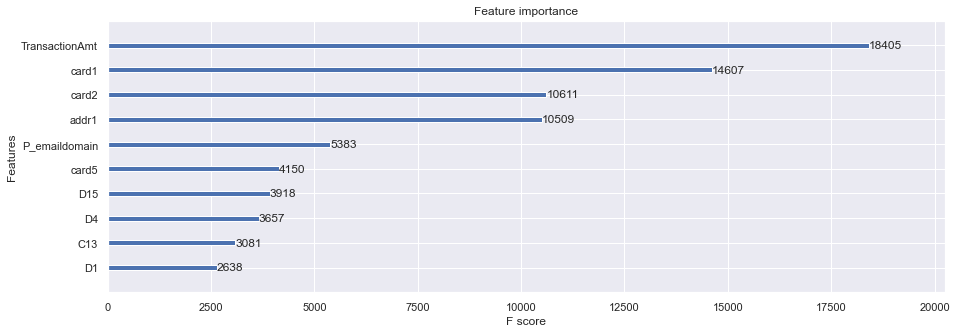

In [177]:
#Using the plot_importance function on the final tuned model
ax = xgb.plot_importance(xgb_model_tuned, max_num_features=10)
ax.figure.set_size_inches(15, 5)
plt.show()

The most important features are TransactionAmt, card1, card2, and addr1. The same four features were considered as the most important by the LGBM model, but in a different order of importance.